In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
# from base import *
from joblib import Parallel, delayed
import random
import scipy

In [3]:
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib
import six
import matplotlib.dates as mdates
import datetime
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('seaborn-poster')
from sklearn.metrics import r2_score

In [4]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [5]:
from MNMAPI import *
from MNM_mcnb import *
from mcDODE import *

In [6]:
data_folder = os.path.join('/home/lemma/Documents/MAC-POSTS/data/input_files_7link_multiclass_new')

In [7]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)

In [8]:
# nb.dump_to_folder('test')

In [9]:
from sklearn.metrics import r2_score
from scipy import stats
def r2(predictions, targets):
    y_bar = np.mean(targets)
    # diff = np.minimum(np.abs(predictions - targets), targets)
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

In [33]:
observed_link_list = [3, 4, 5, 6]
ml_car = 6
ml_truck = 5
data_dict = dict()
num_interval = nb.config.config_dict['DTA']['max_interval']
# true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 300
# true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 30
true_car_f, true_truck_f, _, _, _, _ = pickle.load(open('final_use.pickle', 'r'))
# true_car_x = np.random.rand(num_interval * len(observed_link_list)) * 100
# true_truck_x = np.random.rand(num_interval * len(observed_link_list)) * 10
# L_car_one = np.random.randint(2, size = (ml_car, len(observed_link_list)))
L_car_one = np.array([[1, 0, 0, 1],
                      [0, 0, 1, 1],
                      [1, 1, 0, 1],
                      [1, 0, 1, 1],
                      [1, 0, 0, 0],
                      [0, 1, 0, 1]])
L_truck_one = np.array([[1, 0, 0, 1],
                        [0, 0, 0, 1],
                        [1, 1, 0, 1],
                        [1, 0, 1, 0],
                        [0, 1, 0, 1]])
# L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

config = dict()
config['use_car_link_flow'] = True
config['use_truck_link_flow'] = True
config['use_car_link_tt'] = True
config['use_truck_link_tt'] = True
config['car_count_agg'] = True
config['truck_count_agg'] = True
config['link_car_flow_weight'] = 1
config['link_truck_flow_weight'] = 1
config['link_car_tt_weight'] = 0.1
config['link_truck_tt_weight'] = 0.1
config['num_data'] = 8
config['observed_links'] = observed_link_list
config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


config['compute_car_link_flow_loss'] = True
config['compute_truck_link_flow_loss'] = True
config['compute_car_link_tt_loss'] = True
config['compute_truck_link_tt_loss'] = True

dode = MCDODE(nb, config)
dta = dode._run_simulation(true_car_f, true_truck_f)
true_car_dar, true_truck_dar = dode.get_dar(dta, true_car_f, true_truck_f)

noise_level = 0.1
(true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
true_car_x = true_dar_car.dot(true_car_f)
true_truck_x = true_dar_truck.dot(true_truck_f)
data_dict['car_count_agg_L_list'] = list()
data_dict['truck_count_agg_L_list'] = list()
data_dict['car_link_flow'] = []
data_dict['truck_link_flow'] = []
data_dict['car_link_tt'] = []
data_dict['truck_link_tt'] = []
for i in range(config['num_data']):
    true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
#     true_car_tt = dta.get_car_link_tt_robust(np.arange(0, dode.num_loading_interval, dode.ass_freq),
#                              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    true_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    m_car = L_car.dot(true_car_x)
    m_truck = L_truck.dot(true_truck_x)
    data_dict['car_count_agg_L_list'].append(L_car)
    data_dict['truck_count_agg_L_list'].append(L_truck)
    data_dict['car_link_flow'].append(m_car + np.random.uniform(-1, 1, m_car.shape) * noise_level * m_car)
    data_dict['truck_link_flow'].append(m_truck + np.random.uniform(-1, 1, m_truck.shape) * noise_level * m_truck)
    data_dict['car_link_tt'].append(true_car_tt + np.random.uniform(-1, 1, true_car_tt.shape) * noise_level * true_car_tt)
    data_dict['truck_link_tt'].append(true_truck_tt + np.random.uniform(-1, 1, true_truck_tt.shape) * noise_level * true_truck_tt)

In [218]:
np.max(np.abs(true_car_dar.dot(true_car_f) - true_car_x))

9.500000000000455

In [219]:
np.max(np.abs(true_truck_dar.dot(true_truck_f) - true_truck_x))

1.5000000000001252

In [220]:
true_truck_x

array([ 7.2, 14. , 17.9, 12.4, 10.7,  5.1, 22.7, 12.1,  4.7,  5.9, 10.6,
        4.6, 13.3, 15.1, 24.7, 12.6, 14.9,  2.9, 26. , 10.9, 17.8, 14.1,
       22.1,  4.3, 13.1,  5.5, 21.1,  7.6,  6.1, 15.6, 20.5, 14.6,  9.1,
        2.7, 27.3, 19.1,  2. ,  8.9, 16.1, 13.5])

In [221]:
np.linalg.matrix_rank(np.matrix(L_car_one))

4

In [222]:
np.linalg.matrix_rank(np.matrix(L_truck_one))

4

In [223]:
dode.paths_list

[0, 1, 2]

In [224]:
true_car_tt

array([ 56.57142857,  56.57142857,  56.57142857,  56.57142857,
        55.        ,  55.        ,  50.        ,  55.        ,
        55.        ,  55.        ,  55.        ,  60.        ,
       105.        ,  50.        ,  50.        , 100.        ,
        70.        ,  55.        ,  55.        ,  60.        ,
       105.        ,  50.        ,  55.        , 105.        ,
       105.        , 105.        ,  55.        , 105.        ,
       105.        , 105.        ,  55.        , 100.        ,
       110.        ,  95.        ,  55.        ,  95.        ,
       110.        , 100.        ,  55.        ,  95.        ])

In [225]:
true_truck_x

array([ 7.2, 14. , 17.9, 12.4, 10.7,  5.1, 22.7, 12.1,  4.7,  5.9, 10.6,
        4.6, 13.3, 15.1, 24.7, 12.6, 14.9,  2.9, 26. , 10.9, 17.8, 14.1,
       22.1,  4.3, 13.1,  5.5, 21.1,  7.6,  6.1, 15.6, 20.5, 14.6,  9.1,
        2.7, 27.3, 19.1,  2. ,  8.9, 16.1, 13.5])

In [226]:
true_car_x

array([ 20.4,  42.2,  51.7,  33. ,  59.5,  22.5, 125. ,  69.9, 134.3,
       116.3, 244.5, 117.6, 104.6, 147. , 221.8, 116.8, 130.2,  24.6,
       227.9,  96.8,  75.6,  61.8, 105.9,  24. , 147.1,  55.8, 230. ,
        91.7,  48.7, 122.8, 174.9, 120.2,  59. ,  27.1, 202. , 146.5,
        14.6,  73.2, 136.7, 116. ])

In [227]:
m_truck

array([19.6, 12.4, 33.6, 25.1, 26.4, 22.8, 12.1, 27.9, 33.4, 17.2,  9.3,
        4.6, 15.2, 15.3, 10.5, 25.9, 12.6, 41. , 38. , 27.7, 25.8, 10.9,
       28.7, 40.9, 13.8, 22.1,  4.3, 36.2, 39.9, 18.4, 20.7,  7.6, 26.2,
       34.2, 13.1, 20.7, 14.6, 36.3, 26.6, 30.2, 28.2, 19.1, 30.9, 36.4,
       21.8, 15.5, 13.5, 24.4, 18.1, 22.4])

In [228]:
dode = MCDODE(nb, config)

In [229]:
dode.add_data(data_dict)

In [230]:
# nb.update_demand_path2(true_car_f, true_truck_f)
# nb.dump_to_folder("one")
# nb.update_demand_path2(car_flow, truck_flow)
# nb.dump_to_folder("two")

In [231]:
# (car_flow, truck_flow) = dode.init_path_flow(car_scale = 10, truck_scale = 1)

In [232]:
# pickle.dump((car_flow, truck_flow, None), open('test.pickle', 'w'))

In [233]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 1, 
                                                         truck_step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 1, adagrad = True)
print r2_score(car_flow, true_car_f), r2_score(truck_flow, true_truck_f)

Epoch: 0 Loss: 2029.81 truck_count_loss: 162.49|car_tt_loss: 19.53|car_count_loss: 1785.1|truck_tt_loss: 62.69|
Epoch: 1 Loss: 1932.09 truck_count_loss: 155.96|car_tt_loss: 19.53|car_count_loss: 1702.4|truck_tt_loss: 54.19|
Epoch: 2 Loss: 1823.11 truck_count_loss: 149.01|car_tt_loss: 19.53|car_count_loss: 1619.65|truck_tt_loss: 34.93|
Epoch: 3 Loss: 1732.95 truck_count_loss: 142.18|car_tt_loss: 19.53|car_count_loss: 1540.9|truck_tt_loss: 30.34|
Epoch: 4 Loss: 1636.89 truck_count_loss: 135.91|car_tt_loss: 19.53|car_count_loss: 1458.01|truck_tt_loss: 23.44|
Epoch: 5 Loss: 1546.63 truck_count_loss: 129.28|car_tt_loss: 19.53|car_count_loss: 1378.1|truck_tt_loss: 19.72|
Epoch: 6 Loss: 1469.61 truck_count_loss: 122.95|car_tt_loss: 19.39|car_count_loss: 1304.4|truck_tt_loss: 22.86|
Epoch: 7 Loss: 1379.03 truck_count_loss: 115.74|car_tt_loss: 18.44|car_count_loss: 1224.87|truck_tt_loss: 19.97|
Epoch: 8 Loss: 1296.36 truck_count_loss: 110.25|car_tt_loss: 17.86|car_count_loss: 1150.61|truck_tt_l

Epoch: 75 Loss: 149.23 truck_count_loss: 11.84|car_tt_loss: 10.69|car_count_loss: 114.13|truck_tt_loss: 12.56|
Epoch: 76 Loss: 151.0 truck_count_loss: 12.25|car_tt_loss: 10.49|car_count_loss: 115.78|truck_tt_loss: 12.49|
Epoch: 77 Loss: 150.21 truck_count_loss: 12.93|car_tt_loss: 9.84|car_count_loss: 114.77|truck_tt_loss: 12.67|
Epoch: 78 Loss: 150.08 truck_count_loss: 12.43|car_tt_loss: 10.42|car_count_loss: 113.09|truck_tt_loss: 14.14|
Epoch: 79 Loss: 149.59 truck_count_loss: 12.51|car_tt_loss: 11.27|car_count_loss: 112.45|truck_tt_loss: 13.35|
Epoch: 80 Loss: 147.41 truck_count_loss: 11.72|car_tt_loss: 8.85|car_count_loss: 113.99|truck_tt_loss: 12.86|
Epoch: 81 Loss: 150.14 truck_count_loss: 12.46|car_tt_loss: 11.93|car_count_loss: 112.34|truck_tt_loss: 13.41|
Epoch: 82 Loss: 148.97 truck_count_loss: 13.63|car_tt_loss: 9.46|car_count_loss: 112.83|truck_tt_loss: 13.05|
Epoch: 83 Loss: 150.67 truck_count_loss: 12.36|car_tt_loss: 10.72|car_count_loss: 113.14|truck_tt_loss: 14.45|
Epoch

In [55]:
# pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list, data_dict], open('final_use.pickle', 'w'))

In [97]:
color_list = ['teal', 'tomato', 'blue', 'sienna', 'plum', 'red', 'yellowgreen', 'khaki']
marker_list = ["o", "v", "^", "<", ">", "p", "D","*","s", "D", "p"]

In [118]:
_, _, car_flow, truck_flow, l_list, _ = pickle.load(open('final_use.pickle', 'r'))

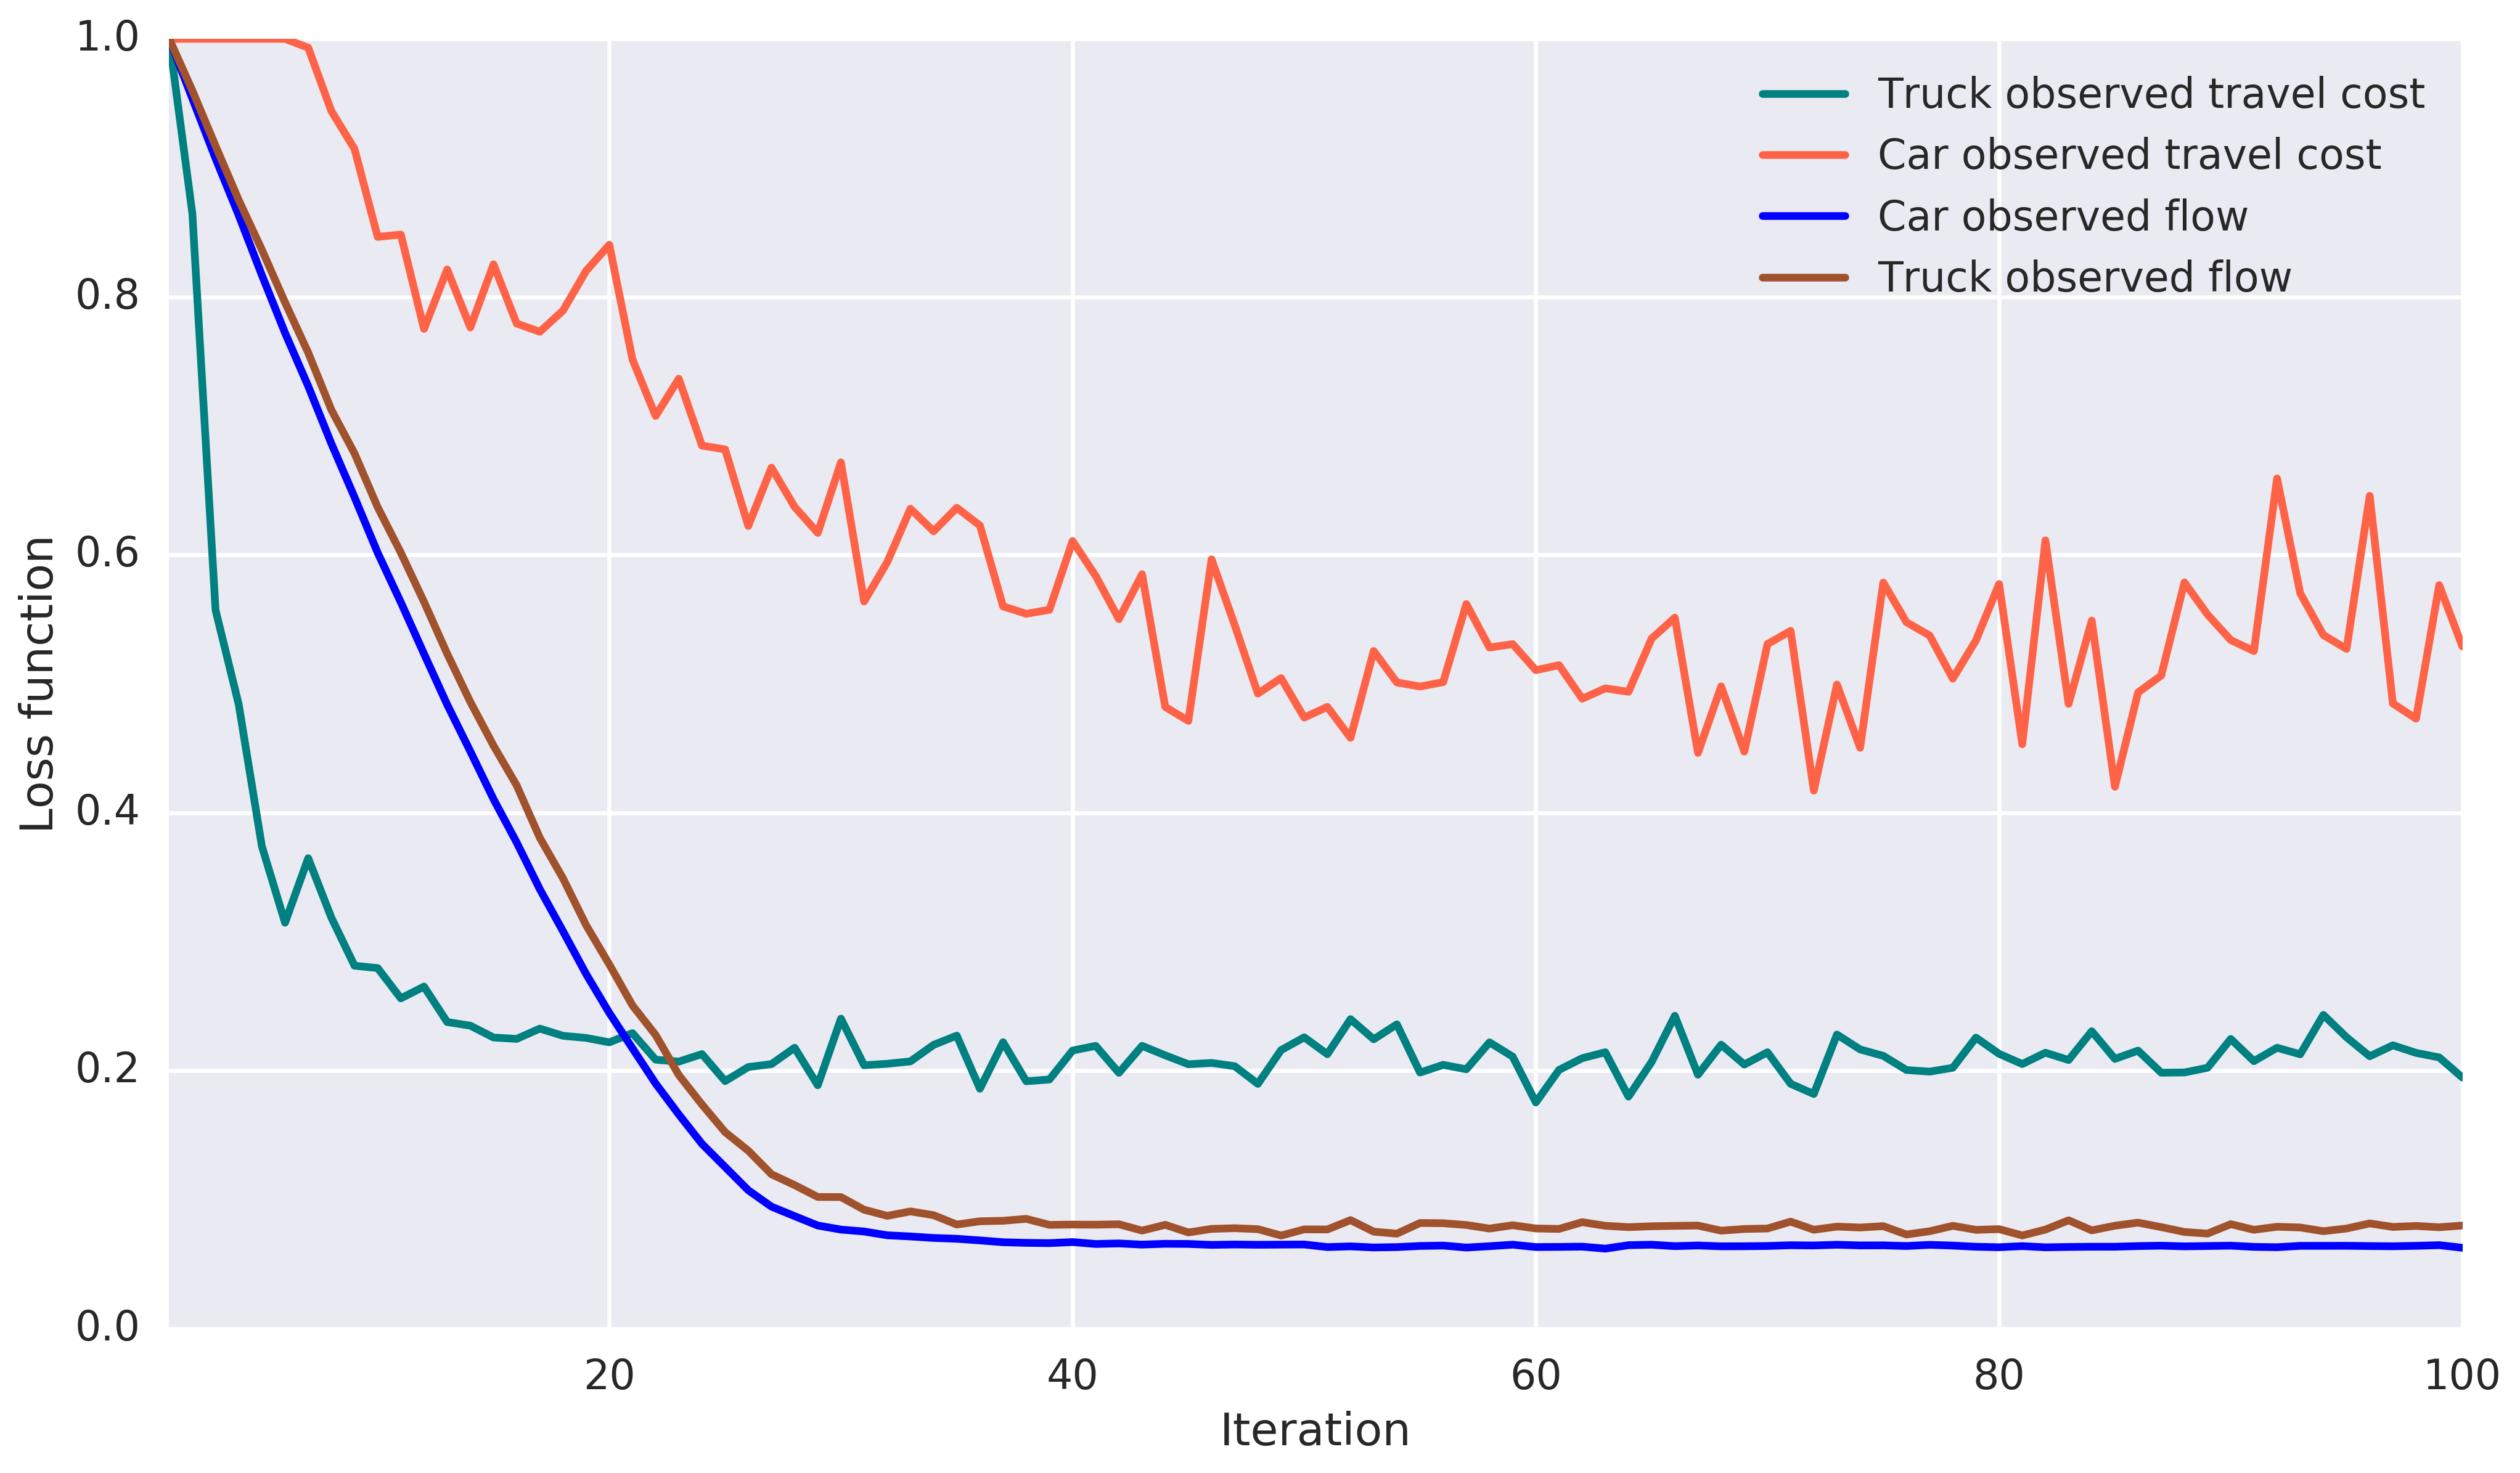

In [265]:
plt.figure(figsize = (16,9), dpi=300)
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['truck_tt_loss']/l_list[0][1]['truck_tt_loss'], l_list)), 
         color = color_list[0], linewidth = 3, label = "Truck observed travel cost")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_tt_loss']/l_list[0][1]['car_tt_loss'], l_list)),
         color = color_list[1], linewidth = 3, label = "Car observed travel cost")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_count_loss']/l_list[0][1]['car_count_loss'], l_list)),
         color = color_list[2], linewidth = 3, label = "Car observed flow")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['truck_count_loss']/l_list[0][1]['truck_count_loss'], l_list)),
         color = color_list[3], linewidth = 3, label = "Truck observed flow")
# plt.plot(range(len(l_list)), list(map(lambda x: x[0]/8, l_list)),
#          color = color_list[4], linewidth = 3, label = "Total cost")

plt.ylabel('Loss function')
plt.xlabel('Iteration')
plt.legend()
plt.ylim([0, 1])
plt.xlim([1, 100])
plt.show()

In [36]:
# (car_flow, truck_flow, l_list) = dode.estimate_path_flow_mp(max_epoch = 200, step_size = 0.1, car_init_scale = 5, 
#                                                           truck_init_scale = 0.1, 
#                                                           adagrad = True, n_process = 8)

In [37]:
# (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 200, step_size = 0.1, car_init_scale = 5, 
#                                                           truck_init_scale = 0.1, adagrad = True)

In [38]:
# plt.figure(figsize = (16,9), dpi=300)
# plt.plot(range(1,151), l_list, color = 'tomato', linewidth = 3)
# plt.ylabel('Loss')
# plt.xlabel('Iteration')
# plt.xlim([1, 150])
# plt.show()

In [237]:
dta = dode._run_simulation(true_car_f, truck_flow)
estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')

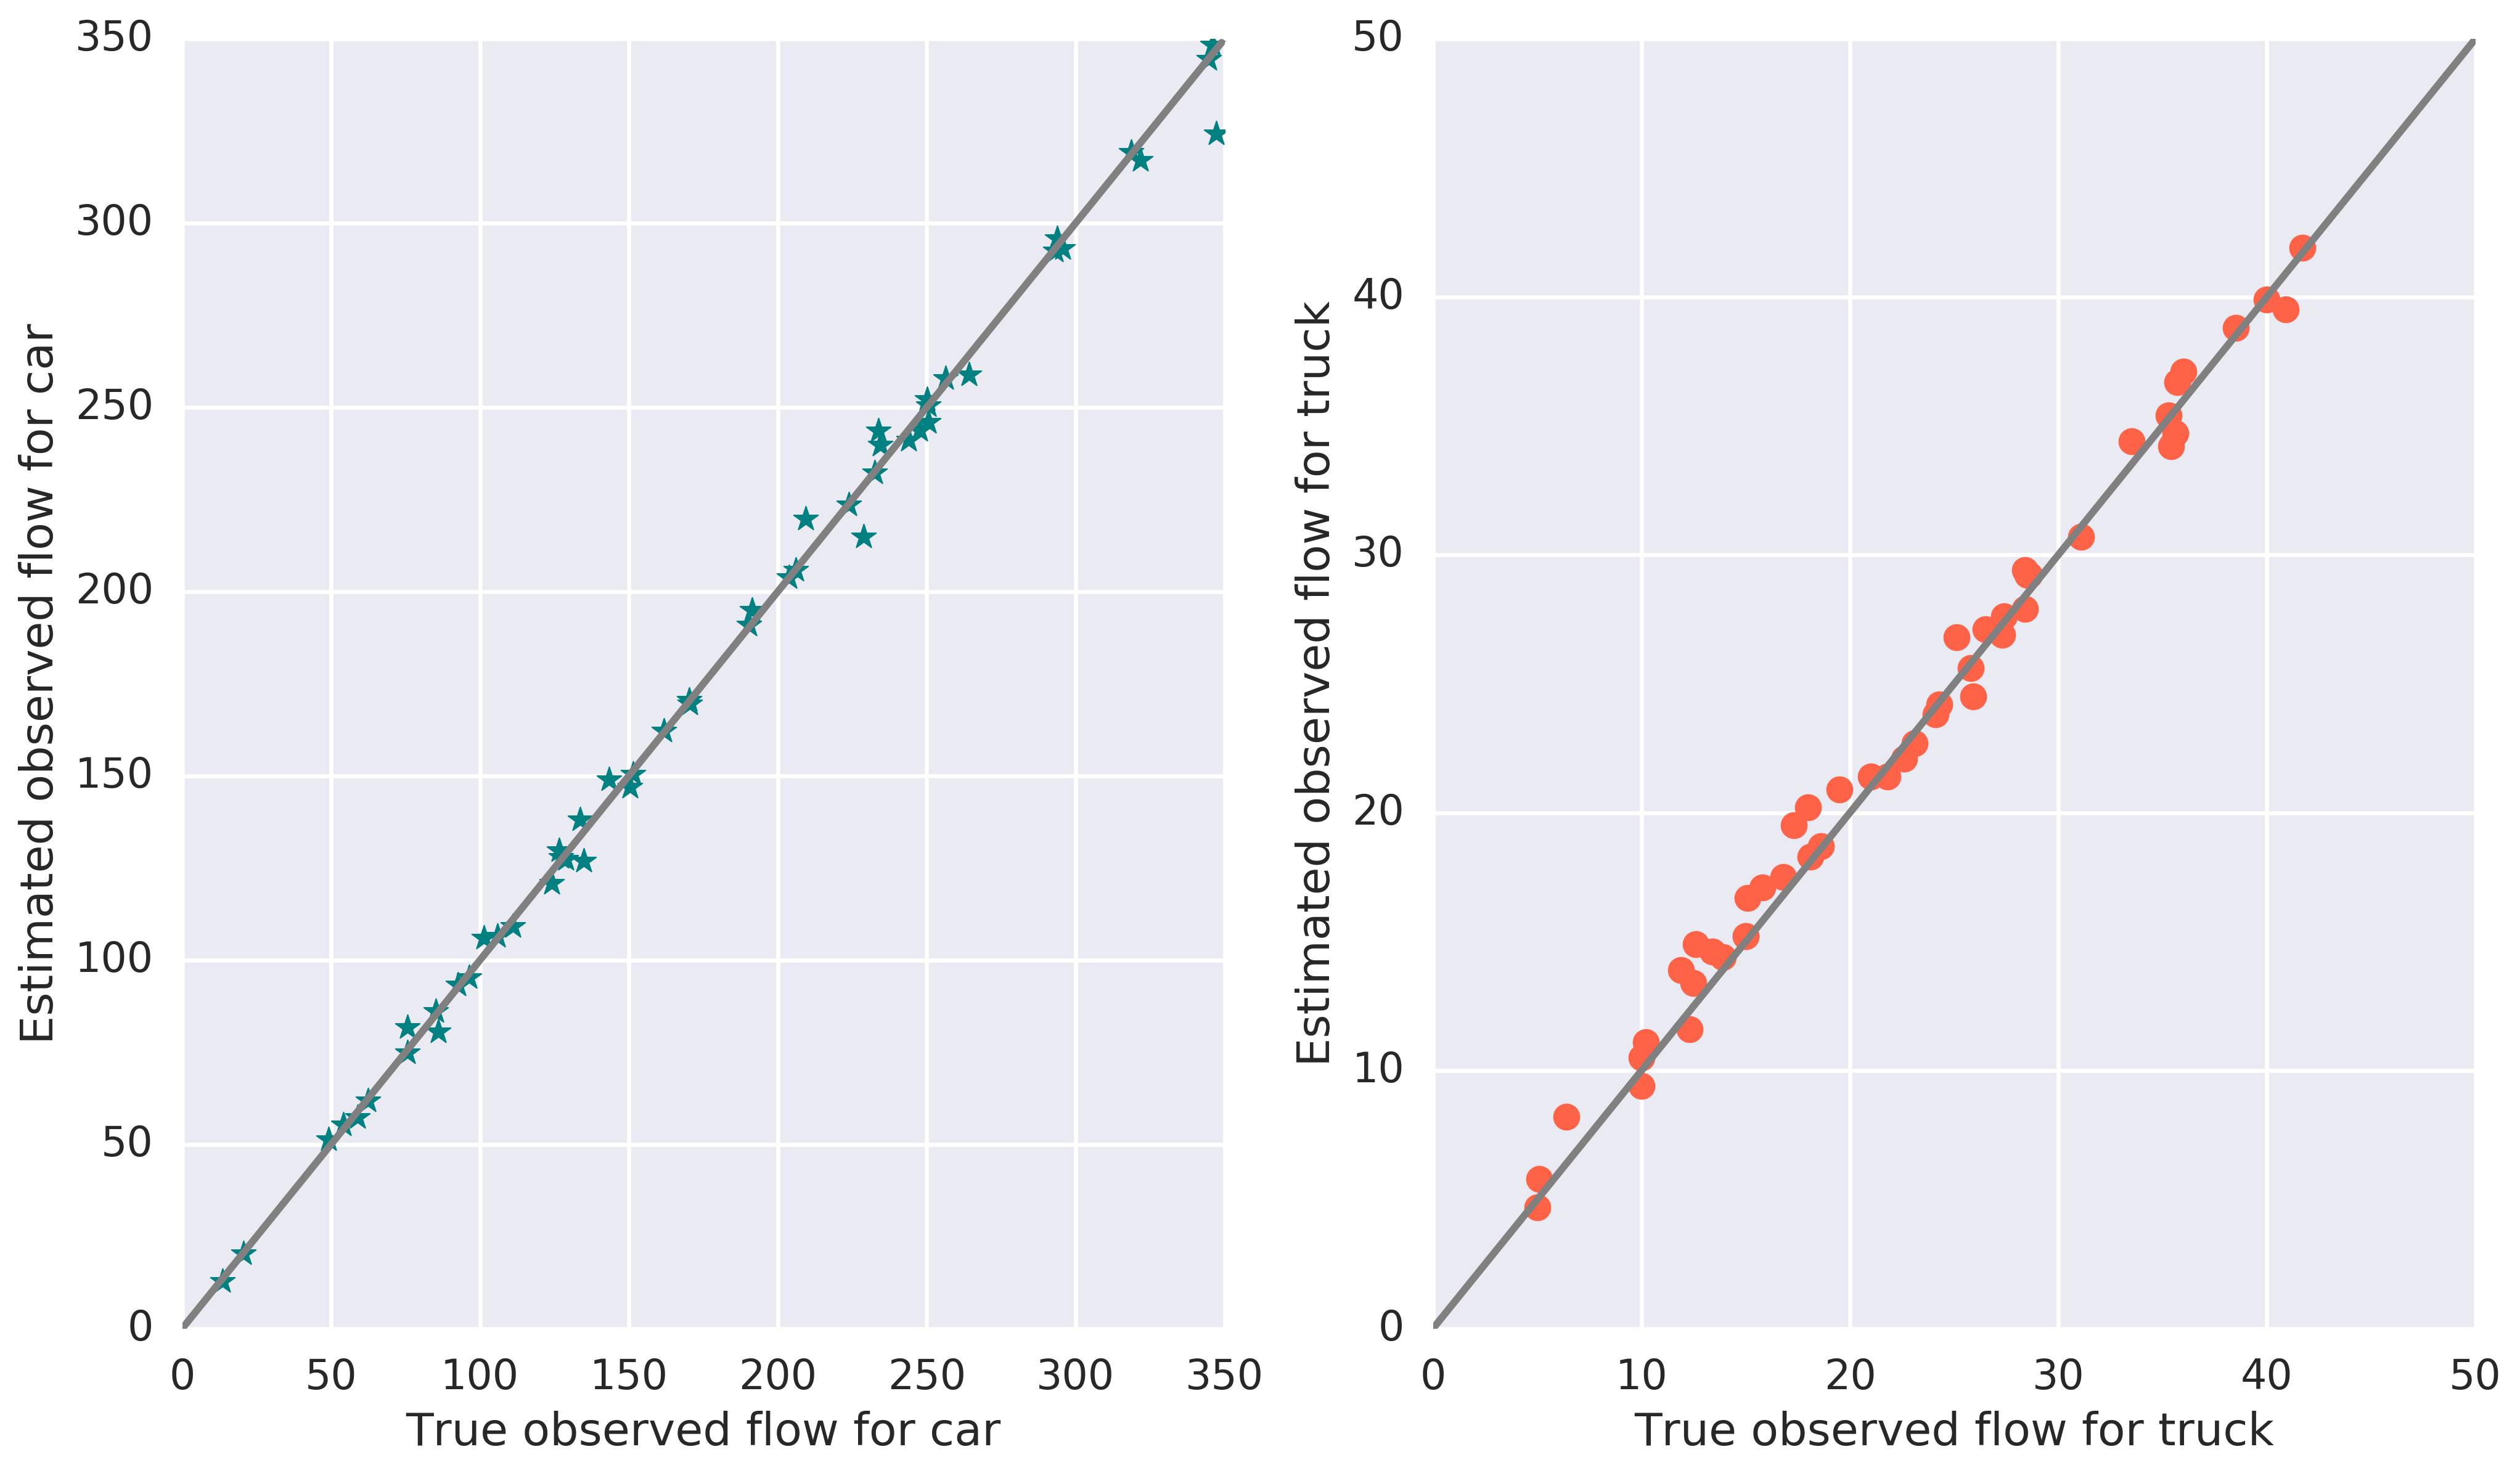

In [40]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(m_car, L_car.dot(estimated_car_x), label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(m_truck, L_truck.dot(estimated_truck_x), label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated otrue_car_ttbserved flow for car')
axes[0].set_xlabel('True observed flow for car')
axes[1].set_ylabel('Estimated observed flow for truck')
axes[1].set_xlabel('True observed flow for truck')
axes[0].set_xlim([0, 350])
axes[0].set_ylim([0, 350])
axes[1].set_xlim([0, 50])
axes[1].set_ylim([0, 50])
plt.show()

In [251]:
e_m_truck =L_truck.dot(estimated_truck_x)
print rmsn(m_car, L_car.dot(estimated_car_x))
print rmsn(m_truck[e_m_truck < 50], e_m_truck[e_m_truck < 50])

0.02267549082795872
0.041454060905167615


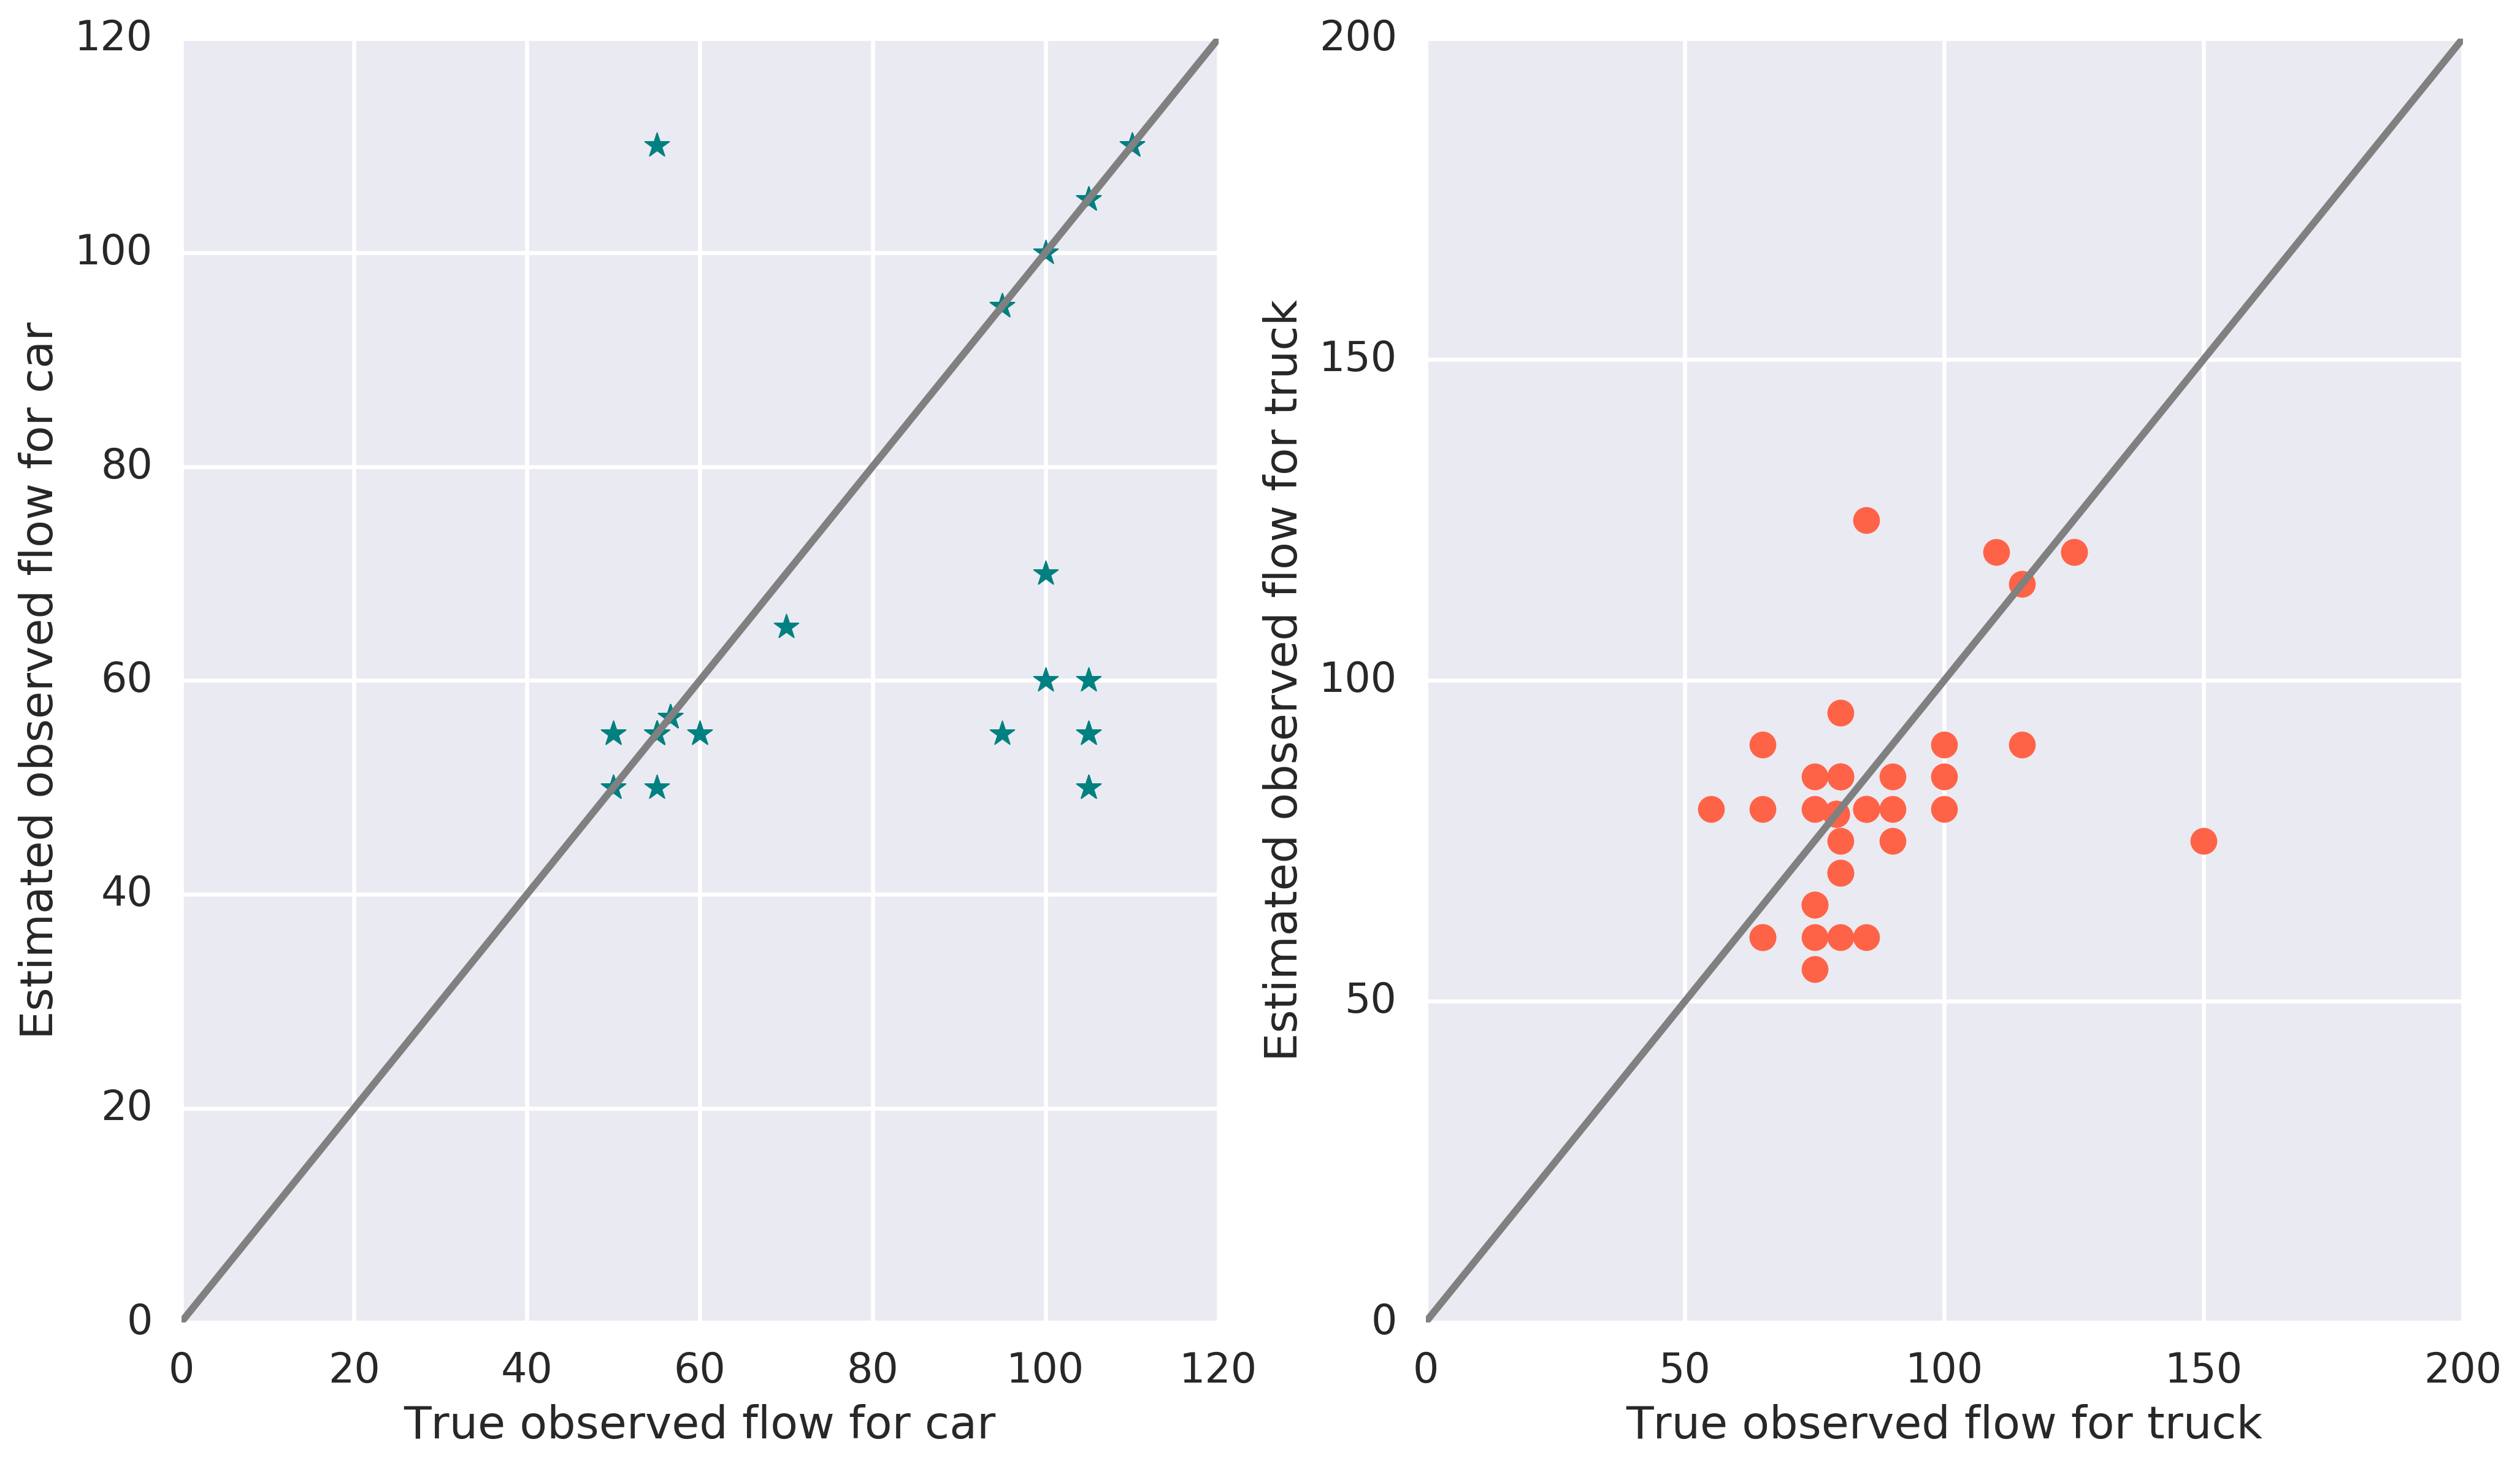

In [243]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(true_car_tt, dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F'), label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(true_truck_tt, dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F'), label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated observed flow for car')
axes[0].set_xlabel('True observed flow for car')
axes[1].set_ylabel('Estimated observed flow for truck')
axes[1].set_xlabel('True observed flow for truck')
axes[0].set_xlim([0, 120])
axes[0].set_ylim([0, 120])
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, 200])
plt.show()

In [259]:
est_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
print r2(true_car_tt, est_car_tt)
est_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
print r2(true_truck_tt, est_truck_tt)

0.894832751221212
0.9531414871721843


In [245]:
dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')

array([ 56.57142857,  56.57142857,  56.57142857,  56.57142857,
        55.        ,  55.        ,  55.        ,  55.        ,
       110.        ,  55.        ,  55.        ,  55.        ,
       105.        ,  50.        ,  55.        ,  60.        ,
        65.        ,  50.        ,  55.        ,  55.        ,
        60.        ,  50.        ,  55.        , 105.        ,
        55.        ,  50.        ,  55.        ,  55.        ,
       105.        ,  50.        ,  55.        ,  70.        ,
       110.        ,  95.        ,  55.        ,  55.        ,
       110.        , 100.        ,  55.        ,  95.        ])

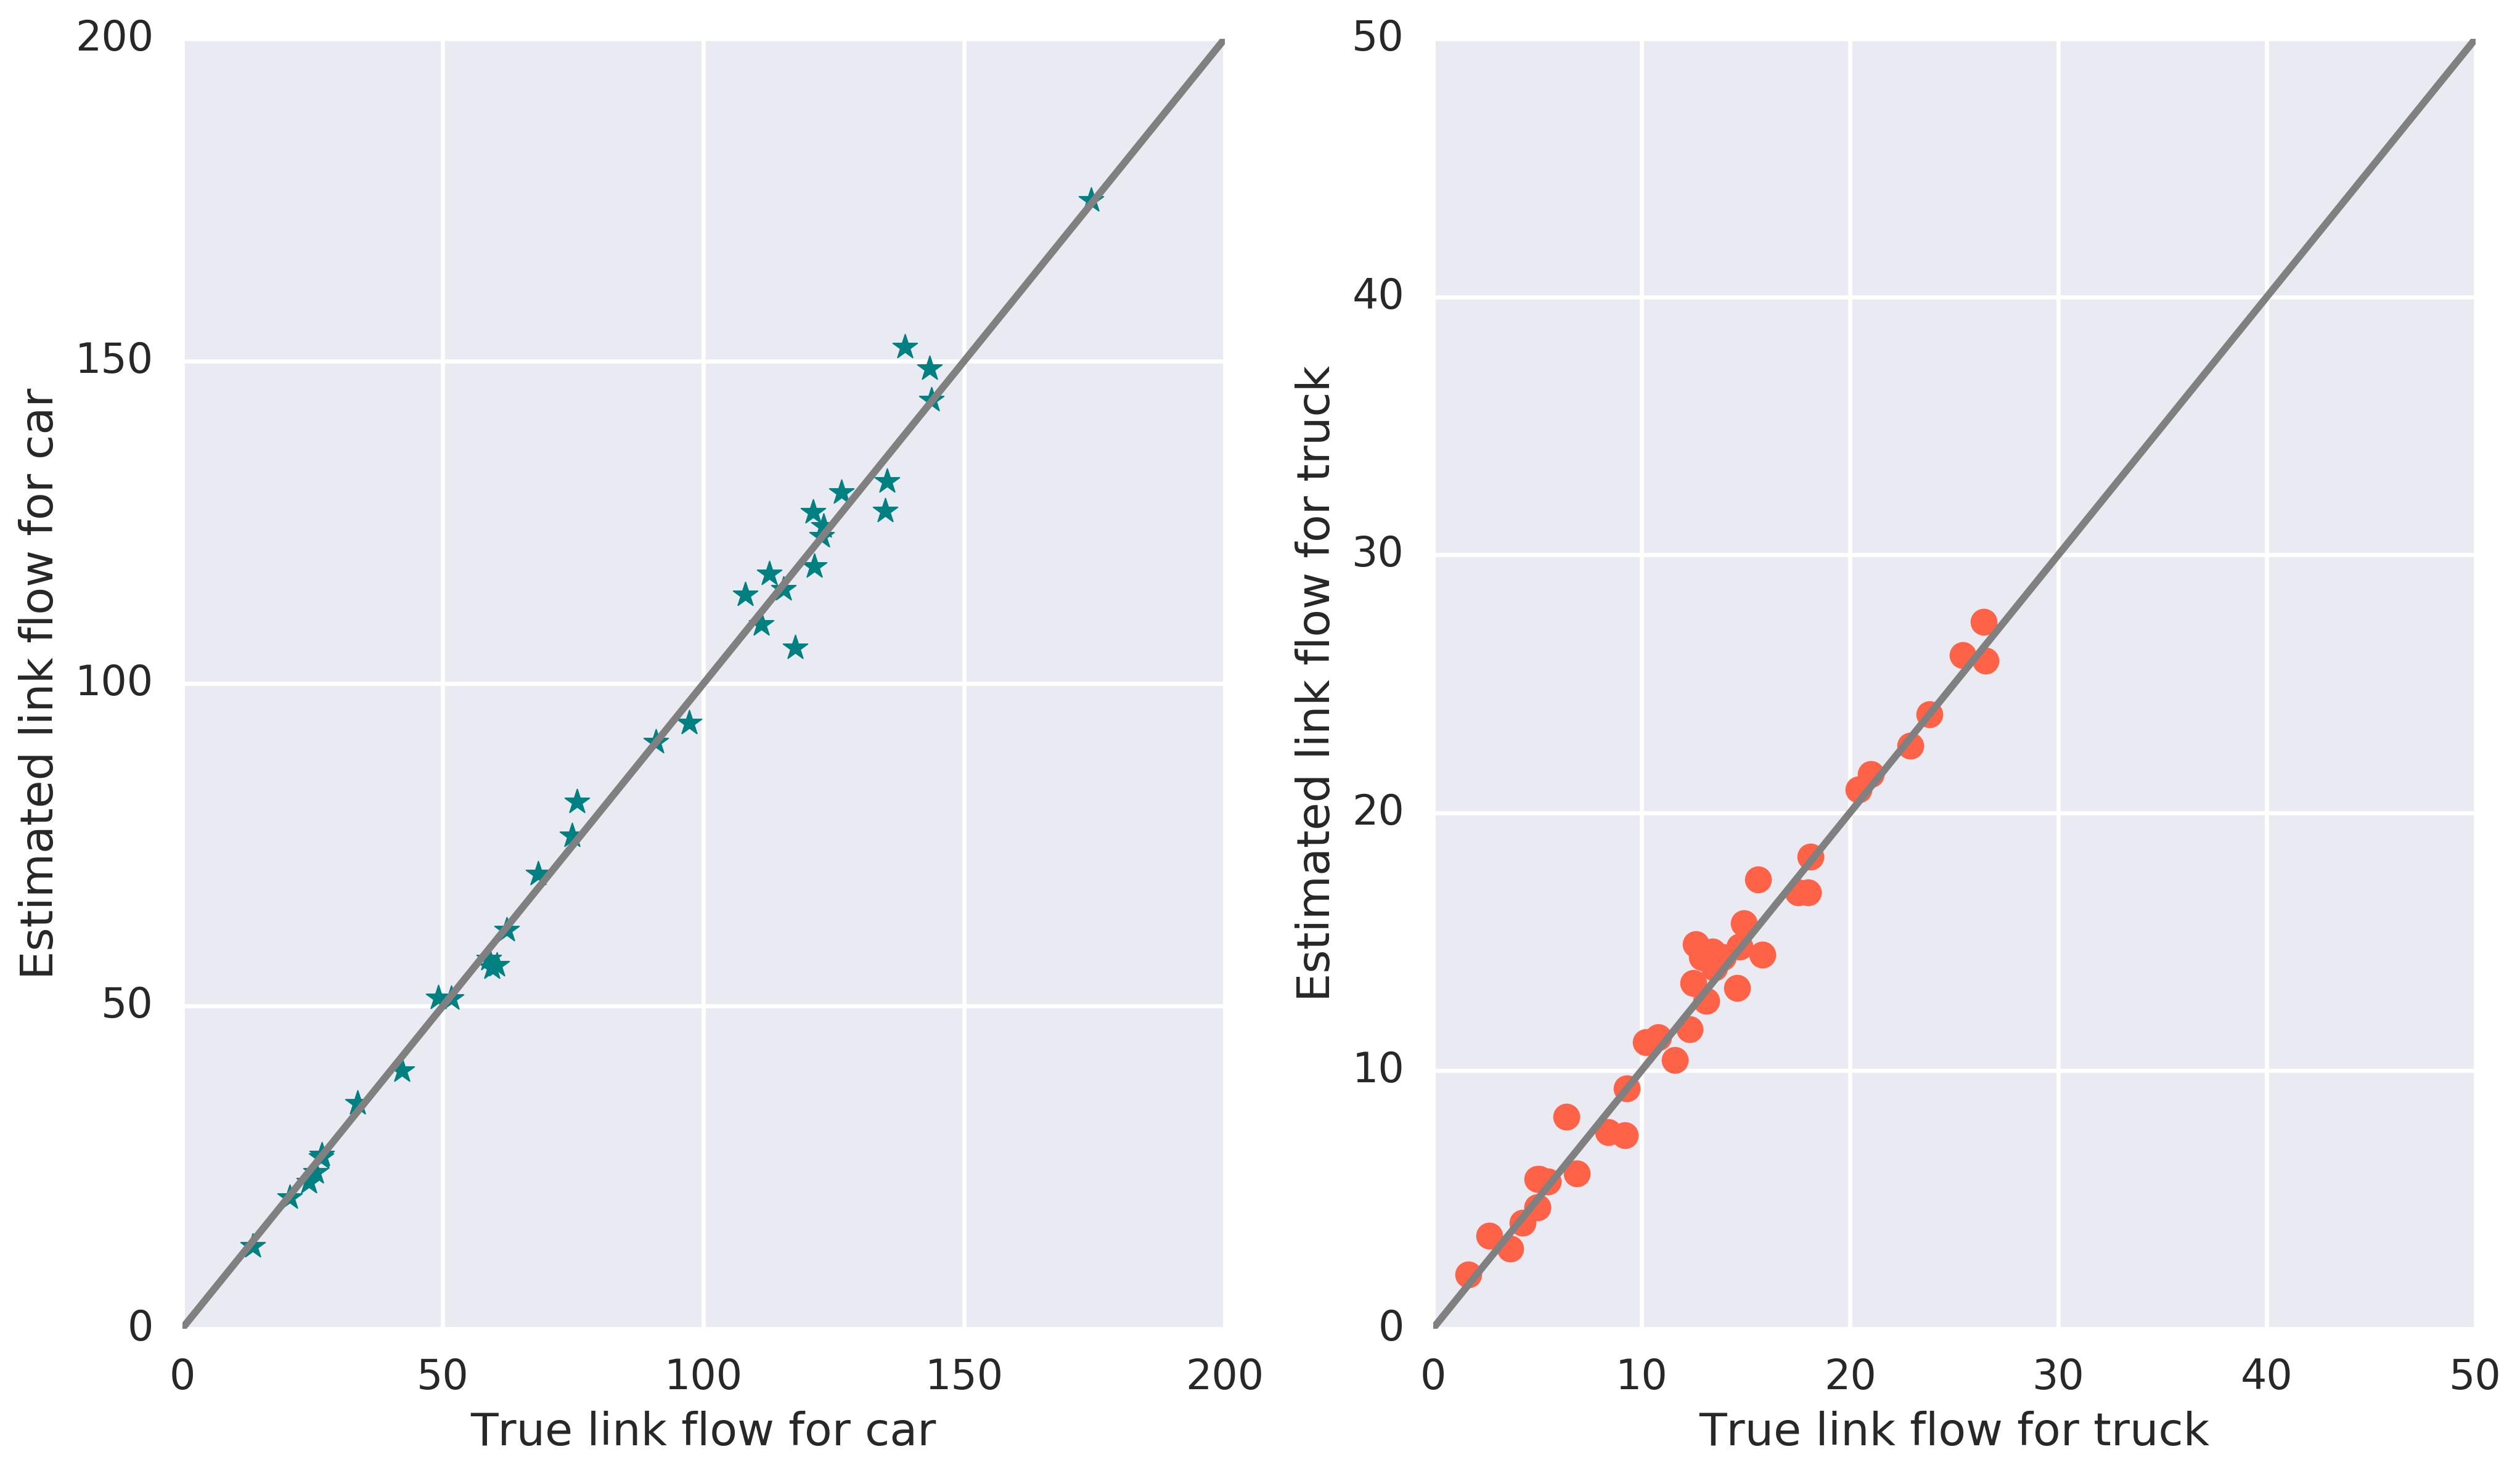

In [53]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(true_car_x, estimated_car_x, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(true_truck_x, estimated_truck_x, label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated link flow for car')
axes[0].set_xlabel('True link flow for car')
axes[1].set_ylabel('Estimated link flow for truck')
axes[1].set_xlabel('True link flow for truck')
axes[0].set_xlim([0, 200])
axes[0].set_ylim([0, 200])
axes[1].set_xlim([0, 50])
axes[1].set_ylim([0, 50])
plt.show()

In [260]:
print r2(true_car_x, estimated_car_x)
print r2(true_truck_x[estimated_truck_x<30], estimated_truck_x[estimated_truck_x<30])

0.9991752911327632
0.9963771266266701


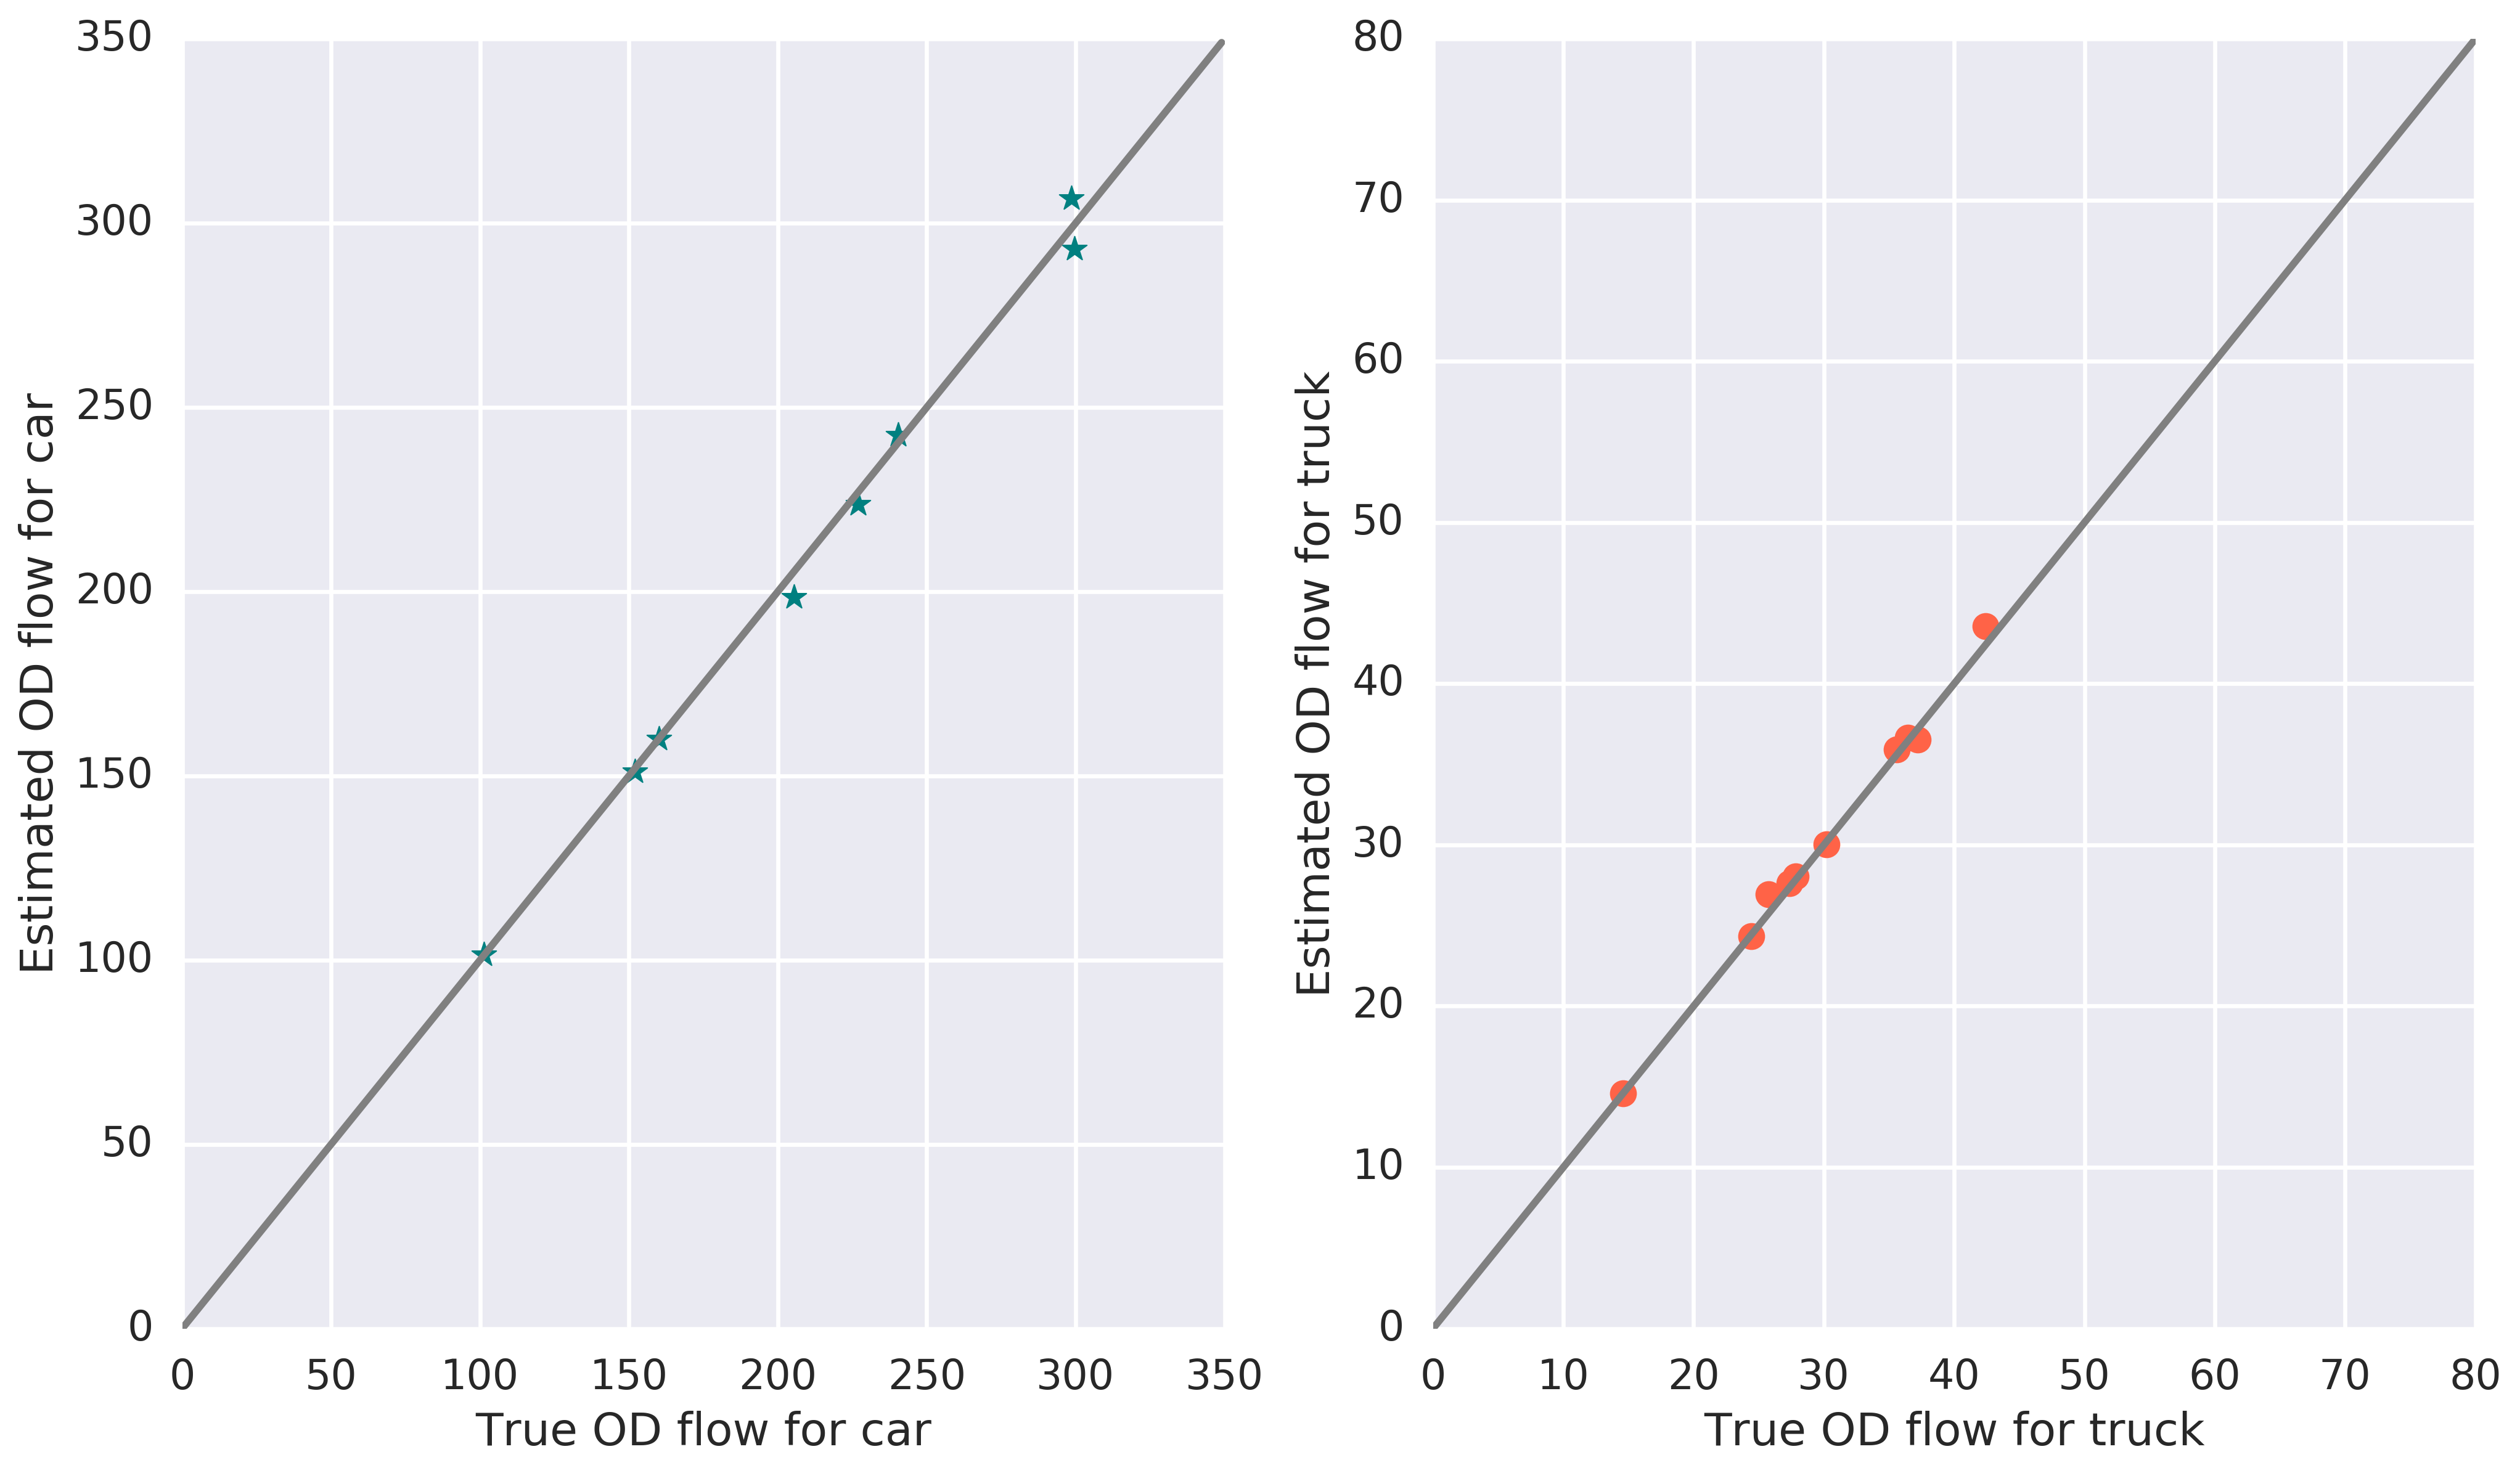

In [52]:
true_car_q = true_car_f.reshape(3, -1, order = 'F').sum(axis = 0)
est_car_q = car_flow.reshape(3, -1, order = 'F').sum(axis = 0)
true_truck_q = true_truck_f.reshape(3, -1, order = 'F').sum(axis = 0)
est_truck_q = truck_flow.reshape(3, -1, order = 'F').sum(axis = 0)

fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# truck_flow = true_truck_f + np.random.rand(len(true_car_f)) * 2- 1
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(true_car_q, est_car_q, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(true_truck_q, est_truck_q, label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated OD flow for car')
axes[0].set_xlabel('True OD flow for car')
axes[1].set_ylabel('Estimated OD flow for truck')
axes[1].set_xlabel('True OD flow for truck')
axes[0].set_xlim([0, 350])
axes[0].set_ylim([0, 350])
axes[1].set_xlim([0, 80])
axes[1].set_ylim([0, 80])
plt.show()

In [261]:
print r2(true_car_q, est_car_q)
print r2(true_truck_q, est_truck_q)

0.999663228595079
0.9995334163310872


## Without speed

In [112]:
config = dict()
config['use_car_link_flow'] = True
config['use_truck_link_flow'] = True
config['use_car_link_tt'] = False
config['use_truck_link_tt'] = False
config['car_count_agg'] = True
config['truck_count_agg'] = True
config['link_car_flow_weight'] = 1
config['link_truck_flow_weight'] = 1
config['link_car_tt_weight'] = 0.1
config['link_truck_tt_weight'] = 0.1
config['num_data'] = 8
config['observed_links'] = observed_link_list
config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


config['compute_car_link_flow_loss'] = True
config['compute_truck_link_flow_loss'] = True
config['compute_car_link_tt_loss'] = True
config['compute_truck_link_tt_loss'] = True

In [113]:
dode = MCDODE(nb, config)
dode.add_data(data_dict)

In [ ]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 1, 
                                                         truck_step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 1, adagrad = True)
print r2_score(car_flow, true_car_f), r2_score(truck_flow, true_truck_f)

In [126]:
# pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list, data_dict], open('no_spd.pickle', 'w'))

In [127]:
true_car_q = true_car_f.reshape(3, -1, order = 'F').sum(axis = 0)
est_car_q = car_flow.reshape(3, -1, order = 'F').sum(axis = 0)
true_truck_q = true_truck_f.reshape(3, -1, order = 'F').sum(axis = 0)
est_truck_q = truck_flow.reshape(3, -1, order = 'F').sum(axis = 0)


In [128]:
print r2_score(true_car_q, est_car_q)
print r2_score(true_truck_q, est_truck_q)

0.9971328827038165
0.9920545058466652


In [130]:
_, _, _, _, l_list, _ = pickle.load(open('final_use.pickle', 'r'))
_, _, _, _, l_list_nospd, _ = pickle.load(open('no_spd.pickle', 'r'))

In [ ]:
plt.figure(figsize = (16,9), dpi=300)
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_count_loss'], l_list)), 
         color = color_list[0], linewidth = 3, label = "Truck observed travel cost")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_count_loss'], l_list_nospd)),
         color = color_list[1], linewidth = 3, label = "ooo")
# plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_count_loss']/10, l_list)),
#          color = color_list[2], linewidth = 3, label = "Car observed flow")
# plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['truck_count_loss'], l_list)),
#          color = color_list[3], linewidth = 3, label = "Truck observed flow")
# plt.plot(range(len(l_list)), list(map(lambda x: x[0]/8, l_list)),
#          color = color_list[4], linewidth = 3, label = "Total cost")

plt.ylabel('Loss function')
plt.xlabel('Iteration')
plt.legend()
plt.xlim([1, 100])
plt.show()

## Multiple cpu

In [280]:
observed_link_list = [3, 4, 5, 6]
ml_car = 6
ml_truck = 5
data_dict = dict()
num_interval = nb.config.config_dict['DTA']['max_interval']
# true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 300
# true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 30
true_car_f, true_truck_f, _, _, _, _ = pickle.load(open('final_use.pickle', 'r'))
# true_car_x = np.random.rand(num_interval * len(observed_link_list)) * 100
# true_truck_x = np.random.rand(num_interval * len(observed_link_list)) * 10
# L_car_one = np.random.randint(2, size = (ml_car, len(observed_link_list)))
L_car_one = np.array([[1, 0, 0, 1],
                      [0, 0, 1, 1],
                      [1, 1, 0, 1],
                      [1, 0, 1, 1],
                      [1, 0, 0, 0],
                      [0, 1, 0, 1]])
L_truck_one = np.array([[1, 0, 0, 1],
                        [0, 0, 0, 1],
                        [1, 1, 0, 1],
                        [1, 0, 1, 0],
                        [0, 1, 0, 1]])
# L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

config = dict()
config['use_car_link_flow'] = True
config['use_truck_link_flow'] = True
config['use_car_link_tt'] = True
config['use_truck_link_tt'] = True
config['car_count_agg'] = True
config['truck_count_agg'] = True
config['link_car_flow_weight'] = 1
config['link_truck_flow_weight'] = 1
config['link_car_tt_weight'] = 0.1
config['link_truck_tt_weight'] = 0.1
config['num_data'] = 8
config['observed_links'] = observed_link_list
config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


config['compute_car_link_flow_loss'] = True
config['compute_truck_link_flow_loss'] = True
config['compute_car_link_tt_loss'] = True
config['compute_truck_link_tt_loss'] = True

dode = MCDODE(nb, config)
dta = dode._run_simulation(true_car_f, true_truck_f)
true_car_dar, true_truck_dar = dode.get_dar(dta, true_car_f, true_truck_f)

noise_level = 0.1
# (true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
# true_car_x = true_dar_car.dot(true_car_f)
# true_truck_x = true_dar_truck.dot(true_truck_f)
data_dict['car_count_agg_L_list'] = list()
data_dict['truck_count_agg_L_list'] = list()
data_dict['car_link_flow'] = []
data_dict['truck_link_flow'] = []
data_dict['car_link_tt'] = []
data_dict['truck_link_tt'] = []
for i in range(config['num_data']):
    true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
#     true_car_tt = dta.get_car_link_tt_robust(np.arange(0, dode.num_loading_interval, dode.ass_freq),
#                              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    true_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    m_car = L_car.dot(true_car_x)
    m_truck = L_truck.dot(true_truck_x)
    data_dict['car_count_agg_L_list'].append(L_car)
    data_dict['truck_count_agg_L_list'].append(L_truck)
    data_dict['car_link_flow'].append(m_car + np.random.uniform(-1, 1, m_car.shape) * noise_level * m_car)
    data_dict['truck_link_flow'].append(m_truck + np.random.uniform(-1, 1, m_truck.shape) * noise_level * m_truck)
    data_dict['car_link_tt'].append(true_car_tt + np.random.uniform(-1, 1, true_car_tt.shape) * noise_level * true_car_tt)
    data_dict['truck_link_tt'].append(true_truck_tt + np.random.uniform(-1, 1, true_truck_tt.shape) * noise_level * true_truck_tt)

In [281]:
dode = MCDODE(nb, config)
dode.add_data(data_dict)

In [ ]:
for n in [1,2,4,8]:
    (car_flow, truck_flow, l_list) = dode.estimate_path_flow_mp(max_epoch = 100, car_step_size = 1, 
                                                             truck_step_size = 0.1, car_init_scale = 5, 
                                                              truck_init_scale = 1, adagrad = True, 
                                                                record_time = True, n_process = n)
#     print r2_score(car_flow, true_car_f), r2_score(truck_flow, true_truck_f)
    print l_list[99][2]
    pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list, data_dict], open("cpu" + str(n)+ '.pickle', 'w'))

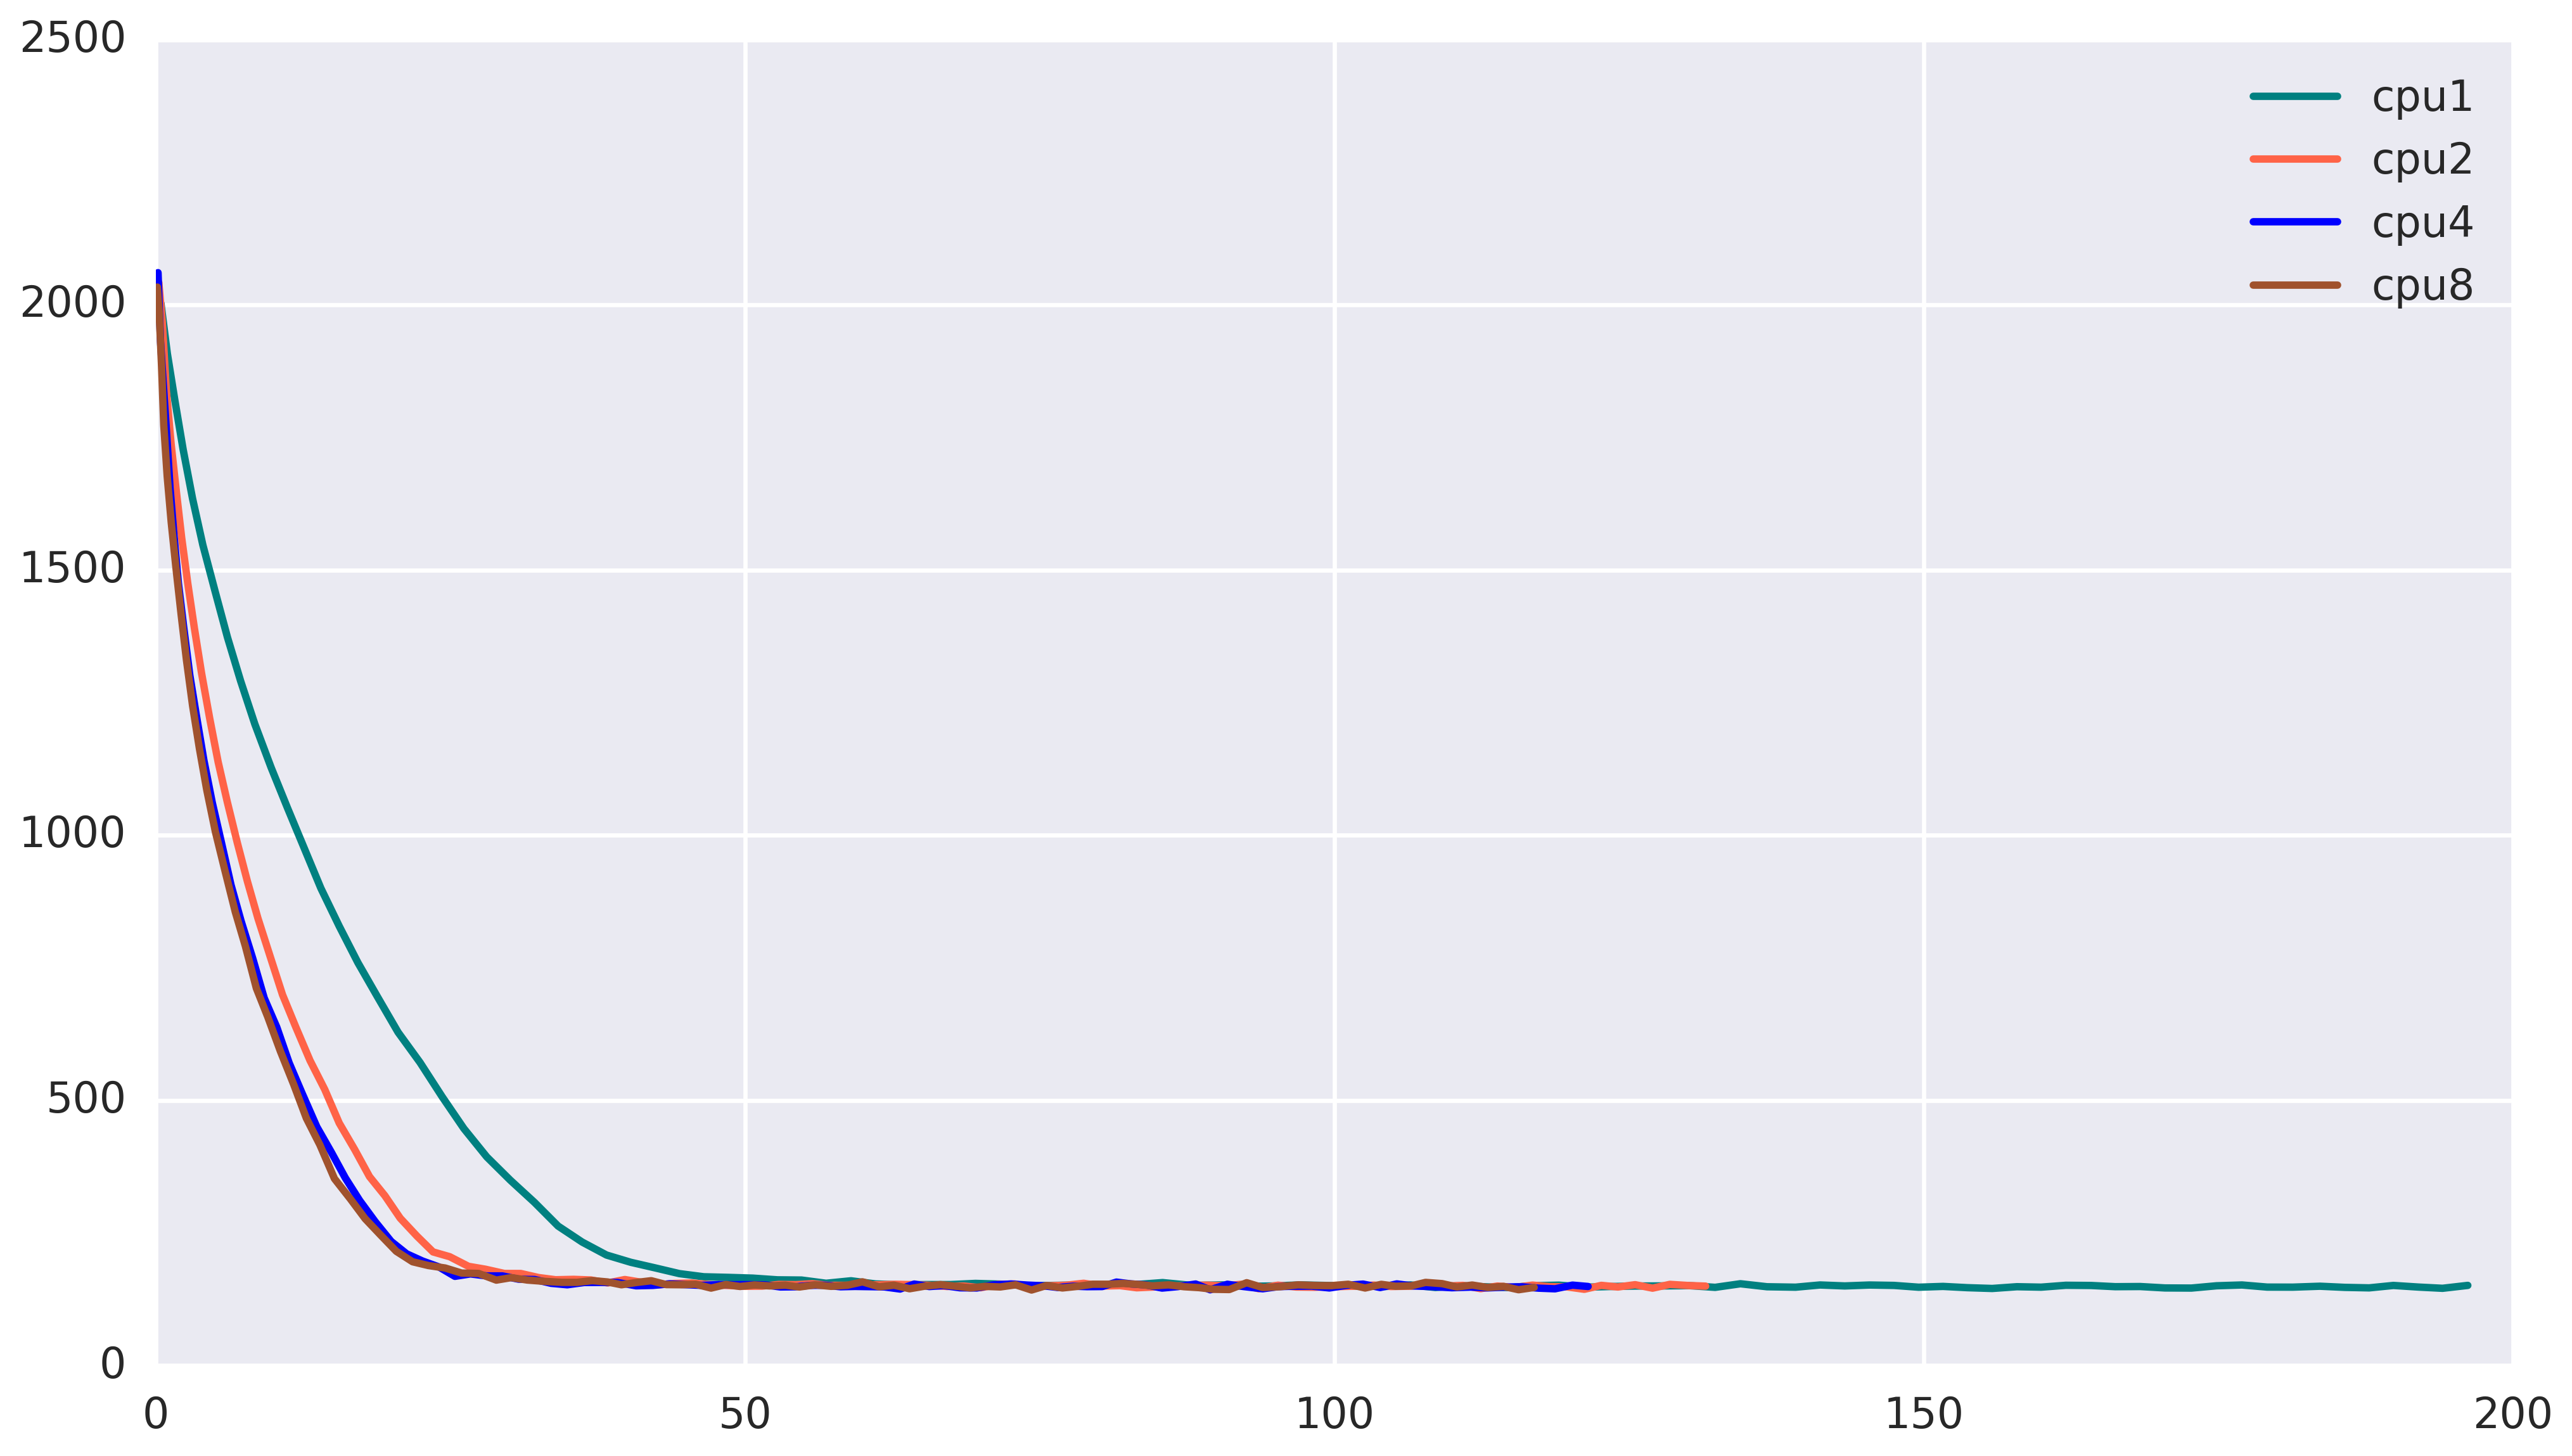

In [287]:
plt.figure(figsize=(16, 9), dpi=300)
for i, n in enumerate([1,2,4,8]):
    [_, _, _, _, l_list, _] = pickle.load(open("cpu" + str(n)+ '.pickle', 'r'))
#     axes[0].plot(np.arange(100)+1, list(map(lambda x: x[0]/8, l_list)) , label = "cpu" + str(n), color = color_list[i])
    plt.plot(list(map(lambda x: x[2], l_list)), list(map(lambda x: x[0]/8, l_list)), label = "cpu" + str(n), color = color_list[i])
plt.legend()
plt.show()

## Compare algorithm

In [11]:
dode = MCDODE(nb, config)
dode.add_data(data_dict)

In [297]:
(car_flow, truck_flow, l_list_gd) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 0.01, 
                                                          truck_step_size = 0.001, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = False)

Epoch: 0 Loss: 1379.03 truck_count_loss: 155.3|car_tt_loss: 25.31|car_count_loss: 1108.81|truck_tt_loss: 89.61|
Epoch: 1 Loss: 762.21 truck_count_loss: 140.33|car_tt_loss: 91.04|car_count_loss: 466.05|truck_tt_loss: 64.8|
Epoch: 2 Loss: 548.81 truck_count_loss: 133.55|car_tt_loss: 34.79|car_count_loss: 328.51|truck_tt_loss: 51.96|
Epoch: 3 Loss: 445.36 truck_count_loss: 127.52|car_tt_loss: 12.96|car_count_loss: 267.87|truck_tt_loss: 37.01|
Epoch: 4 Loss: 417.87 truck_count_loss: 123.53|car_tt_loss: 12.96|car_count_loss: 248.98|truck_tt_loss: 32.4|
Epoch: 5 Loss: 398.05 truck_count_loss: 119.36|car_tt_loss: 13.32|car_count_loss: 235.73|truck_tt_loss: 29.64|
Epoch: 6 Loss: 386.79 truck_count_loss: 116.18|car_tt_loss: 14.12|car_count_loss: 225.88|truck_tt_loss: 30.61|
Epoch: 7 Loss: 375.08 truck_count_loss: 113.32|car_tt_loss: 14.47|car_count_loss: 218.66|truck_tt_loss: 28.62|
Epoch: 8 Loss: 368.03 truck_count_loss: 110.39|car_tt_loss: 14.02|car_count_loss: 214.1|truck_tt_loss: 29.51|
Epo

Epoch: 75 Loss: 213.62 truck_count_loss: 52.88|car_tt_loss: 12.59|car_count_loss: 127.32|truck_tt_loss: 20.82|
Epoch: 76 Loss: 211.68 truck_count_loss: 51.96|car_tt_loss: 12.53|car_count_loss: 125.66|truck_tt_loss: 21.53|
Epoch: 77 Loss: 208.5 truck_count_loss: 52.11|car_tt_loss: 11.4|car_count_loss: 123.96|truck_tt_loss: 21.03|
Epoch: 78 Loss: 210.83 truck_count_loss: 51.26|car_tt_loss: 11.65|car_count_loss: 126.02|truck_tt_loss: 21.9|
Epoch: 79 Loss: 206.25 truck_count_loss: 51.21|car_tt_loss: 10.81|car_count_loss: 123.22|truck_tt_loss: 21.01|
Epoch: 80 Loss: 209.3 truck_count_loss: 51.0|car_tt_loss: 11.0|car_count_loss: 125.33|truck_tt_loss: 21.96|
Epoch: 81 Loss: 209.05 truck_count_loss: 50.84|car_tt_loss: 10.69|car_count_loss: 126.16|truck_tt_loss: 21.36|
Epoch: 82 Loss: 208.1 truck_count_loss: 50.11|car_tt_loss: 10.88|car_count_loss: 126.56|truck_tt_loss: 20.54|
Epoch: 83 Loss: 206.29 truck_count_loss: 49.82|car_tt_loss: 11.98|car_count_loss: 124.24|truck_tt_loss: 20.24|
Epoch: 8

In [299]:
pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list_gd, data_dict], open("sgd.pickle", 'w'))

In [15]:
(car_flow, truck_flow, l_list_gd) = dode.estimate_path_flow_gd(max_epoch = 100, car_step_size = 0.01, 
                                                          truck_step_size = 0.001, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = False)

Epoch: 0 Loss: 2038.58 truck_count_loss: 173.97|car_tt_loss: 14.46|car_count_loss: 1828.11|truck_tt_loss: 22.04|
Epoch: 1 Loss: 1784.4 truck_count_loss: 168.95|car_tt_loss: 14.46|car_count_loss: 1518.73|truck_tt_loss: 82.26|
Epoch: 2 Loss: 1562.9 truck_count_loss: 166.96|car_tt_loss: 14.77|car_count_loss: 1334.6|truck_tt_loss: 46.57|
Epoch: 3 Loss: 1467.26 truck_count_loss: 165.74|car_tt_loss: 18.01|car_count_loss: 1204.49|truck_tt_loss: 79.03|
Epoch: 4 Loss: 1367.32 truck_count_loss: 164.93|car_tt_loss: 16.27|car_count_loss: 1104.53|truck_tt_loss: 81.58|
Epoch: 5 Loss: 1241.6 truck_count_loss: 164.14|car_tt_loss: 15.52|car_count_loss: 1023.35|truck_tt_loss: 38.59|
Epoch: 6 Loss: 1213.21 truck_count_loss: 163.37|car_tt_loss: 16.1|car_count_loss: 957.05|truck_tt_loss: 76.68|
Epoch: 7 Loss: 1118.13 truck_count_loss: 162.5|car_tt_loss: 15.51|car_count_loss: 897.84|truck_tt_loss: 42.28|
Epoch: 8 Loss: 1083.64 truck_count_loss: 162.25|car_tt_loss: 15.03|car_count_loss: 847.35|truck_tt_loss:

Epoch: 74 Loss: 471.49 truck_count_loss: 145.6|car_tt_loss: 12.13|car_count_loss: 276.15|truck_tt_loss: 37.62|
Epoch: 75 Loss: 467.12 truck_count_loss: 145.36|car_tt_loss: 12.13|car_count_loss: 274.61|truck_tt_loss: 35.03|
Epoch: 76 Loss: 478.61 truck_count_loss: 145.02|car_tt_loss: 12.02|car_count_loss: 274.33|truck_tt_loss: 47.24|
Epoch: 77 Loss: 480.88 truck_count_loss: 144.64|car_tt_loss: 11.7|car_count_loss: 273.06|truck_tt_loss: 51.48|
Epoch: 78 Loss: 474.7 truck_count_loss: 144.73|car_tt_loss: 11.71|car_count_loss: 271.42|truck_tt_loss: 46.83|
Epoch: 79 Loss: 469.09 truck_count_loss: 144.33|car_tt_loss: 12.31|car_count_loss: 269.8|truck_tt_loss: 42.65|
Epoch: 80 Loss: 459.26 truck_count_loss: 144.4|car_tt_loss: 12.27|car_count_loss: 269.66|truck_tt_loss: 32.92|
Epoch: 81 Loss: 464.35 truck_count_loss: 144.41|car_tt_loss: 12.0|car_count_loss: 270.3|truck_tt_loss: 37.64|
Epoch: 82 Loss: 470.91 truck_count_loss: 143.96|car_tt_loss: 11.94|car_count_loss: 269.01|truck_tt_loss: 46.0|


In [16]:
pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list_gd, data_dict], open("gd.pickle", 'w'))

In [17]:
[_, _, _, _, l_list1, _] = pickle.load(open("final_use.pickle", 'r'))
[_, _, _, _, l_list2, _] = pickle.load(open("sgd.pickle", 'r'))
[_, _, _, _, l_list3, _] = pickle.load(open("gd.pickle", 'r'))

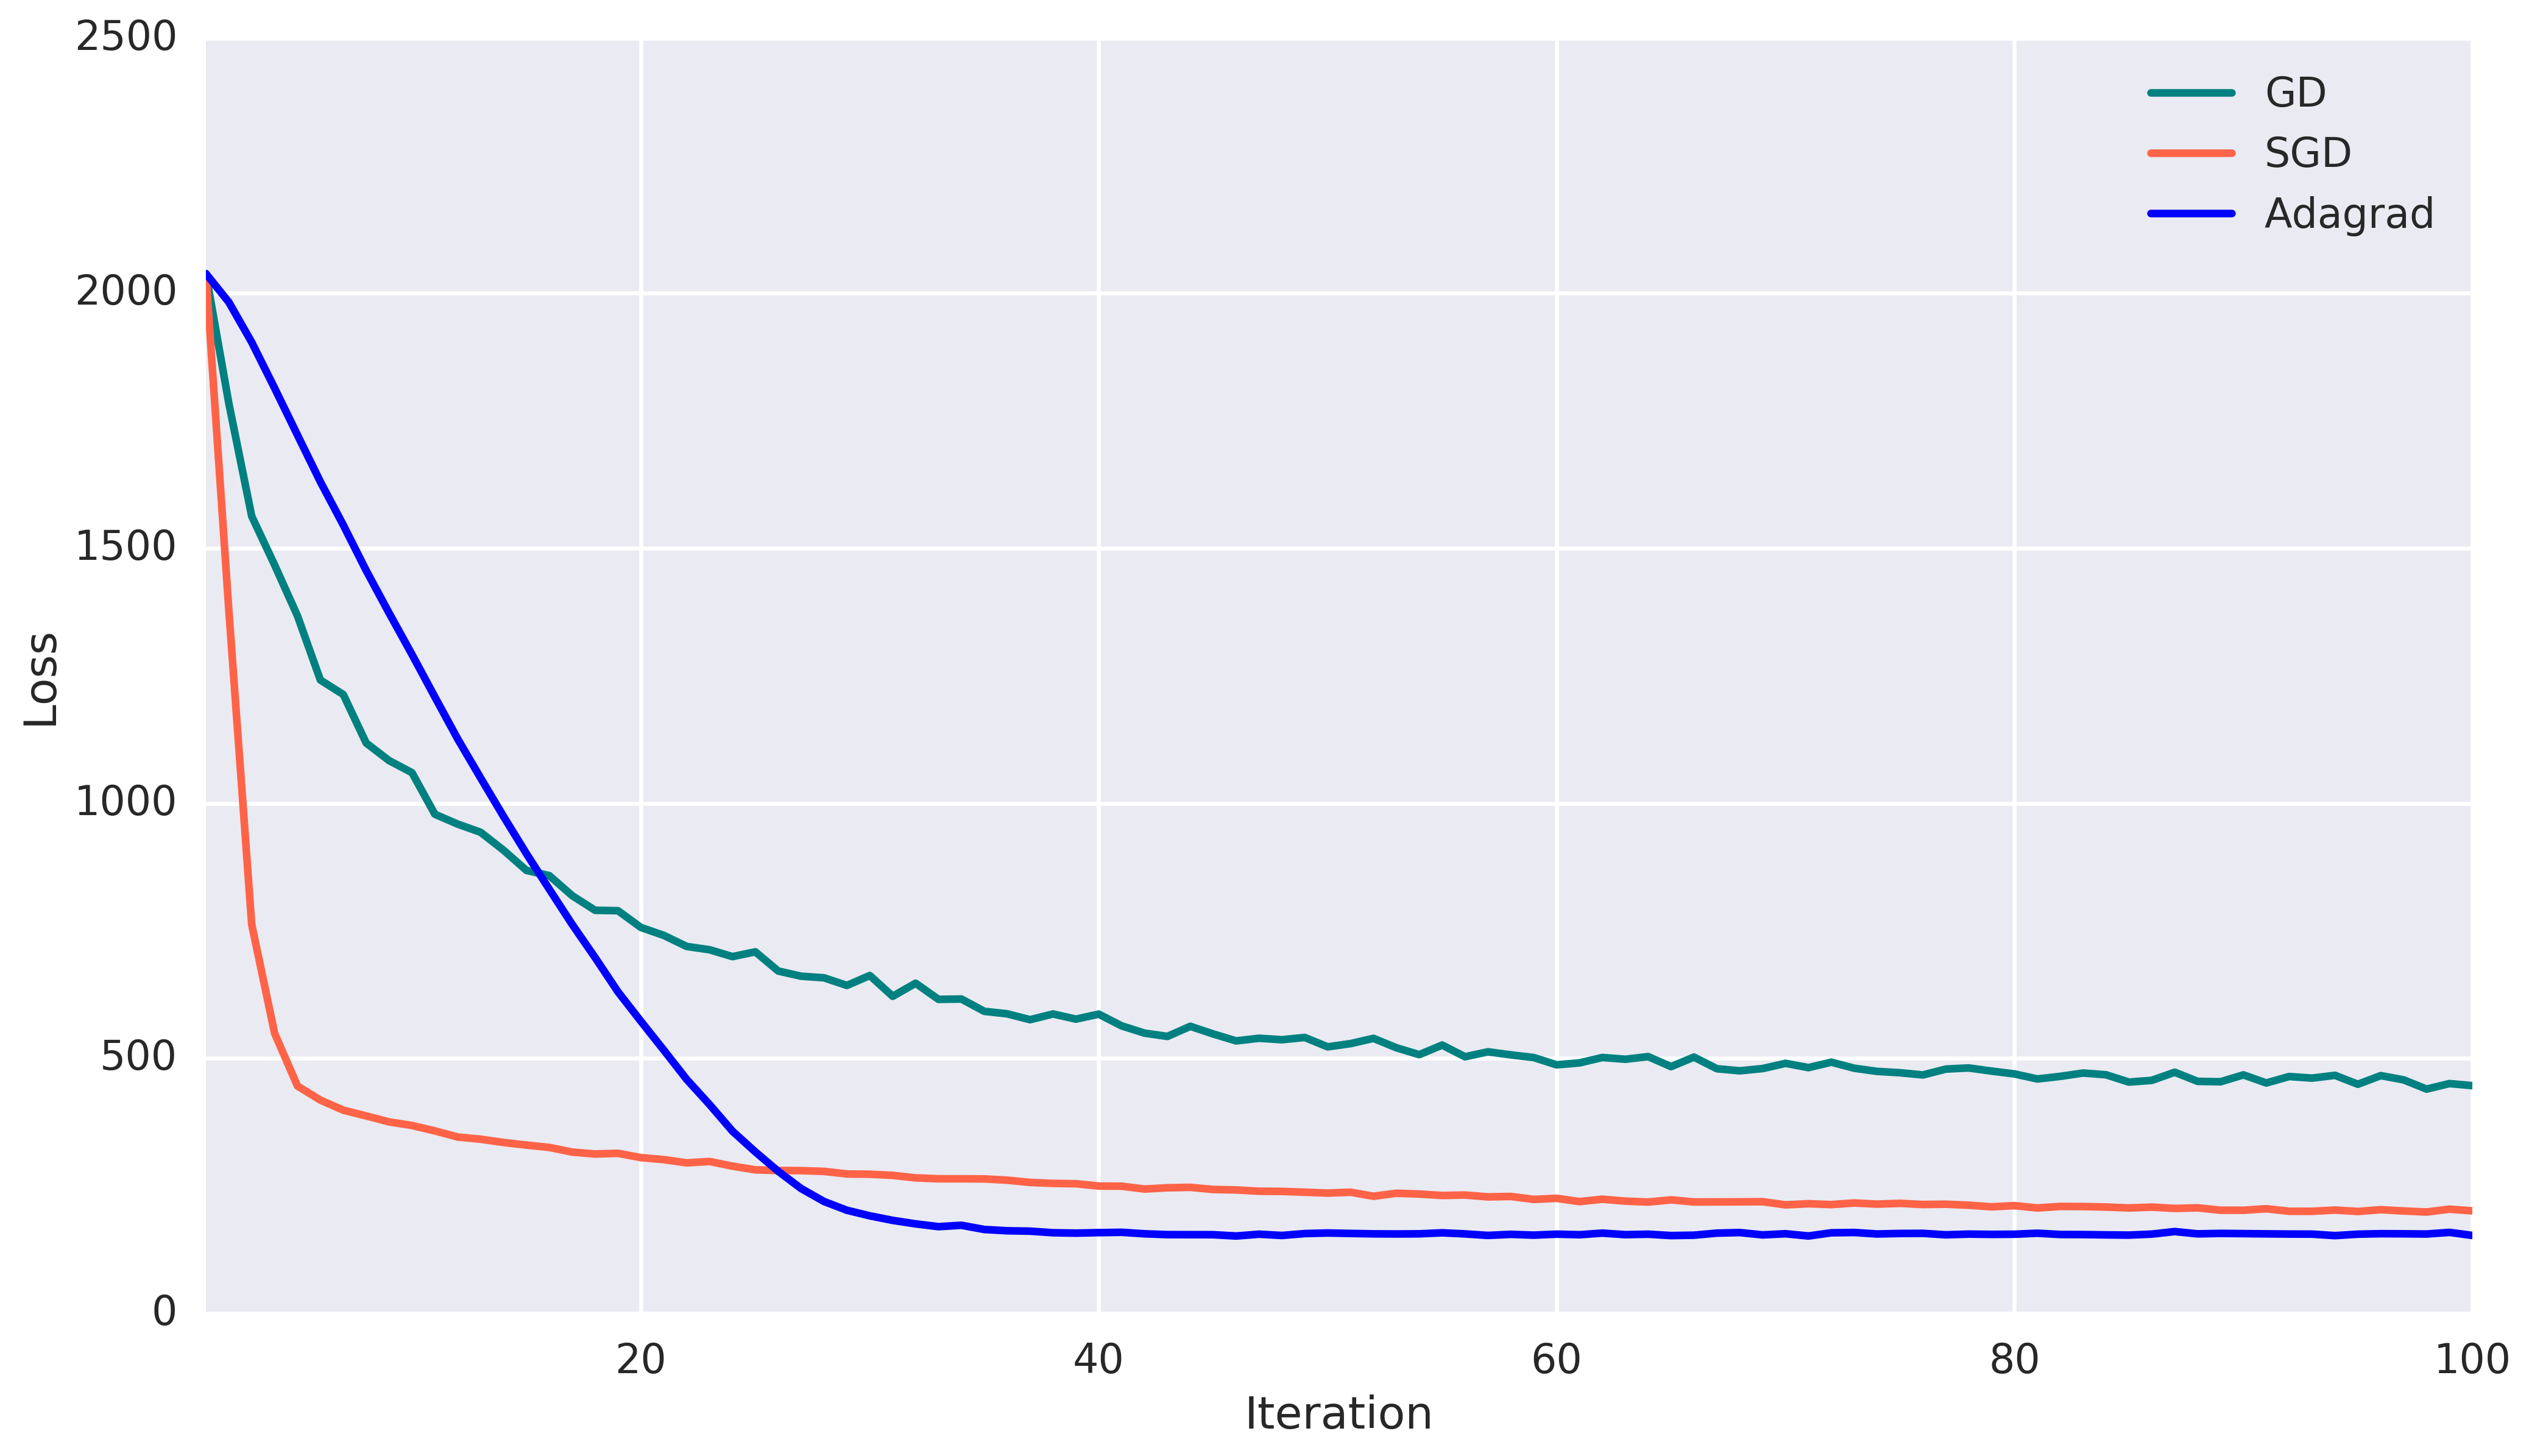

In [25]:
plt.figure(figsize = (16,9), dpi = 300)
plt.plot(np.arange(100)+1, list(map(lambda x: x[0]/8, l_list3)), color = 'teal', label ="GD", linewidth = 3)
plt.plot(np.arange(101)+1, [l_list3[0][0]/8]+list(map(lambda x: x[0]/8, l_list2)), color = 'tomato', label = "SGD", linewidth = 3)
plt.plot(np.arange(101)+1, [l_list3[0][0]/8]+list(map(lambda x: x[0]/8, l_list1)), color = 'blue', label = "Adagrad", linewidth = 3)
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.xlim([1, 100])
plt.show()

## Different initia

In [34]:
dode = MCDODE(nb, config)
dode.add_data(data_dict)
res_df = pd.DataFrame(index = range(100), columns = ['y_car', 'y_truck', 'x_car', 'x_truck', 'q_car', 'q_truck',
                                                   'c_car', 'c_truck'])
for i in range(100):
    dode = MCDODE(nb, config)
    dode.add_data(data_dict)
    (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 1, 
                                                             truck_step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)
    dta = dode._run_simulation(car_flow, truck_flow)
    estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_q = true_car_f.reshape(3, -1, order = 'F').sum(axis = 0)
    est_car_q = car_flow.reshape(3, -1, order = 'F').sum(axis = 0)
    true_truck_q = true_truck_f.reshape(3, -1, order = 'F').sum(axis = 0)
    est_truck_q = truck_flow.reshape(3, -1, order = 'F').sum(axis = 0)
    est_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    est_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    y_car = r2_score(m_car, L_car.dot(estimated_car_x))
    e_m_truck =L_truck.dot(estimated_truck_x)
    y_truck = r2_score(m_truck, e_m_truck)
#     truck_flow = true_truck_f + (np.random.rand(len(true_car_f)) * 2- 1) * np.random.rand() * 2
    x_car = r2_score(true_car_x, estimated_car_x)
    x_truck = r2_score(true_truck_x, estimated_truck_x)
    q_car =  r2_score(true_car_q, est_car_q)
    q_truck =  r2_score(true_truck_q, est_truck_q)
    c_car =  r2(true_car_tt, est_car_tt)
    c_truck =  r2(true_truck_tt, est_truck_tt)
    print [y_car, y_truck, x_car, x_truck, q_car, q_truck, c_car, c_truck]
    res_df.iloc[i] = [y_car, y_truck, x_car, x_truck, q_car, q_truck, c_car, c_truck]

Epoch: 0 Loss: 1988.61 truck_count_loss: 172.48|car_tt_loss: 18.98|car_count_loss: 1780.08|truck_tt_loss: 17.08|
Epoch: 1 Loss: 1910.9 truck_count_loss: 167.49|car_tt_loss: 18.98|car_count_loss: 1701.29|truck_tt_loss: 23.14|
Epoch: 2 Loss: 1849.81 truck_count_loss: 160.97|car_tt_loss: 18.98|car_count_loss: 1622.09|truck_tt_loss: 47.77|
Epoch: 3 Loss: 1759.44 truck_count_loss: 154.73|car_tt_loss: 18.98|car_count_loss: 1540.82|truck_tt_loss: 44.92|
Epoch: 4 Loss: 1668.99 truck_count_loss: 147.71|car_tt_loss: 18.98|car_count_loss: 1460.3|truck_tt_loss: 42.01|
Epoch: 5 Loss: 1573.04 truck_count_loss: 141.32|car_tt_loss: 18.98|car_count_loss: 1380.32|truck_tt_loss: 32.42|
Epoch: 6 Loss: 1487.16 truck_count_loss: 134.42|car_tt_loss: 18.91|car_count_loss: 1304.24|truck_tt_loss: 29.59|
Epoch: 7 Loss: 1400.67 truck_count_loss: 128.12|car_tt_loss: 19.77|car_count_loss: 1227.93|truck_tt_loss: 24.84|
Epoch: 8 Loss: 1316.06 truck_count_loss: 121.57|car_tt_loss: 19.61|car_count_loss: 1153.73|truck_t

Epoch: 74 Loss: 154.62 truck_count_loss: 12.91|car_tt_loss: 13.88|car_count_loss: 114.33|truck_tt_loss: 13.5|
Epoch: 75 Loss: 152.37 truck_count_loss: 12.68|car_tt_loss: 13.8|car_count_loss: 113.94|truck_tt_loss: 11.96|
Epoch: 76 Loss: 151.68 truck_count_loss: 13.16|car_tt_loss: 11.83|car_count_loss: 114.28|truck_tt_loss: 12.41|
Epoch: 77 Loss: 150.45 truck_count_loss: 12.05|car_tt_loss: 13.21|car_count_loss: 113.28|truck_tt_loss: 11.92|
Epoch: 78 Loss: 154.03 truck_count_loss: 12.31|car_tt_loss: 14.03|car_count_loss: 114.78|truck_tt_loss: 12.92|
Epoch: 79 Loss: 149.98 truck_count_loss: 11.72|car_tt_loss: 12.27|car_count_loss: 114.77|truck_tt_loss: 11.23|
Epoch: 80 Loss: 147.71 truck_count_loss: 12.7|car_tt_loss: 12.69|car_count_loss: 110.22|truck_tt_loss: 12.1|
Epoch: 81 Loss: 151.48 truck_count_loss: 12.2|car_tt_loss: 11.64|car_count_loss: 115.29|truck_tt_loss: 12.36|
Epoch: 82 Loss: 151.93 truck_count_loss: 12.39|car_tt_loss: 12.19|car_count_loss: 113.59|truck_tt_loss: 13.76|
Epoch:

Epoch: 47 Loss: 148.51 truck_count_loss: 12.13|car_tt_loss: 12.97|car_count_loss: 113.11|truck_tt_loss: 10.29|
Epoch: 48 Loss: 148.55 truck_count_loss: 12.0|car_tt_loss: 12.65|car_count_loss: 112.69|truck_tt_loss: 11.21|
Epoch: 49 Loss: 150.63 truck_count_loss: 12.37|car_tt_loss: 12.64|car_count_loss: 112.5|truck_tt_loss: 13.12|
Epoch: 50 Loss: 151.52 truck_count_loss: 12.63|car_tt_loss: 12.99|car_count_loss: 114.64|truck_tt_loss: 11.26|
Epoch: 51 Loss: 152.11 truck_count_loss: 12.25|car_tt_loss: 13.21|car_count_loss: 114.97|truck_tt_loss: 11.68|
Epoch: 52 Loss: 151.33 truck_count_loss: 12.31|car_tt_loss: 12.16|car_count_loss: 113.42|truck_tt_loss: 13.44|
Epoch: 53 Loss: 152.76 truck_count_loss: 12.82|car_tt_loss: 13.32|car_count_loss: 115.2|truck_tt_loss: 11.42|
Epoch: 54 Loss: 150.08 truck_count_loss: 12.84|car_tt_loss: 11.79|car_count_loss: 113.52|truck_tt_loss: 11.93|
Epoch: 55 Loss: 148.63 truck_count_loss: 11.83|car_tt_loss: 12.03|car_count_loss: 113.61|truck_tt_loss: 11.16|
Epoc

Epoch: 20 Loss: 458.17 truck_count_loss: 47.88|car_tt_loss: 16.91|car_count_loss: 378.24|truck_tt_loss: 15.14|
Epoch: 21 Loss: 405.39 truck_count_loss: 42.56|car_tt_loss: 16.42|car_count_loss: 332.37|truck_tt_loss: 14.04|
Epoch: 22 Loss: 354.52 truck_count_loss: 37.7|car_tt_loss: 14.92|car_count_loss: 288.22|truck_tt_loss: 13.68|
Epoch: 23 Loss: 311.38 truck_count_loss: 32.79|car_tt_loss: 14.84|car_count_loss: 250.95|truck_tt_loss: 12.79|
Epoch: 24 Loss: 275.59 truck_count_loss: 29.22|car_tt_loss: 13.6|car_count_loss: 219.07|truck_tt_loss: 13.7|
Epoch: 25 Loss: 235.72 truck_count_loss: 26.33|car_tt_loss: 13.68|car_count_loss: 184.1|truck_tt_loss: 11.61|
Epoch: 26 Loss: 212.65 truck_count_loss: 23.07|car_tt_loss: 11.2|car_count_loss: 167.27|truck_tt_loss: 11.11|
Epoch: 27 Loss: 197.51 truck_count_loss: 21.06|car_tt_loss: 14.39|car_count_loss: 149.7|truck_tt_loss: 12.36|
Epoch: 28 Loss: 186.09 truck_count_loss: 18.84|car_tt_loss: 12.69|car_count_loss: 143.06|truck_tt_loss: 11.49|
Epoch: 

Epoch: 95 Loss: 152.07 truck_count_loss: 12.48|car_tt_loss: 13.04|car_count_loss: 112.23|truck_tt_loss: 14.32|
Epoch: 96 Loss: 149.41 truck_count_loss: 12.44|car_tt_loss: 13.64|car_count_loss: 112.28|truck_tt_loss: 11.05|
Epoch: 97 Loss: 149.1 truck_count_loss: 12.84|car_tt_loss: 12.13|car_count_loss: 112.29|truck_tt_loss: 11.84|
Epoch: 98 Loss: 151.82 truck_count_loss: 12.43|car_tt_loss: 13.09|car_count_loss: 114.16|truck_tt_loss: 12.15|
Epoch: 99 Loss: 151.68 truck_count_loss: 12.55|car_tt_loss: 12.97|car_count_loss: 112.87|truck_tt_loss: 13.3|
[0.9986566194368641, 0.9894179194743989, 0.9961151891054014, 0.9776773344032836, 0.9970570742981286, 0.9873585445417269, 0.8974817980288372, 0.9365351668938309]
Epoch: 0 Loss: 1980.6 truck_count_loss: 172.94|car_tt_loss: 18.98|car_count_loss: 1772.33|truck_tt_loss: 16.35|
Epoch: 1 Loss: 1907.43 truck_count_loss: 167.61|car_tt_loss: 18.98|car_count_loss: 1690.24|truck_tt_loss: 30.61|
Epoch: 2 Loss: 1834.61 truck_count_loss: 161.34|car_tt_loss: 

Epoch: 68 Loss: 151.82 truck_count_loss: 11.93|car_tt_loss: 13.45|car_count_loss: 112.79|truck_tt_loss: 13.65|
Epoch: 69 Loss: 149.42 truck_count_loss: 12.04|car_tt_loss: 12.85|car_count_loss: 113.4|truck_tt_loss: 11.13|
Epoch: 70 Loss: 152.57 truck_count_loss: 12.48|car_tt_loss: 14.08|car_count_loss: 112.27|truck_tt_loss: 13.73|
Epoch: 71 Loss: 151.43 truck_count_loss: 12.05|car_tt_loss: 13.44|car_count_loss: 112.14|truck_tt_loss: 13.8|
Epoch: 72 Loss: 153.18 truck_count_loss: 12.73|car_tt_loss: 13.05|car_count_loss: 115.44|truck_tt_loss: 11.96|
Epoch: 73 Loss: 148.91 truck_count_loss: 12.27|car_tt_loss: 14.69|car_count_loss: 111.6|truck_tt_loss: 10.35|
Epoch: 74 Loss: 149.99 truck_count_loss: 12.33|car_tt_loss: 13.24|car_count_loss: 114.01|truck_tt_loss: 10.41|
Epoch: 75 Loss: 150.61 truck_count_loss: 12.53|car_tt_loss: 11.97|car_count_loss: 113.65|truck_tt_loss: 12.45|
Epoch: 76 Loss: 152.34 truck_count_loss: 12.63|car_tt_loss: 12.79|car_count_loss: 114.14|truck_tt_loss: 12.79|
Epoc

Epoch: 41 Loss: 153.57 truck_count_loss: 13.31|car_tt_loss: 14.32|car_count_loss: 114.23|truck_tt_loss: 11.72|
Epoch: 42 Loss: 152.83 truck_count_loss: 13.25|car_tt_loss: 12.12|car_count_loss: 115.51|truck_tt_loss: 11.96|
Epoch: 43 Loss: 154.17 truck_count_loss: 12.38|car_tt_loss: 12.74|car_count_loss: 117.49|truck_tt_loss: 11.56|
Epoch: 44 Loss: 153.91 truck_count_loss: 12.35|car_tt_loss: 13.33|car_count_loss: 114.37|truck_tt_loss: 13.87|
Epoch: 45 Loss: 150.75 truck_count_loss: 13.0|car_tt_loss: 12.74|car_count_loss: 114.21|truck_tt_loss: 10.8|
Epoch: 46 Loss: 150.47 truck_count_loss: 12.13|car_tt_loss: 12.49|car_count_loss: 114.67|truck_tt_loss: 11.19|
Epoch: 47 Loss: 153.64 truck_count_loss: 11.83|car_tt_loss: 12.8|car_count_loss: 115.45|truck_tt_loss: 13.55|
Epoch: 48 Loss: 151.92 truck_count_loss: 11.95|car_tt_loss: 14.3|car_count_loss: 114.03|truck_tt_loss: 11.65|
Epoch: 49 Loss: 150.21 truck_count_loss: 12.06|car_tt_loss: 13.32|car_count_loss: 114.1|truck_tt_loss: 10.73|
Epoch:

Epoch: 14 Loss: 843.44 truck_count_loss: 83.66|car_tt_loss: 15.43|car_count_loss: 728.06|truck_tt_loss: 16.29|
Epoch: 15 Loss: 779.11 truck_count_loss: 78.47|car_tt_loss: 16.81|car_count_loss: 667.23|truck_tt_loss: 16.62|
Epoch: 16 Loss: 715.32 truck_count_loss: 72.25|car_tt_loss: 14.97|car_count_loss: 612.37|truck_tt_loss: 15.73|
Epoch: 17 Loss: 649.71 truck_count_loss: 67.0|car_tt_loss: 14.86|car_count_loss: 551.66|truck_tt_loss: 16.18|
Epoch: 18 Loss: 586.07 truck_count_loss: 60.59|car_tt_loss: 15.62|car_count_loss: 494.53|truck_tt_loss: 15.34|
Epoch: 19 Loss: 529.96 truck_count_loss: 54.91|car_tt_loss: 16.43|car_count_loss: 443.17|truck_tt_loss: 15.46|
Epoch: 20 Loss: 469.61 truck_count_loss: 50.2|car_tt_loss: 14.99|car_count_loss: 388.88|truck_tt_loss: 15.54|
Epoch: 21 Loss: 421.16 truck_count_loss: 44.06|car_tt_loss: 16.33|car_count_loss: 346.25|truck_tt_loss: 14.51|
Epoch: 22 Loss: 367.28 truck_count_loss: 40.04|car_tt_loss: 14.71|car_count_loss: 298.79|truck_tt_loss: 13.74|
Epo

Epoch: 89 Loss: 149.76 truck_count_loss: 12.97|car_tt_loss: 11.46|car_count_loss: 113.49|truck_tt_loss: 11.83|
Epoch: 90 Loss: 153.36 truck_count_loss: 12.68|car_tt_loss: 13.26|car_count_loss: 115.18|truck_tt_loss: 12.24|
Epoch: 91 Loss: 152.48 truck_count_loss: 12.41|car_tt_loss: 12.88|car_count_loss: 114.07|truck_tt_loss: 13.12|
Epoch: 92 Loss: 150.68 truck_count_loss: 11.89|car_tt_loss: 12.33|car_count_loss: 111.5|truck_tt_loss: 14.96|
Epoch: 93 Loss: 148.16 truck_count_loss: 12.72|car_tt_loss: 12.4|car_count_loss: 111.29|truck_tt_loss: 11.75|
Epoch: 94 Loss: 152.9 truck_count_loss: 13.2|car_tt_loss: 13.92|car_count_loss: 115.12|truck_tt_loss: 10.66|
Epoch: 95 Loss: 154.76 truck_count_loss: 12.34|car_tt_loss: 12.99|car_count_loss: 115.25|truck_tt_loss: 14.18|
Epoch: 96 Loss: 148.86 truck_count_loss: 12.06|car_tt_loss: 13.61|car_count_loss: 111.76|truck_tt_loss: 11.43|
Epoch: 97 Loss: 153.39 truck_count_loss: 11.97|car_tt_loss: 13.22|car_count_loss: 115.77|truck_tt_loss: 12.43|
Epoch

Epoch: 62 Loss: 152.79 truck_count_loss: 12.58|car_tt_loss: 13.39|car_count_loss: 114.93|truck_tt_loss: 11.9|
Epoch: 63 Loss: 152.89 truck_count_loss: 12.73|car_tt_loss: 12.94|car_count_loss: 114.77|truck_tt_loss: 12.45|
Epoch: 64 Loss: 150.65 truck_count_loss: 12.34|car_tt_loss: 12.39|car_count_loss: 113.27|truck_tt_loss: 12.66|
Epoch: 65 Loss: 148.05 truck_count_loss: 12.7|car_tt_loss: 12.96|car_count_loss: 111.88|truck_tt_loss: 10.51|
Epoch: 66 Loss: 149.38 truck_count_loss: 12.27|car_tt_loss: 11.48|car_count_loss: 112.38|truck_tt_loss: 13.25|
Epoch: 67 Loss: 153.11 truck_count_loss: 11.93|car_tt_loss: 11.92|car_count_loss: 117.38|truck_tt_loss: 11.87|
Epoch: 68 Loss: 153.03 truck_count_loss: 12.73|car_tt_loss: 13.59|car_count_loss: 114.66|truck_tt_loss: 12.05|
Epoch: 69 Loss: 150.6 truck_count_loss: 12.65|car_tt_loss: 11.41|car_count_loss: 113.65|truck_tt_loss: 12.89|
Epoch: 70 Loss: 149.43 truck_count_loss: 12.52|car_tt_loss: 12.83|car_count_loss: 113.03|truck_tt_loss: 11.05|
Epoc

Epoch: 35 Loss: 160.93 truck_count_loss: 13.25|car_tt_loss: 11.89|car_count_loss: 123.62|truck_tt_loss: 12.17|
Epoch: 36 Loss: 158.5 truck_count_loss: 13.09|car_tt_loss: 12.92|car_count_loss: 121.74|truck_tt_loss: 10.75|
Epoch: 37 Loss: 158.34 truck_count_loss: 12.75|car_tt_loss: 13.61|car_count_loss: 121.24|truck_tt_loss: 10.74|
Epoch: 38 Loss: 154.62 truck_count_loss: 13.94|car_tt_loss: 11.86|car_count_loss: 118.67|truck_tt_loss: 10.16|
Epoch: 39 Loss: 154.56 truck_count_loss: 12.85|car_tt_loss: 12.87|car_count_loss: 117.36|truck_tt_loss: 11.49|
Epoch: 40 Loss: 153.7 truck_count_loss: 13.24|car_tt_loss: 12.58|car_count_loss: 115.72|truck_tt_loss: 12.17|
Epoch: 41 Loss: 153.48 truck_count_loss: 13.06|car_tt_loss: 14.28|car_count_loss: 115.15|truck_tt_loss: 10.99|
Epoch: 42 Loss: 152.51 truck_count_loss: 12.87|car_tt_loss: 13.67|car_count_loss: 114.44|truck_tt_loss: 11.53|
Epoch: 43 Loss: 152.27 truck_count_loss: 12.36|car_tt_loss: 12.14|car_count_loss: 116.2|truck_tt_loss: 11.58|
Epoc

Epoch: 8 Loss: 1291.03 truck_count_loss: 121.24|car_tt_loss: 17.73|car_count_loss: 1131.34|truck_tt_loss: 20.71|
Epoch: 9 Loss: 1206.21 truck_count_loss: 115.38|car_tt_loss: 17.06|car_count_loss: 1054.05|truck_tt_loss: 19.71|
Epoch: 10 Loss: 1129.45 truck_count_loss: 108.41|car_tt_loss: 17.16|car_count_loss: 983.91|truck_tt_loss: 19.97|
Epoch: 11 Loss: 1047.01 truck_count_loss: 102.25|car_tt_loss: 16.5|car_count_loss: 910.75|truck_tt_loss: 17.5|
Epoch: 12 Loss: 971.26 truck_count_loss: 96.31|car_tt_loss: 16.51|car_count_loss: 841.3|truck_tt_loss: 17.15|
Epoch: 13 Loss: 897.67 truck_count_loss: 89.57|car_tt_loss: 15.76|car_count_loss: 775.05|truck_tt_loss: 17.29|
Epoch: 14 Loss: 831.56 truck_count_loss: 83.56|car_tt_loss: 16.67|car_count_loss: 714.76|truck_tt_loss: 16.56|
Epoch: 15 Loss: 762.36 truck_count_loss: 76.99|car_tt_loss: 16.81|car_count_loss: 652.82|truck_tt_loss: 15.74|
Epoch: 16 Loss: 695.47 truck_count_loss: 71.38|car_tt_loss: 15.63|car_count_loss: 592.7|truck_tt_loss: 15.7

Epoch: 83 Loss: 151.68 truck_count_loss: 13.2|car_tt_loss: 14.14|car_count_loss: 112.86|truck_tt_loss: 11.48|
Epoch: 84 Loss: 153.06 truck_count_loss: 11.7|car_tt_loss: 13.69|car_count_loss: 113.27|truck_tt_loss: 14.4|
Epoch: 85 Loss: 149.81 truck_count_loss: 12.66|car_tt_loss: 12.52|car_count_loss: 113.17|truck_tt_loss: 11.46|
Epoch: 86 Loss: 148.47 truck_count_loss: 12.54|car_tt_loss: 12.94|car_count_loss: 112.03|truck_tt_loss: 10.95|
Epoch: 87 Loss: 152.25 truck_count_loss: 12.51|car_tt_loss: 12.1|car_count_loss: 114.66|truck_tt_loss: 12.98|
Epoch: 88 Loss: 150.25 truck_count_loss: 12.8|car_tt_loss: 14.69|car_count_loss: 110.88|truck_tt_loss: 11.88|
Epoch: 89 Loss: 148.4 truck_count_loss: 12.67|car_tt_loss: 12.51|car_count_loss: 112.19|truck_tt_loss: 11.03|
Epoch: 90 Loss: 149.41 truck_count_loss: 11.89|car_tt_loss: 12.23|car_count_loss: 112.18|truck_tt_loss: 13.12|
Epoch: 91 Loss: 150.26 truck_count_loss: 12.91|car_tt_loss: 13.45|car_count_loss: 112.35|truck_tt_loss: 11.54|
Epoch: 

Epoch: 56 Loss: 151.15 truck_count_loss: 12.45|car_tt_loss: 13.97|car_count_loss: 113.09|truck_tt_loss: 11.63|
Epoch: 57 Loss: 156.72 truck_count_loss: 12.73|car_tt_loss: 12.74|car_count_loss: 112.6|truck_tt_loss: 18.65|
Epoch: 58 Loss: 148.12 truck_count_loss: 12.95|car_tt_loss: 12.98|car_count_loss: 110.47|truck_tt_loss: 11.72|
Epoch: 59 Loss: 150.76 truck_count_loss: 12.31|car_tt_loss: 12.45|car_count_loss: 114.0|truck_tt_loss: 12.0|
Epoch: 60 Loss: 150.79 truck_count_loss: 13.44|car_tt_loss: 13.33|car_count_loss: 110.97|truck_tt_loss: 13.06|
Epoch: 61 Loss: 150.58 truck_count_loss: 13.16|car_tt_loss: 12.43|car_count_loss: 113.05|truck_tt_loss: 11.94|
Epoch: 62 Loss: 149.92 truck_count_loss: 12.17|car_tt_loss: 13.3|car_count_loss: 111.46|truck_tt_loss: 12.99|
Epoch: 63 Loss: 146.37 truck_count_loss: 12.55|car_tt_loss: 13.23|car_count_loss: 109.62|truck_tt_loss: 10.97|
Epoch: 64 Loss: 149.48 truck_count_loss: 12.6|car_tt_loss: 12.02|car_count_loss: 113.36|truck_tt_loss: 11.49|
Epoch:

Epoch: 29 Loss: 179.39 truck_count_loss: 17.82|car_tt_loss: 13.53|car_count_loss: 136.98|truck_tt_loss: 11.06|
Epoch: 30 Loss: 171.87 truck_count_loss: 16.13|car_tt_loss: 12.0|car_count_loss: 133.02|truck_tt_loss: 10.72|
Epoch: 31 Loss: 171.18 truck_count_loss: 15.75|car_tt_loss: 13.78|car_count_loss: 128.14|truck_tt_loss: 13.51|
Epoch: 32 Loss: 168.15 truck_count_loss: 14.29|car_tt_loss: 11.59|car_count_loss: 130.15|truck_tt_loss: 12.12|
Epoch: 33 Loss: 163.44 truck_count_loss: 14.57|car_tt_loss: 12.82|car_count_loss: 124.5|truck_tt_loss: 11.56|
Epoch: 34 Loss: 159.48 truck_count_loss: 13.72|car_tt_loss: 11.78|car_count_loss: 121.81|truck_tt_loss: 12.16|
Epoch: 35 Loss: 160.88 truck_count_loss: 13.23|car_tt_loss: 13.69|car_count_loss: 122.29|truck_tt_loss: 11.68|
Epoch: 36 Loss: 155.49 truck_count_loss: 13.62|car_tt_loss: 12.33|car_count_loss: 119.13|truck_tt_loss: 10.41|
Epoch: 37 Loss: 153.75 truck_count_loss: 13.39|car_tt_loss: 12.64|car_count_loss: 116.81|truck_tt_loss: 10.9|
Epoc

Epoch: 2 Loss: 1846.88 truck_count_loss: 161.47|car_tt_loss: 18.98|car_count_loss: 1616.31|truck_tt_loss: 50.13|
Epoch: 3 Loss: 1745.17 truck_count_loss: 154.62|car_tt_loss: 18.98|car_count_loss: 1534.7|truck_tt_loss: 36.88|
Epoch: 4 Loss: 1658.84 truck_count_loss: 147.99|car_tt_loss: 18.98|car_count_loss: 1454.2|truck_tt_loss: 37.68|
Epoch: 5 Loss: 1564.41 truck_count_loss: 141.84|car_tt_loss: 18.98|car_count_loss: 1376.81|truck_tt_loss: 26.78|
Epoch: 6 Loss: 1478.79 truck_count_loss: 134.93|car_tt_loss: 19.14|car_count_loss: 1298.21|truck_tt_loss: 26.51|
Epoch: 7 Loss: 1393.57 truck_count_loss: 128.14|car_tt_loss: 19.93|car_count_loss: 1221.88|truck_tt_loss: 23.62|
Epoch: 8 Loss: 1310.64 truck_count_loss: 121.92|car_tt_loss: 18.47|car_count_loss: 1148.22|truck_tt_loss: 22.03|
Epoch: 9 Loss: 1226.62 truck_count_loss: 115.25|car_tt_loss: 18.1|car_count_loss: 1073.12|truck_tt_loss: 20.15|
Epoch: 10 Loss: 1144.2 truck_count_loss: 109.29|car_tt_loss: 17.49|car_count_loss: 999.5|truck_tt_l

Epoch: 76 Loss: 148.99 truck_count_loss: 12.49|car_tt_loss: 12.79|car_count_loss: 111.4|truck_tt_loss: 12.31|
Epoch: 77 Loss: 150.46 truck_count_loss: 12.4|car_tt_loss: 12.06|car_count_loss: 113.17|truck_tt_loss: 12.82|
Epoch: 78 Loss: 151.79 truck_count_loss: 12.38|car_tt_loss: 13.88|car_count_loss: 113.11|truck_tt_loss: 12.43|
Epoch: 79 Loss: 153.69 truck_count_loss: 12.88|car_tt_loss: 14.08|car_count_loss: 113.45|truck_tt_loss: 13.28|
Epoch: 80 Loss: 155.83 truck_count_loss: 12.74|car_tt_loss: 13.86|car_count_loss: 115.59|truck_tt_loss: 13.65|
Epoch: 81 Loss: 149.1 truck_count_loss: 12.46|car_tt_loss: 12.45|car_count_loss: 112.45|truck_tt_loss: 11.74|
Epoch: 82 Loss: 149.82 truck_count_loss: 12.59|car_tt_loss: 12.69|car_count_loss: 112.48|truck_tt_loss: 12.06|
Epoch: 83 Loss: 149.87 truck_count_loss: 12.51|car_tt_loss: 13.43|car_count_loss: 112.11|truck_tt_loss: 11.81|
Epoch: 84 Loss: 149.84 truck_count_loss: 12.82|car_tt_loss: 13.09|car_count_loss: 112.73|truck_tt_loss: 11.2|
Epoch

Epoch: 49 Loss: 152.25 truck_count_loss: 12.56|car_tt_loss: 13.25|car_count_loss: 114.36|truck_tt_loss: 12.08|
Epoch: 50 Loss: 149.21 truck_count_loss: 12.48|car_tt_loss: 11.4|car_count_loss: 113.58|truck_tt_loss: 11.74|
Epoch: 51 Loss: 150.17 truck_count_loss: 12.57|car_tt_loss: 13.09|car_count_loss: 113.28|truck_tt_loss: 11.24|
Epoch: 52 Loss: 150.05 truck_count_loss: 12.42|car_tt_loss: 12.93|car_count_loss: 113.15|truck_tt_loss: 11.55|
Epoch: 53 Loss: 151.47 truck_count_loss: 12.31|car_tt_loss: 12.33|car_count_loss: 114.96|truck_tt_loss: 11.86|
Epoch: 54 Loss: 150.74 truck_count_loss: 12.37|car_tt_loss: 12.03|car_count_loss: 113.45|truck_tt_loss: 12.89|
Epoch: 55 Loss: 151.79 truck_count_loss: 12.74|car_tt_loss: 13.27|car_count_loss: 114.52|truck_tt_loss: 11.27|
Epoch: 56 Loss: 151.29 truck_count_loss: 12.63|car_tt_loss: 13.4|car_count_loss: 113.91|truck_tt_loss: 11.34|
Epoch: 57 Loss: 151.11 truck_count_loss: 12.32|car_tt_loss: 13.05|car_count_loss: 114.05|truck_tt_loss: 11.68|
Epo

Epoch: 22 Loss: 356.44 truck_count_loss: 37.72|car_tt_loss: 15.35|car_count_loss: 289.45|truck_tt_loss: 13.92|
Epoch: 23 Loss: 311.7 truck_count_loss: 33.18|car_tt_loss: 14.99|car_count_loss: 250.46|truck_tt_loss: 13.07|
Epoch: 24 Loss: 273.35 truck_count_loss: 29.25|car_tt_loss: 14.47|car_count_loss: 216.72|truck_tt_loss: 12.91|
Epoch: 25 Loss: 237.55 truck_count_loss: 26.4|car_tt_loss: 13.85|car_count_loss: 183.37|truck_tt_loss: 13.92|
Epoch: 26 Loss: 217.18 truck_count_loss: 23.56|car_tt_loss: 14.74|car_count_loss: 166.51|truck_tt_loss: 12.37|
Epoch: 27 Loss: 196.05 truck_count_loss: 21.3|car_tt_loss: 14.46|car_count_loss: 148.27|truck_tt_loss: 12.02|
Epoch: 28 Loss: 188.44 truck_count_loss: 19.49|car_tt_loss: 13.28|car_count_loss: 143.92|truck_tt_loss: 11.75|
Epoch: 29 Loss: 178.5 truck_count_loss: 17.62|car_tt_loss: 12.71|car_count_loss: 136.38|truck_tt_loss: 11.78|
Epoch: 30 Loss: 172.53 truck_count_loss: 16.15|car_tt_loss: 13.19|car_count_loss: 131.21|truck_tt_loss: 11.98|
Epoch

Epoch: 97 Loss: 151.1 truck_count_loss: 13.0|car_tt_loss: 13.45|car_count_loss: 113.93|truck_tt_loss: 10.73|
Epoch: 98 Loss: 153.42 truck_count_loss: 12.69|car_tt_loss: 14.56|car_count_loss: 112.66|truck_tt_loss: 13.51|
Epoch: 99 Loss: 149.76 truck_count_loss: 12.4|car_tt_loss: 12.61|car_count_loss: 112.8|truck_tt_loss: 11.95|
[0.997942580916892, 0.9806006206479452, 0.9957009246620524, 0.9689710514707008, 0.996847533823285, 0.9853423425935405, 0.9605908526233995, 0.9630675926367446]
Epoch: 0 Loss: 1982.19 truck_count_loss: 172.39|car_tt_loss: 18.98|car_count_loss: 1770.1|truck_tt_loss: 20.72|
Epoch: 1 Loss: 1926.77 truck_count_loss: 166.76|car_tt_loss: 18.98|car_count_loss: 1694.52|truck_tt_loss: 46.51|
Epoch: 2 Loss: 1849.66 truck_count_loss: 160.64|car_tt_loss: 18.98|car_count_loss: 1618.41|truck_tt_loss: 51.63|
Epoch: 3 Loss: 1752.6 truck_count_loss: 154.51|car_tt_loss: 18.98|car_count_loss: 1543.12|truck_tt_loss: 35.99|
Epoch: 4 Loss: 1704.23 truck_count_loss: 148.25|car_tt_loss: 1

Epoch: 70 Loss: 152.29 truck_count_loss: 12.0|car_tt_loss: 13.55|car_count_loss: 115.51|truck_tt_loss: 11.22|
Epoch: 71 Loss: 150.57 truck_count_loss: 12.09|car_tt_loss: 13.27|car_count_loss: 114.34|truck_tt_loss: 10.87|
Epoch: 72 Loss: 149.99 truck_count_loss: 11.74|car_tt_loss: 13.33|car_count_loss: 113.87|truck_tt_loss: 11.06|
Epoch: 73 Loss: 148.79 truck_count_loss: 12.51|car_tt_loss: 12.27|car_count_loss: 113.31|truck_tt_loss: 10.7|
Epoch: 74 Loss: 155.87 truck_count_loss: 12.83|car_tt_loss: 13.32|car_count_loss: 115.82|truck_tt_loss: 13.91|
Epoch: 75 Loss: 150.09 truck_count_loss: 12.36|car_tt_loss: 12.66|car_count_loss: 111.46|truck_tt_loss: 13.61|
Epoch: 76 Loss: 151.71 truck_count_loss: 12.33|car_tt_loss: 14.32|car_count_loss: 113.25|truck_tt_loss: 11.81|
Epoch: 77 Loss: 150.54 truck_count_loss: 12.22|car_tt_loss: 14.24|car_count_loss: 112.85|truck_tt_loss: 11.23|
Epoch: 78 Loss: 150.46 truck_count_loss: 12.3|car_tt_loss: 14.26|car_count_loss: 112.85|truck_tt_loss: 11.05|
Epoc

Epoch: 43 Loss: 155.3 truck_count_loss: 12.38|car_tt_loss: 14.06|car_count_loss: 116.23|truck_tt_loss: 12.63|
Epoch: 44 Loss: 154.66 truck_count_loss: 13.34|car_tt_loss: 13.58|car_count_loss: 115.9|truck_tt_loss: 11.84|
Epoch: 45 Loss: 153.46 truck_count_loss: 12.93|car_tt_loss: 13.01|car_count_loss: 114.5|truck_tt_loss: 13.02|
Epoch: 46 Loss: 155.25 truck_count_loss: 12.38|car_tt_loss: 13.76|car_count_loss: 115.73|truck_tt_loss: 13.39|
Epoch: 47 Loss: 152.38 truck_count_loss: 12.32|car_tt_loss: 11.92|car_count_loss: 116.54|truck_tt_loss: 11.6|
Epoch: 48 Loss: 154.75 truck_count_loss: 12.13|car_tt_loss: 14.33|car_count_loss: 116.44|truck_tt_loss: 11.84|
Epoch: 49 Loss: 152.16 truck_count_loss: 12.28|car_tt_loss: 11.9|car_count_loss: 116.95|truck_tt_loss: 11.02|
Epoch: 50 Loss: 156.11 truck_count_loss: 12.82|car_tt_loss: 12.82|car_count_loss: 117.45|truck_tt_loss: 13.02|
Epoch: 51 Loss: 150.89 truck_count_loss: 12.97|car_tt_loss: 12.72|car_count_loss: 113.23|truck_tt_loss: 11.97|
Epoch:

Epoch: 16 Loss: 697.36 truck_count_loss: 71.18|car_tt_loss: 15.21|car_count_loss: 595.62|truck_tt_loss: 15.35|
Epoch: 17 Loss: 633.28 truck_count_loss: 64.6|car_tt_loss: 14.88|car_count_loss: 538.2|truck_tt_loss: 15.6|
Epoch: 18 Loss: 570.17 truck_count_loss: 58.9|car_tt_loss: 16.24|car_count_loss: 480.01|truck_tt_loss: 15.02|
Epoch: 19 Loss: 516.74 truck_count_loss: 53.51|car_tt_loss: 15.32|car_count_loss: 432.85|truck_tt_loss: 15.06|
Epoch: 20 Loss: 467.13 truck_count_loss: 48.15|car_tt_loss: 17.5|car_count_loss: 386.25|truck_tt_loss: 15.23|
Epoch: 21 Loss: 406.63 truck_count_loss: 43.12|car_tt_loss: 15.58|car_count_loss: 334.26|truck_tt_loss: 13.66|
Epoch: 22 Loss: 362.85 truck_count_loss: 37.79|car_tt_loss: 14.15|car_count_loss: 296.63|truck_tt_loss: 14.27|
Epoch: 23 Loss: 320.44 truck_count_loss: 34.35|car_tt_loss: 14.49|car_count_loss: 257.98|truck_tt_loss: 13.62|
Epoch: 24 Loss: 278.0 truck_count_loss: 30.16|car_tt_loss: 14.94|car_count_loss: 219.77|truck_tt_loss: 13.13|
Epoch: 

Epoch: 91 Loss: 152.5 truck_count_loss: 12.99|car_tt_loss: 11.91|car_count_loss: 114.98|truck_tt_loss: 12.61|
Epoch: 92 Loss: 152.19 truck_count_loss: 12.9|car_tt_loss: 13.33|car_count_loss: 113.3|truck_tt_loss: 12.67|
Epoch: 93 Loss: 147.29 truck_count_loss: 12.37|car_tt_loss: 13.85|car_count_loss: 110.6|truck_tt_loss: 10.47|
Epoch: 94 Loss: 152.44 truck_count_loss: 12.59|car_tt_loss: 12.57|car_count_loss: 115.61|truck_tt_loss: 11.67|
Epoch: 95 Loss: 150.55 truck_count_loss: 12.65|car_tt_loss: 12.12|car_count_loss: 114.62|truck_tt_loss: 11.15|
Epoch: 96 Loss: 152.22 truck_count_loss: 12.31|car_tt_loss: 13.07|car_count_loss: 113.69|truck_tt_loss: 13.15|
Epoch: 97 Loss: 150.93 truck_count_loss: 12.56|car_tt_loss: 13.41|car_count_loss: 113.05|truck_tt_loss: 11.91|
Epoch: 98 Loss: 147.03 truck_count_loss: 12.18|car_tt_loss: 12.83|car_count_loss: 108.83|truck_tt_loss: 13.19|
Epoch: 99 Loss: 148.3 truck_count_loss: 13.08|car_tt_loss: 12.15|car_count_loss: 111.43|truck_tt_loss: 11.64|
[0.998

Epoch: 64 Loss: 154.28 truck_count_loss: 12.86|car_tt_loss: 13.45|car_count_loss: 115.6|truck_tt_loss: 12.36|
Epoch: 65 Loss: 149.87 truck_count_loss: 12.11|car_tt_loss: 12.15|car_count_loss: 114.51|truck_tt_loss: 11.1|
Epoch: 66 Loss: 151.69 truck_count_loss: 12.27|car_tt_loss: 14.54|car_count_loss: 112.78|truck_tt_loss: 12.1|
Epoch: 67 Loss: 149.91 truck_count_loss: 13.55|car_tt_loss: 13.16|car_count_loss: 112.94|truck_tt_loss: 10.26|
Epoch: 68 Loss: 149.88 truck_count_loss: 12.37|car_tt_loss: 12.51|car_count_loss: 113.96|truck_tt_loss: 11.05|
Epoch: 69 Loss: 153.6 truck_count_loss: 12.38|car_tt_loss: 14.04|car_count_loss: 115.79|truck_tt_loss: 11.39|
Epoch: 70 Loss: 150.52 truck_count_loss: 12.45|car_tt_loss: 13.88|car_count_loss: 112.72|truck_tt_loss: 11.47|
Epoch: 71 Loss: 150.03 truck_count_loss: 12.47|car_tt_loss: 12.54|car_count_loss: 113.24|truck_tt_loss: 11.77|
Epoch: 72 Loss: 151.9 truck_count_loss: 12.25|car_tt_loss: 13.02|car_count_loss: 113.92|truck_tt_loss: 12.72|
Epoch:

Epoch: 37 Loss: 158.78 truck_count_loss: 13.07|car_tt_loss: 13.56|car_count_loss: 120.35|truck_tt_loss: 11.79|
Epoch: 38 Loss: 155.12 truck_count_loss: 13.31|car_tt_loss: 12.14|car_count_loss: 117.85|truck_tt_loss: 11.82|
Epoch: 39 Loss: 153.55 truck_count_loss: 13.16|car_tt_loss: 11.59|car_count_loss: 117.23|truck_tt_loss: 11.57|
Epoch: 40 Loss: 154.38 truck_count_loss: 13.08|car_tt_loss: 12.29|car_count_loss: 117.34|truck_tt_loss: 11.67|
Epoch: 41 Loss: 154.93 truck_count_loss: 13.26|car_tt_loss: 13.08|car_count_loss: 117.31|truck_tt_loss: 11.29|
Epoch: 42 Loss: 155.69 truck_count_loss: 13.29|car_tt_loss: 14.14|car_count_loss: 116.49|truck_tt_loss: 11.77|
Epoch: 43 Loss: 154.6 truck_count_loss: 13.13|car_tt_loss: 11.76|car_count_loss: 118.14|truck_tt_loss: 11.57|
Epoch: 44 Loss: 151.5 truck_count_loss: 13.15|car_tt_loss: 12.72|car_count_loss: 113.95|truck_tt_loss: 11.67|
Epoch: 45 Loss: 151.36 truck_count_loss: 12.44|car_tt_loss: 12.26|car_count_loss: 114.09|truck_tt_loss: 12.57|
Epo

Epoch: 10 Loss: 1136.45 truck_count_loss: 108.72|car_tt_loss: 18.0|car_count_loss: 990.2|truck_tt_loss: 19.53|
Epoch: 11 Loss: 1052.89 truck_count_loss: 101.68|car_tt_loss: 17.14|car_count_loss: 916.12|truck_tt_loss: 17.95|
Epoch: 12 Loss: 979.52 truck_count_loss: 95.82|car_tt_loss: 15.94|car_count_loss: 850.32|truck_tt_loss: 17.44|
Epoch: 13 Loss: 907.1 truck_count_loss: 88.91|car_tt_loss: 15.71|car_count_loss: 785.43|truck_tt_loss: 17.05|
Epoch: 14 Loss: 833.84 truck_count_loss: 82.98|car_tt_loss: 17.63|car_count_loss: 716.82|truck_tt_loss: 16.41|
Epoch: 15 Loss: 769.23 truck_count_loss: 76.48|car_tt_loss: 16.13|car_count_loss: 660.24|truck_tt_loss: 16.38|
Epoch: 16 Loss: 702.03 truck_count_loss: 71.4|car_tt_loss: 16.65|car_count_loss: 598.21|truck_tt_loss: 15.77|
Epoch: 17 Loss: 634.52 truck_count_loss: 65.21|car_tt_loss: 15.4|car_count_loss: 538.85|truck_tt_loss: 15.06|
Epoch: 18 Loss: 572.19 truck_count_loss: 59.29|car_tt_loss: 14.94|car_count_loss: 483.04|truck_tt_loss: 14.91|
Ep

Epoch: 85 Loss: 151.54 truck_count_loss: 12.12|car_tt_loss: 12.42|car_count_loss: 114.38|truck_tt_loss: 12.62|
Epoch: 86 Loss: 151.71 truck_count_loss: 12.67|car_tt_loss: 13.16|car_count_loss: 113.45|truck_tt_loss: 12.43|
Epoch: 87 Loss: 153.73 truck_count_loss: 12.97|car_tt_loss: 13.57|car_count_loss: 113.33|truck_tt_loss: 13.86|
Epoch: 88 Loss: 154.39 truck_count_loss: 12.64|car_tt_loss: 13.98|car_count_loss: 113.55|truck_tt_loss: 14.22|
Epoch: 89 Loss: 153.44 truck_count_loss: 12.72|car_tt_loss: 14.08|car_count_loss: 115.1|truck_tt_loss: 11.55|
Epoch: 90 Loss: 150.32 truck_count_loss: 12.02|car_tt_loss: 12.73|car_count_loss: 113.68|truck_tt_loss: 11.9|
Epoch: 91 Loss: 150.69 truck_count_loss: 13.25|car_tt_loss: 13.34|car_count_loss: 112.62|truck_tt_loss: 11.49|
Epoch: 92 Loss: 150.46 truck_count_loss: 12.54|car_tt_loss: 13.2|car_count_loss: 113.81|truck_tt_loss: 10.91|
Epoch: 93 Loss: 147.11 truck_count_loss: 12.79|car_tt_loss: 12.78|car_count_loss: 110.27|truck_tt_loss: 11.26|
Epoc

Epoch: 58 Loss: 147.78 truck_count_loss: 12.34|car_tt_loss: 11.84|car_count_loss: 109.91|truck_tt_loss: 13.69|
Epoch: 59 Loss: 150.92 truck_count_loss: 11.64|car_tt_loss: 13.69|car_count_loss: 113.68|truck_tt_loss: 11.91|
Epoch: 60 Loss: 147.49 truck_count_loss: 12.95|car_tt_loss: 12.12|car_count_loss: 111.37|truck_tt_loss: 11.05|
Epoch: 61 Loss: 151.35 truck_count_loss: 12.41|car_tt_loss: 13.86|car_count_loss: 112.99|truck_tt_loss: 12.09|
Epoch: 62 Loss: 148.26 truck_count_loss: 12.89|car_tt_loss: 12.12|car_count_loss: 112.47|truck_tt_loss: 10.78|
Epoch: 63 Loss: 152.89 truck_count_loss: 13.36|car_tt_loss: 14.73|car_count_loss: 111.47|truck_tt_loss: 13.34|
Epoch: 64 Loss: 151.94 truck_count_loss: 12.25|car_tt_loss: 12.57|car_count_loss: 114.86|truck_tt_loss: 12.25|
Epoch: 65 Loss: 151.92 truck_count_loss: 12.4|car_tt_loss: 12.93|car_count_loss: 113.41|truck_tt_loss: 13.18|
Epoch: 66 Loss: 151.1 truck_count_loss: 12.35|car_tt_loss: 12.83|car_count_loss: 112.43|truck_tt_loss: 13.49|
Epo

Epoch: 31 Loss: 169.01 truck_count_loss: 15.41|car_tt_loss: 14.5|car_count_loss: 127.13|truck_tt_loss: 11.97|
Epoch: 32 Loss: 169.35 truck_count_loss: 14.67|car_tt_loss: 13.82|car_count_loss: 128.51|truck_tt_loss: 12.36|
Epoch: 33 Loss: 163.46 truck_count_loss: 14.61|car_tt_loss: 12.15|car_count_loss: 126.08|truck_tt_loss: 10.63|
Epoch: 34 Loss: 162.42 truck_count_loss: 14.0|car_tt_loss: 13.28|car_count_loss: 123.51|truck_tt_loss: 11.63|
Epoch: 35 Loss: 157.96 truck_count_loss: 13.28|car_tt_loss: 13.79|car_count_loss: 119.42|truck_tt_loss: 11.47|
Epoch: 36 Loss: 156.47 truck_count_loss: 13.19|car_tt_loss: 12.57|car_count_loss: 119.7|truck_tt_loss: 11.02|
Epoch: 37 Loss: 157.24 truck_count_loss: 13.82|car_tt_loss: 13.02|car_count_loss: 117.76|truck_tt_loss: 12.64|
Epoch: 38 Loss: 157.28 truck_count_loss: 12.86|car_tt_loss: 14.63|car_count_loss: 118.4|truck_tt_loss: 11.38|
Epoch: 39 Loss: 158.57 truck_count_loss: 13.35|car_tt_loss: 12.38|car_count_loss: 122.0|truck_tt_loss: 10.85|
Epoch:

Epoch: 4 Loss: 1640.19 truck_count_loss: 147.9|car_tt_loss: 18.98|car_count_loss: 1438.1|truck_tt_loss: 35.21|
Epoch: 5 Loss: 1552.93 truck_count_loss: 141.6|car_tt_loss: 19.32|car_count_loss: 1358.58|truck_tt_loss: 33.43|
Epoch: 6 Loss: 1462.72 truck_count_loss: 134.96|car_tt_loss: 19.06|car_count_loss: 1281.18|truck_tt_loss: 27.52|
Epoch: 7 Loss: 1378.48 truck_count_loss: 128.56|car_tt_loss: 19.25|car_count_loss: 1204.4|truck_tt_loss: 26.27|
Epoch: 8 Loss: 1287.98 truck_count_loss: 121.68|car_tt_loss: 18.11|car_count_loss: 1126.23|truck_tt_loss: 21.96|
Epoch: 9 Loss: 1207.86 truck_count_loss: 115.7|car_tt_loss: 17.85|car_count_loss: 1054.78|truck_tt_loss: 19.54|
Epoch: 10 Loss: 1129.96 truck_count_loss: 109.09|car_tt_loss: 16.56|car_count_loss: 985.06|truck_tt_loss: 19.26|
Epoch: 11 Loss: 1049.47 truck_count_loss: 103.03|car_tt_loss: 17.21|car_count_loss: 911.76|truck_tt_loss: 17.48|
Epoch: 12 Loss: 977.6 truck_count_loss: 96.78|car_tt_loss: 17.48|car_count_loss: 846.31|truck_tt_loss

Epoch: 79 Loss: 152.8 truck_count_loss: 12.48|car_tt_loss: 12.7|car_count_loss: 114.1|truck_tt_loss: 13.53|
Epoch: 80 Loss: 151.14 truck_count_loss: 12.61|car_tt_loss: 13.2|car_count_loss: 114.49|truck_tt_loss: 10.84|
Epoch: 81 Loss: 152.87 truck_count_loss: 12.87|car_tt_loss: 13.38|car_count_loss: 113.09|truck_tt_loss: 13.53|
Epoch: 82 Loss: 152.87 truck_count_loss: 12.12|car_tt_loss: 12.57|car_count_loss: 113.48|truck_tt_loss: 14.7|
Epoch: 83 Loss: 149.0 truck_count_loss: 12.46|car_tt_loss: 12.33|car_count_loss: 113.36|truck_tt_loss: 10.85|
Epoch: 84 Loss: 150.45 truck_count_loss: 13.11|car_tt_loss: 12.73|car_count_loss: 112.79|truck_tt_loss: 11.81|
Epoch: 85 Loss: 155.07 truck_count_loss: 12.52|car_tt_loss: 13.84|car_count_loss: 116.03|truck_tt_loss: 12.67|
Epoch: 86 Loss: 150.98 truck_count_loss: 12.85|car_tt_loss: 13.57|car_count_loss: 113.49|truck_tt_loss: 11.07|
Epoch: 87 Loss: 148.19 truck_count_loss: 12.25|car_tt_loss: 13.19|car_count_loss: 111.04|truck_tt_loss: 11.7|
Epoch: 8

Epoch: 52 Loss: 152.51 truck_count_loss: 12.45|car_tt_loss: 13.95|car_count_loss: 114.17|truck_tt_loss: 11.95|
Epoch: 53 Loss: 152.65 truck_count_loss: 12.03|car_tt_loss: 12.35|car_count_loss: 115.95|truck_tt_loss: 12.31|
Epoch: 54 Loss: 149.18 truck_count_loss: 12.34|car_tt_loss: 12.11|car_count_loss: 113.92|truck_tt_loss: 10.82|
Epoch: 55 Loss: 153.91 truck_count_loss: 12.99|car_tt_loss: 14.44|car_count_loss: 115.01|truck_tt_loss: 11.48|
Epoch: 56 Loss: 149.84 truck_count_loss: 12.82|car_tt_loss: 13.78|car_count_loss: 112.4|truck_tt_loss: 10.84|
Epoch: 57 Loss: 151.09 truck_count_loss: 12.51|car_tt_loss: 14.06|car_count_loss: 113.14|truck_tt_loss: 11.38|
Epoch: 58 Loss: 152.05 truck_count_loss: 12.48|car_tt_loss: 13.1|car_count_loss: 113.52|truck_tt_loss: 12.95|
Epoch: 59 Loss: 152.31 truck_count_loss: 12.87|car_tt_loss: 14.07|car_count_loss: 113.92|truck_tt_loss: 11.45|
Epoch: 60 Loss: 149.24 truck_count_loss: 12.34|car_tt_loss: 11.36|car_count_loss: 113.76|truck_tt_loss: 11.76|
Epo

Epoch: 25 Loss: 237.24 truck_count_loss: 26.43|car_tt_loss: 13.7|car_count_loss: 185.54|truck_tt_loss: 11.57|
Epoch: 26 Loss: 217.81 truck_count_loss: 23.66|car_tt_loss: 14.46|car_count_loss: 166.84|truck_tt_loss: 12.84|
Epoch: 27 Loss: 201.49 truck_count_loss: 21.04|car_tt_loss: 14.31|car_count_loss: 155.2|truck_tt_loss: 10.94|
Epoch: 28 Loss: 187.2 truck_count_loss: 19.21|car_tt_loss: 12.12|car_count_loss: 144.09|truck_tt_loss: 11.78|
Epoch: 29 Loss: 180.33 truck_count_loss: 17.5|car_tt_loss: 12.77|car_count_loss: 138.39|truck_tt_loss: 11.67|
Epoch: 30 Loss: 178.97 truck_count_loss: 17.04|car_tt_loss: 14.02|car_count_loss: 135.66|truck_tt_loss: 12.25|
Epoch: 31 Loss: 167.81 truck_count_loss: 15.65|car_tt_loss: 12.05|car_count_loss: 128.25|truck_tt_loss: 11.85|
Epoch: 32 Loss: 166.48 truck_count_loss: 14.94|car_tt_loss: 12.82|car_count_loss: 126.73|truck_tt_loss: 11.99|
Epoch: 33 Loss: 164.89 truck_count_loss: 14.07|car_tt_loss: 11.74|car_count_loss: 126.88|truck_tt_loss: 12.19|
Epoch

[0.9981051971911328, 0.98643916184987, 0.9949557639347398, 0.9801656355087766, 0.9965903751322989, 0.9862808670923929, 0.9469935517836039, 0.9713604758306604]
Epoch: 0 Loss: 1970.23 truck_count_loss: 172.43|car_tt_loss: 18.98|car_count_loss: 1762.48|truck_tt_loss: 16.34|
Epoch: 1 Loss: 1914.68 truck_count_loss: 166.78|car_tt_loss: 18.98|car_count_loss: 1679.58|truck_tt_loss: 49.35|
Epoch: 2 Loss: 1821.6 truck_count_loss: 160.16|car_tt_loss: 18.98|car_count_loss: 1597.69|truck_tt_loss: 44.77|
Epoch: 3 Loss: 1729.85 truck_count_loss: 153.69|car_tt_loss: 18.98|car_count_loss: 1516.39|truck_tt_loss: 40.79|
Epoch: 4 Loss: 1631.93 truck_count_loss: 146.87|car_tt_loss: 18.98|car_count_loss: 1437.61|truck_tt_loss: 28.47|
Epoch: 5 Loss: 1545.71 truck_count_loss: 140.34|car_tt_loss: 18.98|car_count_loss: 1357.32|truck_tt_loss: 29.07|
Epoch: 6 Loss: 1460.59 truck_count_loss: 133.8|car_tt_loss: 19.15|car_count_loss: 1281.21|truck_tt_loss: 26.42|
Epoch: 7 Loss: 1370.36 truck_count_loss: 126.63|car_

Epoch: 73 Loss: 148.92 truck_count_loss: 12.13|car_tt_loss: 11.38|car_count_loss: 113.68|truck_tt_loss: 11.73|
Epoch: 74 Loss: 149.47 truck_count_loss: 11.88|car_tt_loss: 12.48|car_count_loss: 114.19|truck_tt_loss: 10.92|
Epoch: 75 Loss: 149.29 truck_count_loss: 12.46|car_tt_loss: 13.94|car_count_loss: 111.31|truck_tt_loss: 11.58|
Epoch: 76 Loss: 152.16 truck_count_loss: 12.25|car_tt_loss: 14.46|car_count_loss: 113.97|truck_tt_loss: 11.48|
Epoch: 77 Loss: 148.74 truck_count_loss: 11.8|car_tt_loss: 13.28|car_count_loss: 111.86|truck_tt_loss: 11.8|
Epoch: 78 Loss: 151.54 truck_count_loss: 11.73|car_tt_loss: 13.76|car_count_loss: 114.83|truck_tt_loss: 11.23|
Epoch: 79 Loss: 153.11 truck_count_loss: 12.26|car_tt_loss: 14.11|car_count_loss: 115.64|truck_tt_loss: 11.1|
Epoch: 80 Loss: 151.68 truck_count_loss: 12.97|car_tt_loss: 14.28|car_count_loss: 112.58|truck_tt_loss: 11.86|
Epoch: 81 Loss: 149.38 truck_count_loss: 12.12|car_tt_loss: 11.49|car_count_loss: 114.5|truck_tt_loss: 11.27|
Epoch

Epoch: 46 Loss: 156.78 truck_count_loss: 13.63|car_tt_loss: 13.01|car_count_loss: 117.02|truck_tt_loss: 13.13|
Epoch: 47 Loss: 151.61 truck_count_loss: 13.45|car_tt_loss: 12.17|car_count_loss: 113.69|truck_tt_loss: 12.3|
Epoch: 48 Loss: 151.16 truck_count_loss: 12.48|car_tt_loss: 12.95|car_count_loss: 115.32|truck_tt_loss: 10.41|
Epoch: 49 Loss: 152.79 truck_count_loss: 12.49|car_tt_loss: 13.11|car_count_loss: 112.47|truck_tt_loss: 14.72|
Epoch: 50 Loss: 150.1 truck_count_loss: 12.69|car_tt_loss: 12.28|car_count_loss: 113.18|truck_tt_loss: 11.96|
Epoch: 51 Loss: 149.47 truck_count_loss: 11.73|car_tt_loss: 12.46|car_count_loss: 112.78|truck_tt_loss: 12.5|
Epoch: 52 Loss: 151.33 truck_count_loss: 12.26|car_tt_loss: 13.74|car_count_loss: 114.18|truck_tt_loss: 11.15|
Epoch: 53 Loss: 151.97 truck_count_loss: 12.61|car_tt_loss: 12.92|car_count_loss: 115.03|truck_tt_loss: 11.4|
Epoch: 54 Loss: 148.36 truck_count_loss: 13.0|car_tt_loss: 12.63|car_count_loss: 112.33|truck_tt_loss: 10.41|
Epoch:

Epoch: 19 Loss: 509.0 truck_count_loss: 53.35|car_tt_loss: 16.04|car_count_loss: 424.45|truck_tt_loss: 15.16|
Epoch: 20 Loss: 446.44 truck_count_loss: 47.25|car_tt_loss: 15.73|car_count_loss: 368.89|truck_tt_loss: 14.57|
Epoch: 21 Loss: 396.79 truck_count_loss: 42.6|car_tt_loss: 15.14|car_count_loss: 324.29|truck_tt_loss: 14.76|
Epoch: 22 Loss: 349.52 truck_count_loss: 37.71|car_tt_loss: 14.47|car_count_loss: 284.36|truck_tt_loss: 12.98|
Epoch: 23 Loss: 307.53 truck_count_loss: 33.35|car_tt_loss: 15.1|car_count_loss: 246.1|truck_tt_loss: 12.98|
Epoch: 24 Loss: 268.26 truck_count_loss: 29.33|car_tt_loss: 14.6|car_count_loss: 211.61|truck_tt_loss: 12.72|
Epoch: 25 Loss: 236.2 truck_count_loss: 25.6|car_tt_loss: 12.78|car_count_loss: 185.74|truck_tt_loss: 12.08|
Epoch: 26 Loss: 214.8 truck_count_loss: 22.73|car_tt_loss: 13.29|car_count_loss: 167.25|truck_tt_loss: 11.53|
Epoch: 27 Loss: 193.85 truck_count_loss: 20.27|car_tt_loss: 11.87|car_count_loss: 149.56|truck_tt_loss: 12.14|
Epoch: 28

Epoch: 94 Loss: 149.29 truck_count_loss: 12.36|car_tt_loss: 13.09|car_count_loss: 111.31|truck_tt_loss: 12.52|
Epoch: 95 Loss: 150.15 truck_count_loss: 12.25|car_tt_loss: 12.78|car_count_loss: 112.29|truck_tt_loss: 12.83|
Epoch: 96 Loss: 152.77 truck_count_loss: 13.04|car_tt_loss: 14.57|car_count_loss: 112.42|truck_tt_loss: 12.74|
Epoch: 97 Loss: 148.01 truck_count_loss: 11.82|car_tt_loss: 11.55|car_count_loss: 112.04|truck_tt_loss: 12.61|
Epoch: 98 Loss: 150.02 truck_count_loss: 12.08|car_tt_loss: 12.39|car_count_loss: 113.49|truck_tt_loss: 12.07|
Epoch: 99 Loss: 151.8 truck_count_loss: 12.43|car_tt_loss: 12.52|car_count_loss: 113.54|truck_tt_loss: 13.32|
[0.998387534801012, 0.9904314020981291, 0.9963775808083167, 0.9818392812412012, 0.9964224932310369, 0.9877005049720493, 0.9178520223371869, 0.9649018295353468]
Epoch: 0 Loss: 1964.22 truck_count_loss: 172.3|car_tt_loss: 18.98|car_count_loss: 1755.79|truck_tt_loss: 17.15|
Epoch: 1 Loss: 1904.03 truck_count_loss: 166.47|car_tt_loss: 18

Epoch: 67 Loss: 151.77 truck_count_loss: 12.31|car_tt_loss: 13.0|car_count_loss: 115.09|truck_tt_loss: 11.36|
Epoch: 68 Loss: 150.35 truck_count_loss: 12.68|car_tt_loss: 13.42|car_count_loss: 110.97|truck_tt_loss: 13.29|
Epoch: 69 Loss: 151.49 truck_count_loss: 12.57|car_tt_loss: 13.36|car_count_loss: 114.78|truck_tt_loss: 10.78|
Epoch: 70 Loss: 150.73 truck_count_loss: 12.84|car_tt_loss: 13.51|car_count_loss: 112.74|truck_tt_loss: 11.64|
Epoch: 71 Loss: 149.44 truck_count_loss: 13.08|car_tt_loss: 13.29|car_count_loss: 112.0|truck_tt_loss: 11.07|
Epoch: 72 Loss: 154.68 truck_count_loss: 12.12|car_tt_loss: 12.83|car_count_loss: 115.14|truck_tt_loss: 14.59|
Epoch: 73 Loss: 151.64 truck_count_loss: 12.7|car_tt_loss: 13.48|car_count_loss: 114.52|truck_tt_loss: 10.93|
Epoch: 74 Loss: 148.26 truck_count_loss: 11.93|car_tt_loss: 12.57|car_count_loss: 111.7|truck_tt_loss: 12.06|
Epoch: 75 Loss: 148.65 truck_count_loss: 12.39|car_tt_loss: 13.01|car_count_loss: 111.69|truck_tt_loss: 11.56|
Epoch

Epoch: 40 Loss: 153.14 truck_count_loss: 12.99|car_tt_loss: 12.68|car_count_loss: 115.94|truck_tt_loss: 11.53|
Epoch: 41 Loss: 152.82 truck_count_loss: 12.49|car_tt_loss: 13.51|car_count_loss: 115.07|truck_tt_loss: 11.74|
Epoch: 42 Loss: 153.62 truck_count_loss: 12.79|car_tt_loss: 14.08|car_count_loss: 114.61|truck_tt_loss: 12.14|
Epoch: 43 Loss: 153.2 truck_count_loss: 12.62|car_tt_loss: 12.58|car_count_loss: 115.63|truck_tt_loss: 12.37|
Epoch: 44 Loss: 150.32 truck_count_loss: 12.79|car_tt_loss: 11.61|car_count_loss: 114.12|truck_tt_loss: 11.8|
Epoch: 45 Loss: 151.91 truck_count_loss: 12.65|car_tt_loss: 13.36|car_count_loss: 114.17|truck_tt_loss: 11.73|
Epoch: 46 Loss: 156.25 truck_count_loss: 12.76|car_tt_loss: 13.84|car_count_loss: 116.49|truck_tt_loss: 13.16|
Epoch: 47 Loss: 151.4 truck_count_loss: 11.7|car_tt_loss: 13.55|car_count_loss: 114.33|truck_tt_loss: 11.82|
Epoch: 48 Loss: 151.01 truck_count_loss: 12.84|car_tt_loss: 12.83|car_count_loss: 113.39|truck_tt_loss: 11.95|
Epoch

Epoch: 13 Loss: 914.72 truck_count_loss: 88.55|car_tt_loss: 17.89|car_count_loss: 791.39|truck_tt_loss: 16.9|
Epoch: 14 Loss: 843.29 truck_count_loss: 82.33|car_tt_loss: 16.2|car_count_loss: 728.7|truck_tt_loss: 16.05|
Epoch: 15 Loss: 776.68 truck_count_loss: 76.55|car_tt_loss: 14.85|car_count_loss: 669.55|truck_tt_loss: 15.73|
Epoch: 16 Loss: 713.29 truck_count_loss: 70.59|car_tt_loss: 14.93|car_count_loss: 611.97|truck_tt_loss: 15.79|
Epoch: 17 Loss: 643.58 truck_count_loss: 64.91|car_tt_loss: 16.28|car_count_loss: 547.03|truck_tt_loss: 15.35|
Epoch: 18 Loss: 586.13 truck_count_loss: 59.27|car_tt_loss: 15.44|car_count_loss: 496.2|truck_tt_loss: 15.22|
Epoch: 19 Loss: 521.83 truck_count_loss: 52.97|car_tt_loss: 15.38|car_count_loss: 438.96|truck_tt_loss: 14.53|
Epoch: 20 Loss: 468.09 truck_count_loss: 47.56|car_tt_loss: 15.99|car_count_loss: 389.06|truck_tt_loss: 15.48|
Epoch: 21 Loss: 420.34 truck_count_loss: 42.25|car_tt_loss: 16.04|car_count_loss: 347.86|truck_tt_loss: 14.19|
Epoch

Epoch: 88 Loss: 157.41 truck_count_loss: 12.21|car_tt_loss: 14.81|car_count_loss: 113.45|truck_tt_loss: 16.94|
Epoch: 89 Loss: 146.98 truck_count_loss: 11.95|car_tt_loss: 13.46|car_count_loss: 109.52|truck_tt_loss: 12.05|
Epoch: 90 Loss: 148.32 truck_count_loss: 12.67|car_tt_loss: 12.56|car_count_loss: 111.18|truck_tt_loss: 11.91|
Epoch: 91 Loss: 148.14 truck_count_loss: 12.52|car_tt_loss: 10.64|car_count_loss: 112.26|truck_tt_loss: 12.72|
Epoch: 92 Loss: 151.15 truck_count_loss: 12.12|car_tt_loss: 13.28|car_count_loss: 115.06|truck_tt_loss: 10.7|
Epoch: 93 Loss: 148.47 truck_count_loss: 12.55|car_tt_loss: 12.47|car_count_loss: 110.74|truck_tt_loss: 12.7|
Epoch: 94 Loss: 152.32 truck_count_loss: 12.93|car_tt_loss: 14.46|car_count_loss: 112.54|truck_tt_loss: 12.39|
Epoch: 95 Loss: 154.58 truck_count_loss: 12.4|car_tt_loss: 13.56|car_count_loss: 116.12|truck_tt_loss: 12.5|
Epoch: 96 Loss: 153.09 truck_count_loss: 12.82|car_tt_loss: 12.0|car_count_loss: 115.98|truck_tt_loss: 12.29|
Epoch:

Epoch: 61 Loss: 150.59 truck_count_loss: 12.33|car_tt_loss: 12.37|car_count_loss: 112.08|truck_tt_loss: 13.8|
Epoch: 62 Loss: 149.4 truck_count_loss: 11.95|car_tt_loss: 12.6|car_count_loss: 113.48|truck_tt_loss: 11.38|
Epoch: 63 Loss: 151.31 truck_count_loss: 12.52|car_tt_loss: 13.88|car_count_loss: 113.71|truck_tt_loss: 11.2|
Epoch: 64 Loss: 148.75 truck_count_loss: 12.97|car_tt_loss: 13.05|car_count_loss: 110.8|truck_tt_loss: 11.93|
Epoch: 65 Loss: 153.33 truck_count_loss: 12.64|car_tt_loss: 12.12|car_count_loss: 114.28|truck_tt_loss: 14.3|
Epoch: 66 Loss: 150.47 truck_count_loss: 12.39|car_tt_loss: 13.27|car_count_loss: 113.46|truck_tt_loss: 11.35|
Epoch: 67 Loss: 150.62 truck_count_loss: 12.62|car_tt_loss: 12.06|car_count_loss: 113.11|truck_tt_loss: 12.83|
Epoch: 68 Loss: 153.3 truck_count_loss: 12.98|car_tt_loss: 13.17|car_count_loss: 114.78|truck_tt_loss: 12.37|
Epoch: 69 Loss: 150.96 truck_count_loss: 12.04|car_tt_loss: 13.34|car_count_loss: 114.16|truck_tt_loss: 11.42|
Epoch: 7

Epoch: 34 Loss: 164.19 truck_count_loss: 14.44|car_tt_loss: 13.56|car_count_loss: 124.12|truck_tt_loss: 12.06|
Epoch: 35 Loss: 159.83 truck_count_loss: 13.52|car_tt_loss: 12.66|car_count_loss: 121.84|truck_tt_loss: 11.81|
Epoch: 36 Loss: 160.01 truck_count_loss: 13.1|car_tt_loss: 13.44|car_count_loss: 121.5|truck_tt_loss: 11.98|
Epoch: 37 Loss: 158.16 truck_count_loss: 13.43|car_tt_loss: 13.31|car_count_loss: 120.91|truck_tt_loss: 10.51|
Epoch: 38 Loss: 156.01 truck_count_loss: 13.44|car_tt_loss: 12.89|car_count_loss: 117.13|truck_tt_loss: 12.55|
Epoch: 39 Loss: 155.02 truck_count_loss: 12.74|car_tt_loss: 13.43|car_count_loss: 117.32|truck_tt_loss: 11.53|
Epoch: 40 Loss: 153.04 truck_count_loss: 13.28|car_tt_loss: 13.2|car_count_loss: 114.87|truck_tt_loss: 11.69|
Epoch: 41 Loss: 154.05 truck_count_loss: 12.81|car_tt_loss: 12.23|car_count_loss: 117.24|truck_tt_loss: 11.78|
Epoch: 42 Loss: 157.03 truck_count_loss: 12.83|car_tt_loss: 12.8|car_count_loss: 119.59|truck_tt_loss: 11.82|
Epoch

Epoch: 7 Loss: 1378.75 truck_count_loss: 126.91|car_tt_loss: 18.51|car_count_loss: 1208.63|truck_tt_loss: 24.7|
Epoch: 8 Loss: 1293.9 truck_count_loss: 120.52|car_tt_loss: 18.92|car_count_loss: 1132.57|truck_tt_loss: 21.88|
Epoch: 9 Loss: 1205.78 truck_count_loss: 113.9|car_tt_loss: 17.45|car_count_loss: 1055.51|truck_tt_loss: 18.92|
Epoch: 10 Loss: 1128.44 truck_count_loss: 107.78|car_tt_loss: 16.66|car_count_loss: 984.99|truck_tt_loss: 19.0|
Epoch: 11 Loss: 1047.39 truck_count_loss: 101.16|car_tt_loss: 16.04|car_count_loss: 912.44|truck_tt_loss: 17.75|
Epoch: 12 Loss: 970.83 truck_count_loss: 95.29|car_tt_loss: 15.87|car_count_loss: 843.22|truck_tt_loss: 16.44|
Epoch: 13 Loss: 898.31 truck_count_loss: 88.85|car_tt_loss: 15.21|car_count_loss: 777.19|truck_tt_loss: 17.06|
Epoch: 14 Loss: 828.09 truck_count_loss: 82.83|car_tt_loss: 16.42|car_count_loss: 712.3|truck_tt_loss: 16.55|
Epoch: 15 Loss: 763.65 truck_count_loss: 76.39|car_tt_loss: 16.33|car_count_loss: 654.81|truck_tt_loss: 16.

Epoch: 82 Loss: 149.11 truck_count_loss: 12.59|car_tt_loss: 12.1|car_count_loss: 113.38|truck_tt_loss: 11.04|
Epoch: 83 Loss: 151.53 truck_count_loss: 12.85|car_tt_loss: 12.05|car_count_loss: 113.63|truck_tt_loss: 13.0|
Epoch: 84 Loss: 146.83 truck_count_loss: 12.44|car_tt_loss: 11.98|car_count_loss: 110.41|truck_tt_loss: 12.0|
Epoch: 85 Loss: 147.84 truck_count_loss: 12.36|car_tt_loss: 11.51|car_count_loss: 113.05|truck_tt_loss: 10.92|
Epoch: 86 Loss: 154.25 truck_count_loss: 12.88|car_tt_loss: 13.84|car_count_loss: 114.11|truck_tt_loss: 13.41|
Epoch: 87 Loss: 150.93 truck_count_loss: 12.04|car_tt_loss: 13.65|car_count_loss: 112.91|truck_tt_loss: 12.33|
Epoch: 88 Loss: 151.99 truck_count_loss: 12.18|car_tt_loss: 13.44|car_count_loss: 112.3|truck_tt_loss: 14.06|
Epoch: 89 Loss: 149.71 truck_count_loss: 12.17|car_tt_loss: 11.95|car_count_loss: 113.15|truck_tt_loss: 12.43|
Epoch: 90 Loss: 150.95 truck_count_loss: 12.28|car_tt_loss: 13.62|car_count_loss: 114.24|truck_tt_loss: 10.81|
Epoch

Epoch: 55 Loss: 151.56 truck_count_loss: 12.6|car_tt_loss: 13.86|car_count_loss: 113.41|truck_tt_loss: 11.7|
Epoch: 56 Loss: 149.9 truck_count_loss: 12.42|car_tt_loss: 13.72|car_count_loss: 112.31|truck_tt_loss: 11.44|
Epoch: 57 Loss: 151.43 truck_count_loss: 12.62|car_tt_loss: 13.37|car_count_loss: 113.99|truck_tt_loss: 11.45|
Epoch: 58 Loss: 150.85 truck_count_loss: 12.3|car_tt_loss: 12.22|car_count_loss: 114.99|truck_tt_loss: 11.34|
Epoch: 59 Loss: 151.24 truck_count_loss: 12.71|car_tt_loss: 11.57|car_count_loss: 113.38|truck_tt_loss: 13.57|
Epoch: 60 Loss: 153.77 truck_count_loss: 12.58|car_tt_loss: 13.06|car_count_loss: 115.93|truck_tt_loss: 12.21|
Epoch: 61 Loss: 149.41 truck_count_loss: 12.69|car_tt_loss: 13.47|car_count_loss: 112.06|truck_tt_loss: 11.2|
Epoch: 62 Loss: 149.27 truck_count_loss: 12.11|car_tt_loss: 12.38|car_count_loss: 114.11|truck_tt_loss: 10.66|
Epoch: 63 Loss: 151.58 truck_count_loss: 12.83|car_tt_loss: 13.36|car_count_loss: 112.82|truck_tt_loss: 12.58|
Epoch:

Epoch: 28 Loss: 191.89 truck_count_loss: 19.1|car_tt_loss: 12.41|car_count_loss: 146.73|truck_tt_loss: 13.65|
Epoch: 29 Loss: 182.49 truck_count_loss: 18.35|car_tt_loss: 13.54|car_count_loss: 139.05|truck_tt_loss: 11.55|
Epoch: 30 Loss: 175.18 truck_count_loss: 16.27|car_tt_loss: 12.91|car_count_loss: 134.4|truck_tt_loss: 11.61|
Epoch: 31 Loss: 168.65 truck_count_loss: 15.08|car_tt_loss: 13.37|car_count_loss: 128.13|truck_tt_loss: 12.07|
Epoch: 32 Loss: 164.2 truck_count_loss: 14.69|car_tt_loss: 13.3|car_count_loss: 124.28|truck_tt_loss: 11.94|
Epoch: 33 Loss: 162.23 truck_count_loss: 13.84|car_tt_loss: 11.89|car_count_loss: 123.92|truck_tt_loss: 12.58|
Epoch: 34 Loss: 161.53 truck_count_loss: 13.43|car_tt_loss: 12.44|car_count_loss: 124.26|truck_tt_loss: 11.39|
Epoch: 35 Loss: 156.75 truck_count_loss: 13.42|car_tt_loss: 12.1|car_count_loss: 120.1|truck_tt_loss: 11.13|
Epoch: 36 Loss: 157.06 truck_count_loss: 13.02|car_tt_loss: 12.79|car_count_loss: 119.36|truck_tt_loss: 11.88|
Epoch: 

Epoch: 1 Loss: 1892.27 truck_count_loss: 167.44|car_tt_loss: 18.98|car_count_loss: 1669.3|truck_tt_loss: 36.55|
Epoch: 2 Loss: 1812.75 truck_count_loss: 161.2|car_tt_loss: 18.98|car_count_loss: 1587.28|truck_tt_loss: 45.3|
Epoch: 3 Loss: 1714.55 truck_count_loss: 154.49|car_tt_loss: 18.98|car_count_loss: 1506.54|truck_tt_loss: 34.54|
Epoch: 4 Loss: 1621.79 truck_count_loss: 148.11|car_tt_loss: 19.07|car_count_loss: 1426.51|truck_tt_loss: 28.1|
Epoch: 5 Loss: 1541.72 truck_count_loss: 141.31|car_tt_loss: 18.99|car_count_loss: 1347.55|truck_tt_loss: 33.87|
Epoch: 6 Loss: 1449.26 truck_count_loss: 134.38|car_tt_loss: 18.89|car_count_loss: 1268.81|truck_tt_loss: 27.19|
Epoch: 7 Loss: 1362.86 truck_count_loss: 128.17|car_tt_loss: 18.81|car_count_loss: 1192.65|truck_tt_loss: 23.23|
Epoch: 8 Loss: 1280.24 truck_count_loss: 121.28|car_tt_loss: 18.51|car_count_loss: 1119.62|truck_tt_loss: 20.82|
Epoch: 9 Loss: 1198.12 truck_count_loss: 114.61|car_tt_loss: 17.86|car_count_loss: 1044.94|truck_tt_

Epoch: 75 Loss: 152.24 truck_count_loss: 12.3|car_tt_loss: 12.93|car_count_loss: 112.43|truck_tt_loss: 14.57|
Epoch: 76 Loss: 150.59 truck_count_loss: 12.26|car_tt_loss: 12.04|car_count_loss: 114.58|truck_tt_loss: 11.71|
Epoch: 77 Loss: 155.24 truck_count_loss: 11.88|car_tt_loss: 14.92|car_count_loss: 114.73|truck_tt_loss: 13.71|
Epoch: 78 Loss: 152.12 truck_count_loss: 12.68|car_tt_loss: 12.12|car_count_loss: 114.11|truck_tt_loss: 13.2|
Epoch: 79 Loss: 147.18 truck_count_loss: 12.37|car_tt_loss: 12.0|car_count_loss: 112.64|truck_tt_loss: 10.17|
Epoch: 80 Loss: 152.6 truck_count_loss: 12.25|car_tt_loss: 14.34|car_count_loss: 113.44|truck_tt_loss: 12.57|
Epoch: 81 Loss: 149.02 truck_count_loss: 12.4|car_tt_loss: 12.54|car_count_loss: 111.4|truck_tt_loss: 12.69|
Epoch: 82 Loss: 151.3 truck_count_loss: 12.67|car_tt_loss: 13.17|car_count_loss: 113.42|truck_tt_loss: 12.04|
Epoch: 83 Loss: 152.77 truck_count_loss: 12.66|car_tt_loss: 13.8|car_count_loss: 112.42|truck_tt_loss: 13.9|
Epoch: 84 

Epoch: 48 Loss: 149.29 truck_count_loss: 11.99|car_tt_loss: 12.78|car_count_loss: 113.97|truck_tt_loss: 10.56|
Epoch: 49 Loss: 148.92 truck_count_loss: 13.09|car_tt_loss: 12.38|car_count_loss: 111.58|truck_tt_loss: 11.87|
Epoch: 50 Loss: 150.51 truck_count_loss: 12.58|car_tt_loss: 11.6|car_count_loss: 113.79|truck_tt_loss: 12.54|
Epoch: 51 Loss: 150.8 truck_count_loss: 12.9|car_tt_loss: 13.92|car_count_loss: 112.24|truck_tt_loss: 11.73|
Epoch: 52 Loss: 152.1 truck_count_loss: 11.88|car_tt_loss: 14.44|car_count_loss: 114.3|truck_tt_loss: 11.49|
Epoch: 53 Loss: 152.68 truck_count_loss: 12.73|car_tt_loss: 11.58|car_count_loss: 115.03|truck_tt_loss: 13.33|
Epoch: 54 Loss: 150.36 truck_count_loss: 12.47|car_tt_loss: 12.62|car_count_loss: 114.01|truck_tt_loss: 11.26|
Epoch: 55 Loss: 151.08 truck_count_loss: 12.7|car_tt_loss: 12.49|car_count_loss: 114.8|truck_tt_loss: 11.09|
Epoch: 56 Loss: 150.47 truck_count_loss: 11.9|car_tt_loss: 12.53|car_count_loss: 115.16|truck_tt_loss: 10.88|
Epoch: 57

Epoch: 21 Loss: 406.95 truck_count_loss: 42.66|car_tt_loss: 15.58|car_count_loss: 333.99|truck_tt_loss: 14.72|
Epoch: 22 Loss: 357.78 truck_count_loss: 38.06|car_tt_loss: 14.76|car_count_loss: 292.66|truck_tt_loss: 12.29|
Epoch: 23 Loss: 312.85 truck_count_loss: 34.43|car_tt_loss: 15.54|car_count_loss: 250.01|truck_tt_loss: 12.86|
Epoch: 24 Loss: 272.83 truck_count_loss: 29.75|car_tt_loss: 14.35|car_count_loss: 215.44|truck_tt_loss: 13.29|
Epoch: 25 Loss: 241.81 truck_count_loss: 26.89|car_tt_loss: 13.85|car_count_loss: 188.48|truck_tt_loss: 12.59|
Epoch: 26 Loss: 220.53 truck_count_loss: 22.7|car_tt_loss: 14.5|car_count_loss: 171.27|truck_tt_loss: 12.05|
Epoch: 27 Loss: 198.46 truck_count_loss: 21.28|car_tt_loss: 13.41|car_count_loss: 151.98|truck_tt_loss: 11.8|
Epoch: 28 Loss: 187.18 truck_count_loss: 18.42|car_tt_loss: 14.55|car_count_loss: 142.27|truck_tt_loss: 11.94|
Epoch: 29 Loss: 182.2 truck_count_loss: 17.94|car_tt_loss: 13.95|car_count_loss: 138.02|truck_tt_loss: 12.28|
Epoch

Epoch: 96 Loss: 150.25 truck_count_loss: 12.9|car_tt_loss: 12.49|car_count_loss: 113.57|truck_tt_loss: 11.29|
Epoch: 97 Loss: 150.98 truck_count_loss: 11.91|car_tt_loss: 12.68|car_count_loss: 114.52|truck_tt_loss: 11.86|
Epoch: 98 Loss: 151.72 truck_count_loss: 12.78|car_tt_loss: 12.27|car_count_loss: 115.3|truck_tt_loss: 11.37|
Epoch: 99 Loss: 150.09 truck_count_loss: 12.21|car_tt_loss: 12.02|car_count_loss: 114.14|truck_tt_loss: 11.72|
[0.9980339939961312, 0.9883361369347214, 0.995556318559917, 0.9790350933583967, 0.9975160592610254, 0.9876751173452053, 0.9488707816902777, 0.9614417186687751]
Epoch: 0 Loss: 1975.84 truck_count_loss: 172.16|car_tt_loss: 18.98|car_count_loss: 1767.81|truck_tt_loss: 16.89|
Epoch: 1 Loss: 1912.26 truck_count_loss: 166.67|car_tt_loss: 18.98|car_count_loss: 1686.38|truck_tt_loss: 40.24|
Epoch: 2 Loss: 1831.39 truck_count_loss: 160.3|car_tt_loss: 18.98|car_count_loss: 1604.96|truck_tt_loss: 47.15|
Epoch: 3 Loss: 1736.61 truck_count_loss: 153.85|car_tt_loss:

Epoch: 69 Loss: 149.57 truck_count_loss: 12.43|car_tt_loss: 12.02|car_count_loss: 113.39|truck_tt_loss: 11.73|
Epoch: 70 Loss: 149.17 truck_count_loss: 12.01|car_tt_loss: 12.39|car_count_loss: 113.95|truck_tt_loss: 10.82|
Epoch: 71 Loss: 150.07 truck_count_loss: 12.41|car_tt_loss: 13.33|car_count_loss: 111.54|truck_tt_loss: 12.8|
Epoch: 72 Loss: 154.37 truck_count_loss: 12.66|car_tt_loss: 13.75|car_count_loss: 113.99|truck_tt_loss: 13.96|
Epoch: 73 Loss: 150.95 truck_count_loss: 11.98|car_tt_loss: 13.04|car_count_loss: 113.82|truck_tt_loss: 12.11|
Epoch: 74 Loss: 153.88 truck_count_loss: 13.06|car_tt_loss: 12.97|car_count_loss: 114.86|truck_tt_loss: 12.98|
Epoch: 75 Loss: 153.6 truck_count_loss: 12.5|car_tt_loss: 13.87|car_count_loss: 115.07|truck_tt_loss: 12.16|
Epoch: 76 Loss: 152.07 truck_count_loss: 11.79|car_tt_loss: 13.03|car_count_loss: 115.15|truck_tt_loss: 12.11|
Epoch: 77 Loss: 149.74 truck_count_loss: 12.31|car_tt_loss: 13.07|car_count_loss: 112.61|truck_tt_loss: 11.75|
Epoc

Epoch: 42 Loss: 150.88 truck_count_loss: 11.83|car_tt_loss: 11.72|car_count_loss: 114.74|truck_tt_loss: 12.59|
Epoch: 43 Loss: 150.8 truck_count_loss: 12.57|car_tt_loss: 11.69|car_count_loss: 115.68|truck_tt_loss: 10.86|
Epoch: 44 Loss: 154.98 truck_count_loss: 13.54|car_tt_loss: 12.4|car_count_loss: 116.76|truck_tt_loss: 12.28|
Epoch: 45 Loss: 153.62 truck_count_loss: 12.77|car_tt_loss: 12.32|car_count_loss: 117.48|truck_tt_loss: 11.05|
Epoch: 46 Loss: 154.03 truck_count_loss: 12.88|car_tt_loss: 12.76|car_count_loss: 116.84|truck_tt_loss: 11.55|
Epoch: 47 Loss: 152.03 truck_count_loss: 12.12|car_tt_loss: 13.35|car_count_loss: 114.65|truck_tt_loss: 11.92|
Epoch: 48 Loss: 154.94 truck_count_loss: 12.26|car_tt_loss: 12.71|car_count_loss: 117.23|truck_tt_loss: 12.74|
Epoch: 49 Loss: 153.55 truck_count_loss: 12.27|car_tt_loss: 14.33|car_count_loss: 115.36|truck_tt_loss: 11.58|
Epoch: 50 Loss: 150.28 truck_count_loss: 12.79|car_tt_loss: 13.34|car_count_loss: 112.57|truck_tt_loss: 11.58|
Epo

Epoch: 15 Loss: 771.0 truck_count_loss: 77.54|car_tt_loss: 15.86|car_count_loss: 661.19|truck_tt_loss: 16.42|
Epoch: 16 Loss: 702.97 truck_count_loss: 71.28|car_tt_loss: 15.23|car_count_loss: 600.14|truck_tt_loss: 16.32|
Epoch: 17 Loss: 638.9 truck_count_loss: 65.26|car_tt_loss: 15.22|car_count_loss: 542.8|truck_tt_loss: 15.62|
Epoch: 18 Loss: 580.58 truck_count_loss: 59.57|car_tt_loss: 16.59|car_count_loss: 489.43|truck_tt_loss: 14.99|
Epoch: 19 Loss: 522.04 truck_count_loss: 53.66|car_tt_loss: 17.71|car_count_loss: 435.94|truck_tt_loss: 14.73|
Epoch: 20 Loss: 466.37 truck_count_loss: 48.37|car_tt_loss: 15.44|car_count_loss: 387.66|truck_tt_loss: 14.9|
Epoch: 21 Loss: 409.21 truck_count_loss: 43.16|car_tt_loss: 14.56|car_count_loss: 337.81|truck_tt_loss: 13.68|
Epoch: 22 Loss: 361.2 truck_count_loss: 38.35|car_tt_loss: 14.37|car_count_loss: 293.61|truck_tt_loss: 14.86|
Epoch: 23 Loss: 316.77 truck_count_loss: 34.81|car_tt_loss: 14.72|car_count_loss: 253.66|truck_tt_loss: 13.58|
Epoch:

Epoch: 90 Loss: 152.37 truck_count_loss: 11.96|car_tt_loss: 14.12|car_count_loss: 114.19|truck_tt_loss: 12.1|
Epoch: 91 Loss: 149.79 truck_count_loss: 12.86|car_tt_loss: 11.13|car_count_loss: 114.37|truck_tt_loss: 11.43|
Epoch: 92 Loss: 151.81 truck_count_loss: 12.53|car_tt_loss: 13.22|car_count_loss: 113.59|truck_tt_loss: 12.48|
Epoch: 93 Loss: 150.9 truck_count_loss: 12.05|car_tt_loss: 12.18|car_count_loss: 114.47|truck_tt_loss: 12.19|
Epoch: 94 Loss: 151.1 truck_count_loss: 12.27|car_tt_loss: 13.93|car_count_loss: 113.01|truck_tt_loss: 11.9|
Epoch: 95 Loss: 151.02 truck_count_loss: 12.55|car_tt_loss: 12.55|car_count_loss: 113.75|truck_tt_loss: 12.16|
Epoch: 96 Loss: 150.34 truck_count_loss: 12.19|car_tt_loss: 13.92|car_count_loss: 112.7|truck_tt_loss: 11.54|
Epoch: 97 Loss: 149.7 truck_count_loss: 12.45|car_tt_loss: 12.46|car_count_loss: 112.61|truck_tt_loss: 12.18|
Epoch: 98 Loss: 148.11 truck_count_loss: 12.59|car_tt_loss: 12.38|car_count_loss: 111.34|truck_tt_loss: 11.8|
Epoch: 9

Epoch: 63 Loss: 149.84 truck_count_loss: 12.38|car_tt_loss: 12.53|car_count_loss: 113.39|truck_tt_loss: 11.53|
Epoch: 64 Loss: 153.21 truck_count_loss: 12.72|car_tt_loss: 12.61|car_count_loss: 114.36|truck_tt_loss: 13.52|
Epoch: 65 Loss: 152.35 truck_count_loss: 12.71|car_tt_loss: 12.56|car_count_loss: 114.51|truck_tt_loss: 12.58|
Epoch: 66 Loss: 149.68 truck_count_loss: 12.76|car_tt_loss: 12.78|car_count_loss: 113.16|truck_tt_loss: 10.97|
Epoch: 67 Loss: 152.3 truck_count_loss: 12.63|car_tt_loss: 13.51|car_count_loss: 113.17|truck_tt_loss: 13.0|
Epoch: 68 Loss: 150.78 truck_count_loss: 13.01|car_tt_loss: 14.33|car_count_loss: 112.19|truck_tt_loss: 11.25|
Epoch: 69 Loss: 150.51 truck_count_loss: 13.1|car_tt_loss: 12.09|car_count_loss: 113.14|truck_tt_loss: 12.17|
Epoch: 70 Loss: 149.96 truck_count_loss: 12.37|car_tt_loss: 13.52|car_count_loss: 112.72|truck_tt_loss: 11.36|
Epoch: 71 Loss: 148.93 truck_count_loss: 11.87|car_tt_loss: 12.06|car_count_loss: 114.06|truck_tt_loss: 10.94|
Epoc

Epoch: 36 Loss: 156.58 truck_count_loss: 13.05|car_tt_loss: 11.83|car_count_loss: 120.75|truck_tt_loss: 10.95|
Epoch: 37 Loss: 154.94 truck_count_loss: 13.31|car_tt_loss: 13.68|car_count_loss: 117.09|truck_tt_loss: 10.86|
Epoch: 38 Loss: 154.34 truck_count_loss: 13.37|car_tt_loss: 11.51|car_count_loss: 118.37|truck_tt_loss: 11.08|
Epoch: 39 Loss: 155.55 truck_count_loss: 13.1|car_tt_loss: 11.93|car_count_loss: 118.56|truck_tt_loss: 11.96|
Epoch: 40 Loss: 152.18 truck_count_loss: 12.42|car_tt_loss: 12.92|car_count_loss: 116.2|truck_tt_loss: 10.65|
Epoch: 41 Loss: 155.45 truck_count_loss: 12.34|car_tt_loss: 12.67|car_count_loss: 118.49|truck_tt_loss: 11.95|
Epoch: 42 Loss: 152.5 truck_count_loss: 12.45|car_tt_loss: 12.23|car_count_loss: 116.71|truck_tt_loss: 11.1|
Epoch: 43 Loss: 153.53 truck_count_loss: 13.08|car_tt_loss: 12.48|car_count_loss: 116.67|truck_tt_loss: 11.3|
Epoch: 44 Loss: 149.95 truck_count_loss: 12.4|car_tt_loss: 12.45|car_count_loss: 113.02|truck_tt_loss: 12.08|
Epoch: 

Epoch: 9 Loss: 1198.88 truck_count_loss: 114.7|car_tt_loss: 17.39|car_count_loss: 1047.07|truck_tt_loss: 19.72|
Epoch: 10 Loss: 1120.94 truck_count_loss: 107.8|car_tt_loss: 17.9|car_count_loss: 976.43|truck_tt_loss: 18.81|
Epoch: 11 Loss: 1042.35 truck_count_loss: 101.68|car_tt_loss: 15.54|car_count_loss: 906.85|truck_tt_loss: 18.27|
Epoch: 12 Loss: 967.03 truck_count_loss: 95.52|car_tt_loss: 16.44|car_count_loss: 837.79|truck_tt_loss: 17.27|
Epoch: 13 Loss: 895.08 truck_count_loss: 88.99|car_tt_loss: 17.15|car_count_loss: 772.3|truck_tt_loss: 16.65|
Epoch: 14 Loss: 825.52 truck_count_loss: 83.19|car_tt_loss: 16.35|car_count_loss: 709.31|truck_tt_loss: 16.67|
Epoch: 15 Loss: 755.17 truck_count_loss: 76.67|car_tt_loss: 15.01|car_count_loss: 647.39|truck_tt_loss: 16.1|
Epoch: 16 Loss: 692.53 truck_count_loss: 71.1|car_tt_loss: 15.53|car_count_loss: 590.47|truck_tt_loss: 15.44|
Epoch: 17 Loss: 626.38 truck_count_loss: 65.14|car_tt_loss: 16.17|car_count_loss: 530.05|truck_tt_loss: 15.02|
E

Epoch: 84 Loss: 149.33 truck_count_loss: 12.5|car_tt_loss: 13.31|car_count_loss: 111.63|truck_tt_loss: 11.88|
Epoch: 85 Loss: 154.0 truck_count_loss: 12.66|car_tt_loss: 13.87|car_count_loss: 113.38|truck_tt_loss: 14.09|
Epoch: 86 Loss: 154.63 truck_count_loss: 13.0|car_tt_loss: 15.09|car_count_loss: 113.91|truck_tt_loss: 12.63|
Epoch: 87 Loss: 150.26 truck_count_loss: 12.4|car_tt_loss: 14.56|car_count_loss: 111.56|truck_tt_loss: 11.73|
Epoch: 88 Loss: 148.79 truck_count_loss: 11.45|car_tt_loss: 13.21|car_count_loss: 112.57|truck_tt_loss: 11.56|
Epoch: 89 Loss: 147.2 truck_count_loss: 12.57|car_tt_loss: 11.63|car_count_loss: 111.96|truck_tt_loss: 11.05|
Epoch: 90 Loss: 150.72 truck_count_loss: 12.66|car_tt_loss: 13.7|car_count_loss: 111.86|truck_tt_loss: 12.5|
Epoch: 91 Loss: 151.58 truck_count_loss: 12.8|car_tt_loss: 13.94|car_count_loss: 112.76|truck_tt_loss: 12.08|
Epoch: 92 Loss: 146.7 truck_count_loss: 12.56|car_tt_loss: 12.2|car_count_loss: 110.57|truck_tt_loss: 11.37|
Epoch: 93 L

Epoch: 57 Loss: 149.71 truck_count_loss: 12.16|car_tt_loss: 13.97|car_count_loss: 112.08|truck_tt_loss: 11.5|
Epoch: 58 Loss: 150.33 truck_count_loss: 12.04|car_tt_loss: 13.57|car_count_loss: 112.71|truck_tt_loss: 12.02|
Epoch: 59 Loss: 146.46 truck_count_loss: 11.96|car_tt_loss: 12.88|car_count_loss: 111.23|truck_tt_loss: 10.39|
Epoch: 60 Loss: 151.9 truck_count_loss: 12.77|car_tt_loss: 13.69|car_count_loss: 114.34|truck_tt_loss: 11.11|
Epoch: 61 Loss: 147.99 truck_count_loss: 12.24|car_tt_loss: 11.44|car_count_loss: 111.92|truck_tt_loss: 12.39|
Epoch: 62 Loss: 149.86 truck_count_loss: 12.55|car_tt_loss: 12.64|car_count_loss: 113.29|truck_tt_loss: 11.38|
Epoch: 63 Loss: 149.95 truck_count_loss: 12.25|car_tt_loss: 13.32|car_count_loss: 112.85|truck_tt_loss: 11.53|
Epoch: 64 Loss: 151.7 truck_count_loss: 12.51|car_tt_loss: 12.05|car_count_loss: 114.28|truck_tt_loss: 12.86|
Epoch: 65 Loss: 152.16 truck_count_loss: 11.79|car_tt_loss: 11.82|car_count_loss: 114.89|truck_tt_loss: 13.66|
Epoc

Epoch: 30 Loss: 176.93 truck_count_loss: 16.24|car_tt_loss: 13.28|car_count_loss: 135.24|truck_tt_loss: 12.16|
Epoch: 31 Loss: 169.48 truck_count_loss: 15.18|car_tt_loss: 13.31|car_count_loss: 128.49|truck_tt_loss: 12.5|
Epoch: 32 Loss: 168.34 truck_count_loss: 14.3|car_tt_loss: 13.73|car_count_loss: 128.59|truck_tt_loss: 11.71|
Epoch: 33 Loss: 165.23 truck_count_loss: 14.44|car_tt_loss: 14.08|car_count_loss: 125.18|truck_tt_loss: 11.53|
Epoch: 34 Loss: 164.7 truck_count_loss: 14.14|car_tt_loss: 13.88|car_count_loss: 124.46|truck_tt_loss: 12.23|
Epoch: 35 Loss: 158.65 truck_count_loss: 13.44|car_tt_loss: 13.07|car_count_loss: 120.02|truck_tt_loss: 12.13|
Epoch: 36 Loss: 156.23 truck_count_loss: 13.29|car_tt_loss: 12.03|car_count_loss: 119.95|truck_tt_loss: 10.95|
Epoch: 37 Loss: 155.14 truck_count_loss: 13.31|car_tt_loss: 11.79|car_count_loss: 118.09|truck_tt_loss: 11.95|
Epoch: 38 Loss: 154.8 truck_count_loss: 12.89|car_tt_loss: 11.57|car_count_loss: 118.78|truck_tt_loss: 11.56|
Epoch

Epoch: 3 Loss: 1737.4 truck_count_loss: 154.63|car_tt_loss: 18.98|car_count_loss: 1521.65|truck_tt_loss: 42.14|
Epoch: 4 Loss: 1638.15 truck_count_loss: 148.0|car_tt_loss: 18.98|car_count_loss: 1439.91|truck_tt_loss: 31.27|
Epoch: 5 Loss: 1553.27 truck_count_loss: 141.33|car_tt_loss: 18.98|car_count_loss: 1362.52|truck_tt_loss: 30.44|
Epoch: 6 Loss: 1459.13 truck_count_loss: 134.69|car_tt_loss: 18.95|car_count_loss: 1280.94|truck_tt_loss: 24.55|
Epoch: 7 Loss: 1374.67 truck_count_loss: 128.05|car_tt_loss: 18.49|car_count_loss: 1206.16|truck_tt_loss: 21.98|
Epoch: 8 Loss: 1290.28 truck_count_loss: 121.95|car_tt_loss: 19.52|car_count_loss: 1126.83|truck_tt_loss: 21.97|
Epoch: 9 Loss: 1211.2 truck_count_loss: 115.8|car_tt_loss: 17.76|car_count_loss: 1055.88|truck_tt_loss: 21.75|
Epoch: 10 Loss: 1127.91 truck_count_loss: 108.95|car_tt_loss: 17.11|car_count_loss: 982.68|truck_tt_loss: 19.17|
Epoch: 11 Loss: 1048.59 truck_count_loss: 102.71|car_tt_loss: 17.66|car_count_loss: 911.72|truck_tt_

Epoch: 77 Loss: 149.62 truck_count_loss: 11.61|car_tt_loss: 13.13|car_count_loss: 113.14|truck_tt_loss: 11.74|
Epoch: 78 Loss: 149.95 truck_count_loss: 12.34|car_tt_loss: 13.5|car_count_loss: 112.12|truck_tt_loss: 11.99|
Epoch: 79 Loss: 150.23 truck_count_loss: 13.33|car_tt_loss: 12.27|car_count_loss: 114.2|truck_tt_loss: 10.43|
Epoch: 80 Loss: 147.99 truck_count_loss: 12.81|car_tt_loss: 12.58|car_count_loss: 111.9|truck_tt_loss: 10.7|
Epoch: 81 Loss: 152.8 truck_count_loss: 12.6|car_tt_loss: 13.46|car_count_loss: 114.59|truck_tt_loss: 12.15|
Epoch: 82 Loss: 153.54 truck_count_loss: 12.86|car_tt_loss: 12.98|car_count_loss: 115.1|truck_tt_loss: 12.59|
Epoch: 83 Loss: 149.36 truck_count_loss: 13.2|car_tt_loss: 13.0|car_count_loss: 110.57|truck_tt_loss: 12.59|
Epoch: 84 Loss: 150.85 truck_count_loss: 12.75|car_tt_loss: 14.09|car_count_loss: 112.84|truck_tt_loss: 11.16|
Epoch: 85 Loss: 151.66 truck_count_loss: 13.16|car_tt_loss: 13.03|car_count_loss: 111.29|truck_tt_loss: 14.18|
Epoch: 86 

Epoch: 50 Loss: 150.35 truck_count_loss: 12.56|car_tt_loss: 12.22|car_count_loss: 114.6|truck_tt_loss: 10.97|
Epoch: 51 Loss: 153.33 truck_count_loss: 12.62|car_tt_loss: 12.95|car_count_loss: 116.13|truck_tt_loss: 11.63|
Epoch: 52 Loss: 150.0 truck_count_loss: 12.85|car_tt_loss: 13.06|car_count_loss: 112.59|truck_tt_loss: 11.5|
Epoch: 53 Loss: 148.07 truck_count_loss: 12.27|car_tt_loss: 12.06|car_count_loss: 111.91|truck_tt_loss: 11.84|
Epoch: 54 Loss: 151.07 truck_count_loss: 12.0|car_tt_loss: 12.76|car_count_loss: 114.45|truck_tt_loss: 11.86|
Epoch: 55 Loss: 153.51 truck_count_loss: 12.96|car_tt_loss: 11.43|car_count_loss: 116.27|truck_tt_loss: 12.84|
Epoch: 56 Loss: 150.6 truck_count_loss: 12.15|car_tt_loss: 12.91|car_count_loss: 113.41|truck_tt_loss: 12.13|
Epoch: 57 Loss: 152.83 truck_count_loss: 12.5|car_tt_loss: 12.52|car_count_loss: 114.53|truck_tt_loss: 13.29|
Epoch: 58 Loss: 147.11 truck_count_loss: 12.34|car_tt_loss: 12.1|car_count_loss: 111.58|truck_tt_loss: 11.1|
Epoch: 59

Epoch: 23 Loss: 315.26 truck_count_loss: 34.21|car_tt_loss: 14.92|car_count_loss: 252.34|truck_tt_loss: 13.79|
Epoch: 24 Loss: 277.26 truck_count_loss: 30.19|car_tt_loss: 13.48|car_count_loss: 220.32|truck_tt_loss: 13.26|
Epoch: 25 Loss: 241.0 truck_count_loss: 26.32|car_tt_loss: 13.15|car_count_loss: 189.33|truck_tt_loss: 12.19|
Epoch: 26 Loss: 220.02 truck_count_loss: 23.65|car_tt_loss: 13.13|car_count_loss: 170.33|truck_tt_loss: 12.91|
Epoch: 27 Loss: 201.52 truck_count_loss: 20.61|car_tt_loss: 13.13|car_count_loss: 154.42|truck_tt_loss: 13.37|
Epoch: 28 Loss: 191.38 truck_count_loss: 18.99|car_tt_loss: 13.45|car_count_loss: 147.52|truck_tt_loss: 11.41|
Epoch: 29 Loss: 178.8 truck_count_loss: 17.9|car_tt_loss: 11.63|car_count_loss: 137.04|truck_tt_loss: 12.22|
Epoch: 30 Loss: 176.68 truck_count_loss: 16.21|car_tt_loss: 14.24|car_count_loss: 134.6|truck_tt_loss: 11.63|
Epoch: 31 Loss: 170.34 truck_count_loss: 15.36|car_tt_loss: 13.23|car_count_loss: 129.45|truck_tt_loss: 12.29|
Epoch

Epoch: 98 Loss: 151.78 truck_count_loss: 11.63|car_tt_loss: 12.54|car_count_loss: 114.97|truck_tt_loss: 12.63|
Epoch: 99 Loss: 149.18 truck_count_loss: 12.3|car_tt_loss: 12.55|car_count_loss: 112.29|truck_tt_loss: 12.04|
[0.9981658869207906, 0.9883779981735278, 0.9963101992531874, 0.9773891569924024, 0.9967735161966055, 0.9846750457805149, 0.8847365011270235, 0.9538274264186145]
Epoch: 0 Loss: 1967.66 truck_count_loss: 172.65|car_tt_loss: 18.98|car_count_loss: 1758.75|truck_tt_loss: 17.29|
Epoch: 1 Loss: 1896.16 truck_count_loss: 167.6|car_tt_loss: 18.98|car_count_loss: 1677.37|truck_tt_loss: 32.21|
Epoch: 2 Loss: 1819.99 truck_count_loss: 161.32|car_tt_loss: 18.98|car_count_loss: 1595.36|truck_tt_loss: 44.33|
Epoch: 3 Loss: 1726.24 truck_count_loss: 154.29|car_tt_loss: 18.98|car_count_loss: 1514.73|truck_tt_loss: 38.24|
Epoch: 4 Loss: 1635.17 truck_count_loss: 147.74|car_tt_loss: 18.98|car_count_loss: 1433.87|truck_tt_loss: 34.58|
Epoch: 5 Loss: 1544.43 truck_count_loss: 141.07|car_tt

Epoch: 71 Loss: 148.19 truck_count_loss: 12.13|car_tt_loss: 11.79|car_count_loss: 112.73|truck_tt_loss: 11.54|
Epoch: 72 Loss: 151.7 truck_count_loss: 12.23|car_tt_loss: 13.75|car_count_loss: 114.47|truck_tt_loss: 11.24|
Epoch: 73 Loss: 153.13 truck_count_loss: 12.63|car_tt_loss: 13.3|car_count_loss: 114.44|truck_tt_loss: 12.75|
Epoch: 74 Loss: 150.22 truck_count_loss: 12.49|car_tt_loss: 12.67|car_count_loss: 113.71|truck_tt_loss: 11.36|
Epoch: 75 Loss: 149.22 truck_count_loss: 12.26|car_tt_loss: 13.35|car_count_loss: 112.98|truck_tt_loss: 10.64|
Epoch: 76 Loss: 151.19 truck_count_loss: 12.33|car_tt_loss: 12.47|car_count_loss: 113.42|truck_tt_loss: 12.97|
Epoch: 77 Loss: 147.48 truck_count_loss: 12.61|car_tt_loss: 14.05|car_count_loss: 110.52|truck_tt_loss: 10.3|
Epoch: 78 Loss: 152.99 truck_count_loss: 12.07|car_tt_loss: 12.73|car_count_loss: 115.95|truck_tt_loss: 12.25|
Epoch: 79 Loss: 150.15 truck_count_loss: 13.27|car_tt_loss: 11.81|car_count_loss: 113.53|truck_tt_loss: 11.53|
Epoc

Epoch: 44 Loss: 154.37 truck_count_loss: 12.6|car_tt_loss: 12.82|car_count_loss: 118.31|truck_tt_loss: 10.64|
Epoch: 45 Loss: 154.01 truck_count_loss: 12.72|car_tt_loss: 13.45|car_count_loss: 116.37|truck_tt_loss: 11.47|
Epoch: 46 Loss: 149.31 truck_count_loss: 12.41|car_tt_loss: 11.77|car_count_loss: 114.05|truck_tt_loss: 11.08|
Epoch: 47 Loss: 151.72 truck_count_loss: 12.96|car_tt_loss: 11.29|car_count_loss: 116.55|truck_tt_loss: 10.91|
Epoch: 48 Loss: 154.95 truck_count_loss: 12.82|car_tt_loss: 12.84|car_count_loss: 115.91|truck_tt_loss: 13.38|
Epoch: 49 Loss: 153.04 truck_count_loss: 12.58|car_tt_loss: 12.79|car_count_loss: 115.92|truck_tt_loss: 11.74|
Epoch: 50 Loss: 151.77 truck_count_loss: 12.67|car_tt_loss: 13.68|car_count_loss: 114.29|truck_tt_loss: 11.12|
Epoch: 51 Loss: 149.72 truck_count_loss: 12.28|car_tt_loss: 13.29|car_count_loss: 113.43|truck_tt_loss: 10.72|
Epoch: 52 Loss: 156.16 truck_count_loss: 12.45|car_tt_loss: 13.79|car_count_loss: 116.36|truck_tt_loss: 13.56|
Ep

Epoch: 17 Loss: 629.0 truck_count_loss: 65.19|car_tt_loss: 15.83|car_count_loss: 531.41|truck_tt_loss: 16.57|
Epoch: 18 Loss: 568.94 truck_count_loss: 60.34|car_tt_loss: 15.39|car_count_loss: 476.6|truck_tt_loss: 16.6|
Epoch: 19 Loss: 512.51 truck_count_loss: 54.84|car_tt_loss: 16.32|car_count_loss: 426.38|truck_tt_loss: 14.98|
Epoch: 20 Loss: 455.61 truck_count_loss: 49.19|car_tt_loss: 15.24|car_count_loss: 376.86|truck_tt_loss: 14.33|
Epoch: 21 Loss: 405.87 truck_count_loss: 43.71|car_tt_loss: 15.82|car_count_loss: 332.18|truck_tt_loss: 14.16|
Epoch: 22 Loss: 354.33 truck_count_loss: 38.79|car_tt_loss: 16.05|car_count_loss: 286.01|truck_tt_loss: 13.47|
Epoch: 23 Loss: 312.71 truck_count_loss: 33.2|car_tt_loss: 16.41|car_count_loss: 249.81|truck_tt_loss: 13.29|
Epoch: 24 Loss: 277.71 truck_count_loss: 30.41|car_tt_loss: 14.73|car_count_loss: 219.59|truck_tt_loss: 12.99|
Epoch: 25 Loss: 242.06 truck_count_loss: 27.01|car_tt_loss: 12.76|car_count_loss: 189.52|truck_tt_loss: 12.77|
Epoch

Epoch: 92 Loss: 150.78 truck_count_loss: 12.48|car_tt_loss: 14.93|car_count_loss: 112.34|truck_tt_loss: 11.03|
Epoch: 93 Loss: 150.22 truck_count_loss: 11.81|car_tt_loss: 13.05|car_count_loss: 113.74|truck_tt_loss: 11.62|
Epoch: 94 Loss: 148.09 truck_count_loss: 12.37|car_tt_loss: 12.88|car_count_loss: 111.0|truck_tt_loss: 11.84|
Epoch: 95 Loss: 149.19 truck_count_loss: 12.18|car_tt_loss: 14.32|car_count_loss: 111.1|truck_tt_loss: 11.6|
Epoch: 96 Loss: 148.66 truck_count_loss: 12.54|car_tt_loss: 11.77|car_count_loss: 111.68|truck_tt_loss: 12.68|
Epoch: 97 Loss: 149.09 truck_count_loss: 12.86|car_tt_loss: 13.01|car_count_loss: 111.11|truck_tt_loss: 12.1|
Epoch: 98 Loss: 152.72 truck_count_loss: 12.17|car_tt_loss: 12.59|car_count_loss: 114.71|truck_tt_loss: 13.24|
Epoch: 99 Loss: 150.91 truck_count_loss: 12.78|car_tt_loss: 12.82|car_count_loss: 114.38|truck_tt_loss: 10.93|
[0.9983763004123307, 0.978937187211171, 0.9958411707812088, 0.9673084894848489, 0.9969779222565941, 0.98306598750042

Epoch: 65 Loss: 148.96 truck_count_loss: 12.57|car_tt_loss: 13.55|car_count_loss: 110.23|truck_tt_loss: 12.61|
Epoch: 66 Loss: 151.98 truck_count_loss: 12.71|car_tt_loss: 13.22|car_count_loss: 114.75|truck_tt_loss: 11.29|
Epoch: 67 Loss: 151.37 truck_count_loss: 12.29|car_tt_loss: 14.12|car_count_loss: 112.89|truck_tt_loss: 12.08|
Epoch: 68 Loss: 154.01 truck_count_loss: 12.28|car_tt_loss: 13.46|car_count_loss: 114.69|truck_tt_loss: 13.59|
Epoch: 69 Loss: 152.56 truck_count_loss: 12.3|car_tt_loss: 12.51|car_count_loss: 114.89|truck_tt_loss: 12.87|
Epoch: 70 Loss: 149.13 truck_count_loss: 12.45|car_tt_loss: 12.37|car_count_loss: 111.43|truck_tt_loss: 12.88|
Epoch: 71 Loss: 152.36 truck_count_loss: 12.08|car_tt_loss: 13.06|car_count_loss: 114.25|truck_tt_loss: 12.97|
Epoch: 72 Loss: 148.91 truck_count_loss: 12.56|car_tt_loss: 13.11|car_count_loss: 110.79|truck_tt_loss: 12.45|
Epoch: 73 Loss: 150.7 truck_count_loss: 12.33|car_tt_loss: 12.73|car_count_loss: 113.38|truck_tt_loss: 12.26|
Epo

Epoch: 38 Loss: 154.11 truck_count_loss: 13.46|car_tt_loss: 12.54|car_count_loss: 117.25|truck_tt_loss: 10.85|
Epoch: 39 Loss: 156.57 truck_count_loss: 13.71|car_tt_loss: 12.6|car_count_loss: 118.53|truck_tt_loss: 11.74|
Epoch: 40 Loss: 152.38 truck_count_loss: 12.55|car_tt_loss: 11.73|car_count_loss: 117.53|truck_tt_loss: 10.58|
Epoch: 41 Loss: 150.78 truck_count_loss: 12.25|car_tt_loss: 12.37|car_count_loss: 115.19|truck_tt_loss: 10.97|
Epoch: 42 Loss: 152.37 truck_count_loss: 12.58|car_tt_loss: 12.2|car_count_loss: 115.97|truck_tt_loss: 11.62|
Epoch: 43 Loss: 153.33 truck_count_loss: 13.04|car_tt_loss: 14.15|car_count_loss: 114.46|truck_tt_loss: 11.69|
Epoch: 44 Loss: 154.15 truck_count_loss: 13.16|car_tt_loss: 12.34|car_count_loss: 115.36|truck_tt_loss: 13.29|
Epoch: 45 Loss: 150.46 truck_count_loss: 12.34|car_tt_loss: 12.5|car_count_loss: 113.83|truck_tt_loss: 11.8|
Epoch: 46 Loss: 154.22 truck_count_loss: 12.82|car_tt_loss: 13.77|car_count_loss: 117.36|truck_tt_loss: 10.28|
Epoch

Epoch: 11 Loss: 1083.46 truck_count_loss: 103.45|car_tt_loss: 17.32|car_count_loss: 943.68|truck_tt_loss: 19.01|
Epoch: 12 Loss: 1006.73 truck_count_loss: 96.85|car_tt_loss: 17.52|car_count_loss: 875.01|truck_tt_loss: 17.35|
Epoch: 13 Loss: 933.75 truck_count_loss: 90.64|car_tt_loss: 17.1|car_count_loss: 809.67|truck_tt_loss: 16.34|
Epoch: 14 Loss: 862.7 truck_count_loss: 84.27|car_tt_loss: 16.32|car_count_loss: 745.91|truck_tt_loss: 16.2|
Epoch: 15 Loss: 793.65 truck_count_loss: 78.82|car_tt_loss: 16.16|car_count_loss: 682.61|truck_tt_loss: 16.06|
Epoch: 16 Loss: 726.11 truck_count_loss: 72.12|car_tt_loss: 14.28|car_count_loss: 623.91|truck_tt_loss: 15.8|
Epoch: 17 Loss: 664.33 truck_count_loss: 66.06|car_tt_loss: 16.57|car_count_loss: 565.27|truck_tt_loss: 16.44|
Epoch: 18 Loss: 602.54 truck_count_loss: 61.22|car_tt_loss: 16.05|car_count_loss: 511.05|truck_tt_loss: 14.22|
Epoch: 19 Loss: 539.52 truck_count_loss: 55.1|car_tt_loss: 16.12|car_count_loss: 453.02|truck_tt_loss: 15.28|
Epo

Epoch: 86 Loss: 146.37 truck_count_loss: 12.42|car_tt_loss: 12.49|car_count_loss: 110.32|truck_tt_loss: 11.13|
Epoch: 87 Loss: 149.28 truck_count_loss: 12.3|car_tt_loss: 12.96|car_count_loss: 110.13|truck_tt_loss: 13.89|
Epoch: 88 Loss: 148.88 truck_count_loss: 12.84|car_tt_loss: 12.71|car_count_loss: 112.68|truck_tt_loss: 10.66|
Epoch: 89 Loss: 152.82 truck_count_loss: 12.53|car_tt_loss: 12.26|car_count_loss: 114.97|truck_tt_loss: 13.07|
Epoch: 90 Loss: 150.76 truck_count_loss: 12.02|car_tt_loss: 13.27|car_count_loss: 112.85|truck_tt_loss: 12.63|
Epoch: 91 Loss: 148.89 truck_count_loss: 12.15|car_tt_loss: 11.97|car_count_loss: 113.31|truck_tt_loss: 11.45|
Epoch: 92 Loss: 148.46 truck_count_loss: 12.2|car_tt_loss: 13.01|car_count_loss: 112.19|truck_tt_loss: 11.05|
Epoch: 93 Loss: 152.92 truck_count_loss: 12.09|car_tt_loss: 13.72|car_count_loss: 113.95|truck_tt_loss: 13.16|
Epoch: 94 Loss: 148.85 truck_count_loss: 12.62|car_tt_loss: 12.71|car_count_loss: 113.15|truck_tt_loss: 10.37|
Epo

Epoch: 59 Loss: 148.68 truck_count_loss: 12.54|car_tt_loss: 12.97|car_count_loss: 111.65|truck_tt_loss: 11.52|
Epoch: 60 Loss: 151.97 truck_count_loss: 11.98|car_tt_loss: 13.26|car_count_loss: 115.23|truck_tt_loss: 11.5|
Epoch: 61 Loss: 150.93 truck_count_loss: 12.19|car_tt_loss: 13.02|car_count_loss: 112.97|truck_tt_loss: 12.73|
Epoch: 62 Loss: 148.33 truck_count_loss: 12.21|car_tt_loss: 13.64|car_count_loss: 110.73|truck_tt_loss: 11.74|
Epoch: 63 Loss: 153.51 truck_count_loss: 12.51|car_tt_loss: 13.42|car_count_loss: 113.65|truck_tt_loss: 13.92|
Epoch: 64 Loss: 149.36 truck_count_loss: 12.48|car_tt_loss: 13.06|car_count_loss: 112.08|truck_tt_loss: 11.73|
Epoch: 65 Loss: 150.89 truck_count_loss: 12.79|car_tt_loss: 13.45|car_count_loss: 111.83|truck_tt_loss: 12.83|
Epoch: 66 Loss: 154.72 truck_count_loss: 12.82|car_tt_loss: 13.77|car_count_loss: 114.32|truck_tt_loss: 13.8|
Epoch: 67 Loss: 151.73 truck_count_loss: 12.51|car_tt_loss: 12.92|car_count_loss: 113.94|truck_tt_loss: 12.36|
Epo

Epoch: 32 Loss: 170.34 truck_count_loss: 14.87|car_tt_loss: 13.25|car_count_loss: 130.47|truck_tt_loss: 11.74|
Epoch: 33 Loss: 165.39 truck_count_loss: 14.46|car_tt_loss: 14.07|car_count_loss: 125.63|truck_tt_loss: 11.23|
Epoch: 34 Loss: 163.95 truck_count_loss: 13.88|car_tt_loss: 14.47|car_count_loss: 124.02|truck_tt_loss: 11.59|
Epoch: 35 Loss: 155.76 truck_count_loss: 14.18|car_tt_loss: 13.31|car_count_loss: 116.84|truck_tt_loss: 11.42|
Epoch: 36 Loss: 159.55 truck_count_loss: 13.23|car_tt_loss: 12.54|car_count_loss: 120.5|truck_tt_loss: 13.27|
Epoch: 37 Loss: 156.13 truck_count_loss: 13.12|car_tt_loss: 12.78|car_count_loss: 118.37|truck_tt_loss: 11.86|
Epoch: 38 Loss: 153.99 truck_count_loss: 13.39|car_tt_loss: 12.64|car_count_loss: 116.61|truck_tt_loss: 11.35|
Epoch: 39 Loss: 155.55 truck_count_loss: 12.72|car_tt_loss: 12.38|car_count_loss: 117.89|truck_tt_loss: 12.56|
Epoch: 40 Loss: 154.32 truck_count_loss: 12.88|car_tt_loss: 13.31|car_count_loss: 116.09|truck_tt_loss: 12.03|
Ep

Epoch: 5 Loss: 1560.84 truck_count_loss: 142.22|car_tt_loss: 18.98|car_count_loss: 1368.42|truck_tt_loss: 31.23|
Epoch: 6 Loss: 1470.62 truck_count_loss: 135.43|car_tt_loss: 19.23|car_count_loss: 1290.07|truck_tt_loss: 25.89|
Epoch: 7 Loss: 1389.31 truck_count_loss: 129.42|car_tt_loss: 19.36|car_count_loss: 1214.73|truck_tt_loss: 25.8|
Epoch: 8 Loss: 1305.86 truck_count_loss: 122.55|car_tt_loss: 18.95|car_count_loss: 1140.99|truck_tt_loss: 23.37|
Epoch: 9 Loss: 1220.77 truck_count_loss: 116.18|car_tt_loss: 18.53|car_count_loss: 1066.91|truck_tt_loss: 19.14|
Epoch: 10 Loss: 1139.04 truck_count_loss: 109.5|car_tt_loss: 16.44|car_count_loss: 993.93|truck_tt_loss: 19.17|
Epoch: 11 Loss: 1065.42 truck_count_loss: 103.4|car_tt_loss: 16.52|car_count_loss: 927.56|truck_tt_loss: 17.94|
Epoch: 12 Loss: 988.43 truck_count_loss: 97.12|car_tt_loss: 16.73|car_count_loss: 856.65|truck_tt_loss: 17.92|
Epoch: 13 Loss: 916.51 truck_count_loss: 91.09|car_tt_loss: 15.89|car_count_loss: 793.03|truck_tt_los

Epoch: 79 Loss: 152.06 truck_count_loss: 12.84|car_tt_loss: 12.35|car_count_loss: 114.98|truck_tt_loss: 11.89|
Epoch: 80 Loss: 149.51 truck_count_loss: 12.03|car_tt_loss: 12.56|car_count_loss: 112.4|truck_tt_loss: 12.52|
Epoch: 81 Loss: 152.73 truck_count_loss: 12.62|car_tt_loss: 13.98|car_count_loss: 114.08|truck_tt_loss: 12.05|
Epoch: 82 Loss: 153.16 truck_count_loss: 12.36|car_tt_loss: 14.88|car_count_loss: 113.12|truck_tt_loss: 12.79|
Epoch: 83 Loss: 149.13 truck_count_loss: 12.87|car_tt_loss: 12.88|car_count_loss: 112.44|truck_tt_loss: 10.94|
Epoch: 84 Loss: 150.24 truck_count_loss: 12.36|car_tt_loss: 13.15|car_count_loss: 112.15|truck_tt_loss: 12.58|
Epoch: 85 Loss: 152.72 truck_count_loss: 12.7|car_tt_loss: 13.88|car_count_loss: 112.06|truck_tt_loss: 14.07|
Epoch: 86 Loss: 150.19 truck_count_loss: 13.24|car_tt_loss: 14.25|car_count_loss: 111.16|truck_tt_loss: 11.54|
Epoch: 87 Loss: 153.06 truck_count_loss: 12.3|car_tt_loss: 12.25|car_count_loss: 117.85|truck_tt_loss: 10.66|
Epoc

Epoch: 52 Loss: 146.99 truck_count_loss: 12.51|car_tt_loss: 12.39|car_count_loss: 111.2|truck_tt_loss: 10.88|
Epoch: 53 Loss: 149.74 truck_count_loss: 12.33|car_tt_loss: 12.43|car_count_loss: 112.97|truck_tt_loss: 12.01|
Epoch: 54 Loss: 151.8 truck_count_loss: 12.38|car_tt_loss: 13.09|car_count_loss: 114.72|truck_tt_loss: 11.6|
Epoch: 55 Loss: 148.24 truck_count_loss: 12.42|car_tt_loss: 11.37|car_count_loss: 111.29|truck_tt_loss: 13.16|
Epoch: 56 Loss: 148.24 truck_count_loss: 12.49|car_tt_loss: 11.48|car_count_loss: 112.73|truck_tt_loss: 11.54|
Epoch: 57 Loss: 151.07 truck_count_loss: 12.9|car_tt_loss: 12.41|car_count_loss: 113.38|truck_tt_loss: 12.38|
Epoch: 58 Loss: 149.96 truck_count_loss: 12.36|car_tt_loss: 12.15|car_count_loss: 113.43|truck_tt_loss: 12.02|
Epoch: 59 Loss: 152.25 truck_count_loss: 12.13|car_tt_loss: 13.25|car_count_loss: 115.32|truck_tt_loss: 11.55|
Epoch: 60 Loss: 151.43 truck_count_loss: 12.96|car_tt_loss: 13.19|car_count_loss: 112.95|truck_tt_loss: 12.33|
Epoch

Epoch: 25 Loss: 251.1 truck_count_loss: 26.85|car_tt_loss: 13.63|car_count_loss: 196.66|truck_tt_loss: 13.97|
Epoch: 26 Loss: 225.4 truck_count_loss: 23.33|car_tt_loss: 15.36|car_count_loss: 175.12|truck_tt_loss: 11.6|
Epoch: 27 Loss: 202.67 truck_count_loss: 20.76|car_tt_loss: 13.79|car_count_loss: 156.79|truck_tt_loss: 11.33|
Epoch: 28 Loss: 190.62 truck_count_loss: 18.98|car_tt_loss: 13.6|car_count_loss: 146.6|truck_tt_loss: 11.44|
Epoch: 29 Loss: 180.48 truck_count_loss: 17.1|car_tt_loss: 12.29|car_count_loss: 138.55|truck_tt_loss: 12.53|
Epoch: 30 Loss: 170.84 truck_count_loss: 16.04|car_tt_loss: 12.24|car_count_loss: 131.76|truck_tt_loss: 10.79|
Epoch: 31 Loss: 168.41 truck_count_loss: 14.62|car_tt_loss: 12.39|car_count_loss: 129.99|truck_tt_loss: 11.4|
Epoch: 32 Loss: 166.52 truck_count_loss: 14.34|car_tt_loss: 13.58|car_count_loss: 125.35|truck_tt_loss: 13.25|
Epoch: 33 Loss: 163.71 truck_count_loss: 13.55|car_tt_loss: 13.05|car_count_loss: 125.5|truck_tt_loss: 11.61|
Epoch: 34

[0.9984151341494628, 0.9864589908577254, 0.9979811957600467, 0.9813017195324426, 0.9967182516672001, 0.9851486431789588, 0.941483552396968, 0.9659536810751544]
Epoch: 0 Loss: 1974.21 truck_count_loss: 172.26|car_tt_loss: 18.98|car_count_loss: 1766.41|truck_tt_loss: 16.56|
Epoch: 1 Loss: 1927.05 truck_count_loss: 166.84|car_tt_loss: 18.98|car_count_loss: 1684.29|truck_tt_loss: 56.94|
Epoch: 2 Loss: 1836.18 truck_count_loss: 160.77|car_tt_loss: 18.98|car_count_loss: 1602.34|truck_tt_loss: 54.09|
Epoch: 3 Loss: 1742.63 truck_count_loss: 153.76|car_tt_loss: 18.98|car_count_loss: 1520.65|truck_tt_loss: 49.25|
Epoch: 4 Loss: 1642.9 truck_count_loss: 147.4|car_tt_loss: 18.98|car_count_loss: 1441.75|truck_tt_loss: 34.78|
Epoch: 5 Loss: 1548.29 truck_count_loss: 140.97|car_tt_loss: 19.01|car_count_loss: 1360.32|truck_tt_loss: 28.0|
Epoch: 6 Loss: 1462.85 truck_count_loss: 134.12|car_tt_loss: 18.75|car_count_loss: 1284.82|truck_tt_loss: 25.15|
Epoch: 7 Loss: 1378.25 truck_count_loss: 127.7|car_t

Epoch: 73 Loss: 153.04 truck_count_loss: 12.0|car_tt_loss: 12.65|car_count_loss: 115.22|truck_tt_loss: 13.17|
Epoch: 74 Loss: 152.01 truck_count_loss: 11.93|car_tt_loss: 12.58|car_count_loss: 114.9|truck_tt_loss: 12.59|
Epoch: 75 Loss: 149.97 truck_count_loss: 12.29|car_tt_loss: 13.16|car_count_loss: 111.64|truck_tt_loss: 12.87|
Epoch: 76 Loss: 150.58 truck_count_loss: 12.59|car_tt_loss: 13.17|car_count_loss: 111.75|truck_tt_loss: 13.07|
Epoch: 77 Loss: 153.6 truck_count_loss: 12.27|car_tt_loss: 13.82|car_count_loss: 115.12|truck_tt_loss: 12.39|
Epoch: 78 Loss: 151.54 truck_count_loss: 11.66|car_tt_loss: 12.4|car_count_loss: 115.2|truck_tt_loss: 12.28|
Epoch: 79 Loss: 148.93 truck_count_loss: 12.47|car_tt_loss: 12.77|car_count_loss: 111.7|truck_tt_loss: 11.99|
Epoch: 80 Loss: 150.15 truck_count_loss: 12.58|car_tt_loss: 12.45|car_count_loss: 114.17|truck_tt_loss: 10.95|
Epoch: 81 Loss: 149.82 truck_count_loss: 12.12|car_tt_loss: 14.57|car_count_loss: 111.96|truck_tt_loss: 11.17|
Epoch: 

Epoch: 46 Loss: 154.86 truck_count_loss: 12.99|car_tt_loss: 13.96|car_count_loss: 114.4|truck_tt_loss: 13.51|
Epoch: 47 Loss: 149.28 truck_count_loss: 11.83|car_tt_loss: 12.69|car_count_loss: 113.54|truck_tt_loss: 11.24|
Epoch: 48 Loss: 154.45 truck_count_loss: 12.68|car_tt_loss: 13.12|car_count_loss: 116.45|truck_tt_loss: 12.2|
Epoch: 49 Loss: 150.82 truck_count_loss: 12.27|car_tt_loss: 12.54|car_count_loss: 114.15|truck_tt_loss: 11.85|
Epoch: 50 Loss: 151.96 truck_count_loss: 12.67|car_tt_loss: 12.86|car_count_loss: 114.44|truck_tt_loss: 11.99|
Epoch: 51 Loss: 149.69 truck_count_loss: 12.63|car_tt_loss: 13.35|car_count_loss: 111.89|truck_tt_loss: 11.82|
Epoch: 52 Loss: 153.17 truck_count_loss: 12.42|car_tt_loss: 12.25|car_count_loss: 116.11|truck_tt_loss: 12.39|
Epoch: 53 Loss: 148.8 truck_count_loss: 12.01|car_tt_loss: 13.18|car_count_loss: 112.42|truck_tt_loss: 11.2|
Epoch: 54 Loss: 151.38 truck_count_loss: 13.35|car_tt_loss: 13.72|car_count_loss: 112.79|truck_tt_loss: 11.52|
Epoch

Epoch: 19 Loss: 513.95 truck_count_loss: 53.26|car_tt_loss: 15.55|car_count_loss: 430.18|truck_tt_loss: 14.96|
Epoch: 20 Loss: 457.8 truck_count_loss: 47.46|car_tt_loss: 16.28|car_count_loss: 379.14|truck_tt_loss: 14.92|
Epoch: 21 Loss: 403.84 truck_count_loss: 42.21|car_tt_loss: 15.16|car_count_loss: 333.2|truck_tt_loss: 13.26|
Epoch: 22 Loss: 355.59 truck_count_loss: 37.48|car_tt_loss: 15.85|car_count_loss: 288.5|truck_tt_loss: 13.77|
Epoch: 23 Loss: 315.68 truck_count_loss: 33.3|car_tt_loss: 16.12|car_count_loss: 253.14|truck_tt_loss: 13.12|
Epoch: 24 Loss: 277.87 truck_count_loss: 29.69|car_tt_loss: 15.75|car_count_loss: 219.93|truck_tt_loss: 12.49|
Epoch: 25 Loss: 241.77 truck_count_loss: 26.28|car_tt_loss: 13.46|car_count_loss: 189.06|truck_tt_loss: 12.96|
Epoch: 26 Loss: 217.5 truck_count_loss: 23.28|car_tt_loss: 13.18|car_count_loss: 168.7|truck_tt_loss: 12.34|
Epoch: 27 Loss: 199.95 truck_count_loss: 21.02|car_tt_loss: 13.37|car_count_loss: 153.4|truck_tt_loss: 12.16|
Epoch: 2

Epoch: 94 Loss: 151.43 truck_count_loss: 12.42|car_tt_loss: 11.89|car_count_loss: 114.28|truck_tt_loss: 12.83|
Epoch: 95 Loss: 150.58 truck_count_loss: 12.5|car_tt_loss: 13.11|car_count_loss: 111.62|truck_tt_loss: 13.36|
Epoch: 96 Loss: 153.83 truck_count_loss: 12.76|car_tt_loss: 12.62|car_count_loss: 113.07|truck_tt_loss: 15.38|
Epoch: 97 Loss: 148.97 truck_count_loss: 12.57|car_tt_loss: 12.53|car_count_loss: 112.72|truck_tt_loss: 11.15|
Epoch: 98 Loss: 148.28 truck_count_loss: 12.35|car_tt_loss: 12.43|car_count_loss: 110.45|truck_tt_loss: 13.05|
Epoch: 99 Loss: 152.66 truck_count_loss: 12.87|car_tt_loss: 13.73|car_count_loss: 112.27|truck_tt_loss: 13.79|
[0.9987687710774554, 0.9883846078428131, 0.9970719411278898, 0.974474131643874, 0.9967706229680341, 0.9844939070334519, 0.8690747941517106, 0.9654112783190989]
Epoch: 0 Loss: 1979.05 truck_count_loss: 172.26|car_tt_loss: 18.98|car_count_loss: 1762.78|truck_tt_loss: 25.03|
Epoch: 1 Loss: 1898.15 truck_count_loss: 167.0|car_tt_loss: 18

Epoch: 67 Loss: 149.51 truck_count_loss: 13.05|car_tt_loss: 11.95|car_count_loss: 112.72|truck_tt_loss: 11.79|
Epoch: 68 Loss: 147.68 truck_count_loss: 12.29|car_tt_loss: 11.97|car_count_loss: 112.01|truck_tt_loss: 11.4|
Epoch: 69 Loss: 153.37 truck_count_loss: 13.73|car_tt_loss: 14.54|car_count_loss: 113.12|truck_tt_loss: 11.99|
Epoch: 70 Loss: 147.81 truck_count_loss: 12.16|car_tt_loss: 12.85|car_count_loss: 111.31|truck_tt_loss: 11.49|
Epoch: 71 Loss: 149.03 truck_count_loss: 11.91|car_tt_loss: 12.0|car_count_loss: 114.17|truck_tt_loss: 10.95|
Epoch: 72 Loss: 150.58 truck_count_loss: 12.04|car_tt_loss: 13.42|car_count_loss: 111.95|truck_tt_loss: 13.17|
Epoch: 73 Loss: 152.14 truck_count_loss: 12.81|car_tt_loss: 13.17|car_count_loss: 112.83|truck_tt_loss: 13.34|
Epoch: 74 Loss: 151.14 truck_count_loss: 12.46|car_tt_loss: 13.03|car_count_loss: 112.36|truck_tt_loss: 13.29|
Epoch: 75 Loss: 150.69 truck_count_loss: 12.51|car_tt_loss: 13.24|car_count_loss: 113.55|truck_tt_loss: 11.38|
Epo

Epoch: 40 Loss: 159.94 truck_count_loss: 13.22|car_tt_loss: 12.5|car_count_loss: 122.16|truck_tt_loss: 12.06|
Epoch: 41 Loss: 154.87 truck_count_loss: 13.34|car_tt_loss: 12.37|car_count_loss: 118.09|truck_tt_loss: 11.06|
Epoch: 42 Loss: 151.43 truck_count_loss: 12.85|car_tt_loss: 10.44|car_count_loss: 116.13|truck_tt_loss: 12.01|
Epoch: 43 Loss: 151.34 truck_count_loss: 13.22|car_tt_loss: 11.85|car_count_loss: 115.37|truck_tt_loss: 10.88|
Epoch: 44 Loss: 154.69 truck_count_loss: 12.82|car_tt_loss: 13.25|car_count_loss: 115.71|truck_tt_loss: 12.9|
Epoch: 45 Loss: 153.28 truck_count_loss: 12.83|car_tt_loss: 12.88|car_count_loss: 114.19|truck_tt_loss: 13.38|
Epoch: 46 Loss: 152.88 truck_count_loss: 12.85|car_tt_loss: 13.08|car_count_loss: 115.54|truck_tt_loss: 11.4|
Epoch: 47 Loss: 150.71 truck_count_loss: 12.75|car_tt_loss: 13.5|car_count_loss: 113.31|truck_tt_loss: 11.15|
Epoch: 48 Loss: 153.74 truck_count_loss: 12.46|car_tt_loss: 14.46|car_count_loss: 114.83|truck_tt_loss: 11.99|
Epoch

Epoch: 13 Loss: 899.09 truck_count_loss: 88.99|car_tt_loss: 15.78|car_count_loss: 776.77|truck_tt_loss: 17.55|
Epoch: 14 Loss: 823.0 truck_count_loss: 83.24|car_tt_loss: 15.69|car_count_loss: 707.71|truck_tt_loss: 16.36|
Epoch: 15 Loss: 758.58 truck_count_loss: 76.66|car_tt_loss: 15.66|car_count_loss: 649.87|truck_tt_loss: 16.4|
Epoch: 16 Loss: 698.11 truck_count_loss: 71.1|car_tt_loss: 16.24|car_count_loss: 594.16|truck_tt_loss: 16.61|
Epoch: 17 Loss: 631.43 truck_count_loss: 65.62|car_tt_loss: 15.91|car_count_loss: 534.4|truck_tt_loss: 15.5|
Epoch: 18 Loss: 569.04 truck_count_loss: 60.13|car_tt_loss: 15.09|car_count_loss: 479.26|truck_tt_loss: 14.56|
Epoch: 19 Loss: 515.31 truck_count_loss: 53.46|car_tt_loss: 15.87|car_count_loss: 431.73|truck_tt_loss: 14.25|
Epoch: 20 Loss: 455.97 truck_count_loss: 48.8|car_tt_loss: 16.27|car_count_loss: 375.81|truck_tt_loss: 15.09|
Epoch: 21 Loss: 396.13 truck_count_loss: 43.08|car_tt_loss: 15.44|car_count_loss: 323.18|truck_tt_loss: 14.43|
Epoch: 

Epoch: 88 Loss: 150.85 truck_count_loss: 12.22|car_tt_loss: 13.03|car_count_loss: 113.32|truck_tt_loss: 12.28|
Epoch: 89 Loss: 149.52 truck_count_loss: 12.32|car_tt_loss: 11.21|car_count_loss: 114.45|truck_tt_loss: 11.54|
Epoch: 90 Loss: 150.52 truck_count_loss: 12.64|car_tt_loss: 14.12|car_count_loss: 110.83|truck_tt_loss: 12.92|
Epoch: 91 Loss: 149.54 truck_count_loss: 12.18|car_tt_loss: 12.99|car_count_loss: 112.89|truck_tt_loss: 11.48|
Epoch: 92 Loss: 149.02 truck_count_loss: 12.09|car_tt_loss: 12.48|car_count_loss: 113.48|truck_tt_loss: 10.97|
Epoch: 93 Loss: 153.89 truck_count_loss: 12.32|car_tt_loss: 15.17|car_count_loss: 111.51|truck_tt_loss: 14.9|
Epoch: 94 Loss: 151.82 truck_count_loss: 12.56|car_tt_loss: 14.15|car_count_loss: 113.23|truck_tt_loss: 11.89|
Epoch: 95 Loss: 150.53 truck_count_loss: 12.81|car_tt_loss: 12.56|car_count_loss: 113.36|truck_tt_loss: 11.81|
Epoch: 96 Loss: 149.63 truck_count_loss: 12.9|car_tt_loss: 14.26|car_count_loss: 109.83|truck_tt_loss: 12.63|
Epo

Epoch: 61 Loss: 147.26 truck_count_loss: 12.75|car_tt_loss: 12.92|car_count_loss: 110.74|truck_tt_loss: 10.84|
Epoch: 62 Loss: 149.62 truck_count_loss: 12.76|car_tt_loss: 12.57|car_count_loss: 112.79|truck_tt_loss: 11.5|
Epoch: 63 Loss: 151.34 truck_count_loss: 12.6|car_tt_loss: 12.59|car_count_loss: 112.69|truck_tt_loss: 13.46|
Epoch: 64 Loss: 148.69 truck_count_loss: 12.48|car_tt_loss: 12.05|car_count_loss: 112.49|truck_tt_loss: 11.67|
Epoch: 65 Loss: 153.7 truck_count_loss: 12.95|car_tt_loss: 14.27|car_count_loss: 113.73|truck_tt_loss: 12.75|
Epoch: 66 Loss: 150.69 truck_count_loss: 12.99|car_tt_loss: 13.28|car_count_loss: 113.63|truck_tt_loss: 10.79|
Epoch: 67 Loss: 148.64 truck_count_loss: 11.89|car_tt_loss: 10.75|car_count_loss: 114.3|truck_tt_loss: 11.7|
Epoch: 68 Loss: 153.04 truck_count_loss: 13.15|car_tt_loss: 12.69|car_count_loss: 113.77|truck_tt_loss: 13.43|
Epoch: 69 Loss: 148.0 truck_count_loss: 12.54|car_tt_loss: 12.79|car_count_loss: 111.88|truck_tt_loss: 10.78|
Epoch: 

Epoch: 34 Loss: 158.13 truck_count_loss: 13.18|car_tt_loss: 11.69|car_count_loss: 122.41|truck_tt_loss: 10.84|
Epoch: 35 Loss: 160.17 truck_count_loss: 13.48|car_tt_loss: 13.29|car_count_loss: 120.53|truck_tt_loss: 12.87|
Epoch: 36 Loss: 157.25 truck_count_loss: 13.04|car_tt_loss: 13.18|car_count_loss: 120.14|truck_tt_loss: 10.9|
Epoch: 37 Loss: 160.24 truck_count_loss: 13.58|car_tt_loss: 13.46|car_count_loss: 120.77|truck_tt_loss: 12.44|
Epoch: 38 Loss: 156.29 truck_count_loss: 12.58|car_tt_loss: 12.83|car_count_loss: 120.01|truck_tt_loss: 10.86|
Epoch: 39 Loss: 157.8 truck_count_loss: 13.3|car_tt_loss: 12.66|car_count_loss: 119.57|truck_tt_loss: 12.28|
Epoch: 40 Loss: 158.93 truck_count_loss: 13.61|car_tt_loss: 13.96|car_count_loss: 118.28|truck_tt_loss: 13.08|
Epoch: 41 Loss: 150.16 truck_count_loss: 12.75|car_tt_loss: 10.38|car_count_loss: 115.86|truck_tt_loss: 11.17|
Epoch: 42 Loss: 151.42 truck_count_loss: 12.24|car_tt_loss: 12.79|car_count_loss: 115.45|truck_tt_loss: 10.94|
Epoc

Epoch: 7 Loss: 1372.4 truck_count_loss: 127.48|car_tt_loss: 18.85|car_count_loss: 1203.18|truck_tt_loss: 22.89|
Epoch: 8 Loss: 1289.05 truck_count_loss: 121.29|car_tt_loss: 18.29|car_count_loss: 1128.62|truck_tt_loss: 20.86|
Epoch: 9 Loss: 1212.8 truck_count_loss: 114.52|car_tt_loss: 19.18|car_count_loss: 1057.05|truck_tt_loss: 22.05|
Epoch: 10 Loss: 1129.56 truck_count_loss: 108.27|car_tt_loss: 16.93|car_count_loss: 985.99|truck_tt_loss: 18.36|
Epoch: 11 Loss: 1050.82 truck_count_loss: 102.31|car_tt_loss: 17.52|car_count_loss: 912.49|truck_tt_loss: 18.49|
Epoch: 12 Loss: 972.96 truck_count_loss: 95.82|car_tt_loss: 16.53|car_count_loss: 842.97|truck_tt_loss: 17.64|
Epoch: 13 Loss: 899.95 truck_count_loss: 89.86|car_tt_loss: 15.5|car_count_loss: 777.91|truck_tt_loss: 16.67|
Epoch: 14 Loss: 831.14 truck_count_loss: 83.3|car_tt_loss: 16.58|car_count_loss: 714.63|truck_tt_loss: 16.64|
Epoch: 15 Loss: 764.3 truck_count_loss: 76.7|car_tt_loss: 16.79|car_count_loss: 654.36|truck_tt_loss: 16.4

Epoch: 82 Loss: 152.92 truck_count_loss: 12.28|car_tt_loss: 13.49|car_count_loss: 115.74|truck_tt_loss: 11.41|
Epoch: 83 Loss: 148.96 truck_count_loss: 12.59|car_tt_loss: 12.97|car_count_loss: 112.19|truck_tt_loss: 11.22|
Epoch: 84 Loss: 150.66 truck_count_loss: 12.22|car_tt_loss: 14.16|car_count_loss: 112.62|truck_tt_loss: 11.67|
Epoch: 85 Loss: 150.51 truck_count_loss: 12.64|car_tt_loss: 12.01|car_count_loss: 113.34|truck_tt_loss: 12.52|
Epoch: 86 Loss: 152.34 truck_count_loss: 12.45|car_tt_loss: 13.81|car_count_loss: 112.4|truck_tt_loss: 13.67|
Epoch: 87 Loss: 152.57 truck_count_loss: 11.84|car_tt_loss: 12.91|car_count_loss: 114.88|truck_tt_loss: 12.93|
Epoch: 88 Loss: 147.42 truck_count_loss: 11.73|car_tt_loss: 12.74|car_count_loss: 111.72|truck_tt_loss: 11.24|
Epoch: 89 Loss: 151.01 truck_count_loss: 12.23|car_tt_loss: 13.09|car_count_loss: 112.93|truck_tt_loss: 12.75|
Epoch: 90 Loss: 151.52 truck_count_loss: 13.0|car_tt_loss: 12.88|car_count_loss: 113.26|truck_tt_loss: 12.39|
Epo

Epoch: 55 Loss: 149.98 truck_count_loss: 13.3|car_tt_loss: 11.8|car_count_loss: 113.62|truck_tt_loss: 11.26|
Epoch: 56 Loss: 150.05 truck_count_loss: 12.49|car_tt_loss: 13.25|car_count_loss: 113.04|truck_tt_loss: 11.28|
Epoch: 57 Loss: 152.04 truck_count_loss: 11.98|car_tt_loss: 12.63|car_count_loss: 114.17|truck_tt_loss: 13.26|
Epoch: 58 Loss: 149.91 truck_count_loss: 13.06|car_tt_loss: 11.55|car_count_loss: 113.44|truck_tt_loss: 11.86|
Epoch: 59 Loss: 151.82 truck_count_loss: 12.63|car_tt_loss: 13.34|car_count_loss: 113.06|truck_tt_loss: 12.79|
Epoch: 60 Loss: 147.76 truck_count_loss: 12.66|car_tt_loss: 11.84|car_count_loss: 111.94|truck_tt_loss: 11.32|
Epoch: 61 Loss: 148.72 truck_count_loss: 12.42|car_tt_loss: 12.37|car_count_loss: 113.05|truck_tt_loss: 10.88|
Epoch: 62 Loss: 148.53 truck_count_loss: 11.99|car_tt_loss: 12.21|car_count_loss: 113.79|truck_tt_loss: 10.55|
Epoch: 63 Loss: 147.55 truck_count_loss: 11.95|car_tt_loss: 10.72|car_count_loss: 112.77|truck_tt_loss: 12.11|
Epo

Epoch: 28 Loss: 193.7 truck_count_loss: 19.16|car_tt_loss: 14.12|car_count_loss: 148.01|truck_tt_loss: 12.42|
Epoch: 29 Loss: 183.77 truck_count_loss: 18.11|car_tt_loss: 14.33|car_count_loss: 139.37|truck_tt_loss: 11.96|
Epoch: 30 Loss: 175.24 truck_count_loss: 16.82|car_tt_loss: 13.38|car_count_loss: 133.2|truck_tt_loss: 11.84|
Epoch: 31 Loss: 170.02 truck_count_loss: 15.4|car_tt_loss: 12.25|car_count_loss: 129.68|truck_tt_loss: 12.68|
Epoch: 32 Loss: 169.71 truck_count_loss: 14.48|car_tt_loss: 12.66|car_count_loss: 129.26|truck_tt_loss: 13.31|
Epoch: 33 Loss: 161.91 truck_count_loss: 13.48|car_tt_loss: 13.48|car_count_loss: 123.23|truck_tt_loss: 11.72|
Epoch: 34 Loss: 162.24 truck_count_loss: 13.89|car_tt_loss: 12.45|car_count_loss: 124.14|truck_tt_loss: 11.76|
Epoch: 35 Loss: 156.52 truck_count_loss: 13.43|car_tt_loss: 13.6|car_count_loss: 118.62|truck_tt_loss: 10.87|
Epoch: 36 Loss: 158.22 truck_count_loss: 14.02|car_tt_loss: 11.52|car_count_loss: 121.24|truck_tt_loss: 11.44|
Epoch

Epoch: 1 Loss: 1904.7 truck_count_loss: 167.09|car_tt_loss: 18.98|car_count_loss: 1679.54|truck_tt_loss: 39.09|
Epoch: 2 Loss: 1824.25 truck_count_loss: 160.61|car_tt_loss: 18.98|car_count_loss: 1597.33|truck_tt_loss: 47.34|
Epoch: 3 Loss: 1727.12 truck_count_loss: 153.84|car_tt_loss: 18.98|car_count_loss: 1514.55|truck_tt_loss: 39.76|
Epoch: 4 Loss: 1637.35 truck_count_loss: 147.04|car_tt_loss: 18.98|car_count_loss: 1435.62|truck_tt_loss: 35.71|
Epoch: 5 Loss: 1544.77 truck_count_loss: 140.56|car_tt_loss: 18.98|car_count_loss: 1355.43|truck_tt_loss: 29.81|
Epoch: 6 Loss: 1454.72 truck_count_loss: 133.92|car_tt_loss: 18.74|car_count_loss: 1275.5|truck_tt_loss: 26.56|
Epoch: 7 Loss: 1370.35 truck_count_loss: 127.6|car_tt_loss: 18.74|car_count_loss: 1200.1|truck_tt_loss: 23.91|
Epoch: 8 Loss: 1285.39 truck_count_loss: 120.88|car_tt_loss: 19.47|car_count_loss: 1123.62|truck_tt_loss: 21.41|
Epoch: 9 Loss: 1204.32 truck_count_loss: 114.87|car_tt_loss: 17.97|car_count_loss: 1052.59|truck_tt_

Epoch: 75 Loss: 151.51 truck_count_loss: 13.14|car_tt_loss: 13.14|car_count_loss: 113.43|truck_tt_loss: 11.79|
Epoch: 76 Loss: 150.48 truck_count_loss: 12.07|car_tt_loss: 13.81|car_count_loss: 112.93|truck_tt_loss: 11.68|
Epoch: 77 Loss: 150.17 truck_count_loss: 13.23|car_tt_loss: 13.06|car_count_loss: 112.02|truck_tt_loss: 11.86|
Epoch: 78 Loss: 151.81 truck_count_loss: 11.89|car_tt_loss: 13.54|car_count_loss: 115.15|truck_tt_loss: 11.24|
Epoch: 79 Loss: 147.22 truck_count_loss: 12.17|car_tt_loss: 10.75|car_count_loss: 112.39|truck_tt_loss: 11.9|
Epoch: 80 Loss: 152.45 truck_count_loss: 12.94|car_tt_loss: 12.35|car_count_loss: 113.13|truck_tt_loss: 14.04|
Epoch: 81 Loss: 148.32 truck_count_loss: 12.56|car_tt_loss: 11.82|car_count_loss: 111.76|truck_tt_loss: 12.18|
Epoch: 82 Loss: 151.86 truck_count_loss: 12.08|car_tt_loss: 14.22|car_count_loss: 112.96|truck_tt_loss: 12.61|
Epoch: 83 Loss: 150.14 truck_count_loss: 13.49|car_tt_loss: 14.17|car_count_loss: 111.85|truck_tt_loss: 10.63|
Ep

Epoch: 48 Loss: 150.88 truck_count_loss: 12.83|car_tt_loss: 12.57|car_count_loss: 113.53|truck_tt_loss: 11.95|
Epoch: 49 Loss: 154.46 truck_count_loss: 12.66|car_tt_loss: 13.68|car_count_loss: 116.08|truck_tt_loss: 12.04|
Epoch: 50 Loss: 149.62 truck_count_loss: 12.2|car_tt_loss: 12.12|car_count_loss: 113.17|truck_tt_loss: 12.12|
Epoch: 51 Loss: 151.77 truck_count_loss: 12.66|car_tt_loss: 14.44|car_count_loss: 113.87|truck_tt_loss: 10.8|
Epoch: 52 Loss: 151.35 truck_count_loss: 12.25|car_tt_loss: 12.06|car_count_loss: 114.01|truck_tt_loss: 13.02|
Epoch: 53 Loss: 149.43 truck_count_loss: 12.89|car_tt_loss: 12.94|car_count_loss: 112.15|truck_tt_loss: 11.45|
Epoch: 54 Loss: 150.76 truck_count_loss: 12.27|car_tt_loss: 13.98|car_count_loss: 113.62|truck_tt_loss: 10.89|
Epoch: 55 Loss: 150.17 truck_count_loss: 12.65|car_tt_loss: 12.14|car_count_loss: 113.51|truck_tt_loss: 11.87|
Epoch: 56 Loss: 152.39 truck_count_loss: 13.13|car_tt_loss: 12.95|car_count_loss: 115.12|truck_tt_loss: 11.19|
Epo

Epoch: 21 Loss: 405.16 truck_count_loss: 44.21|car_tt_loss: 14.32|car_count_loss: 331.75|truck_tt_loss: 14.87|
Epoch: 22 Loss: 360.44 truck_count_loss: 38.88|car_tt_loss: 15.34|car_count_loss: 290.88|truck_tt_loss: 15.35|
Epoch: 23 Loss: 314.05 truck_count_loss: 34.95|car_tt_loss: 15.11|car_count_loss: 250.63|truck_tt_loss: 13.36|
Epoch: 24 Loss: 274.33 truck_count_loss: 30.64|car_tt_loss: 15.42|car_count_loss: 215.67|truck_tt_loss: 12.6|
Epoch: 25 Loss: 247.11 truck_count_loss: 27.68|car_tt_loss: 12.88|car_count_loss: 192.05|truck_tt_loss: 14.51|
Epoch: 26 Loss: 221.61 truck_count_loss: 25.15|car_tt_loss: 14.01|car_count_loss: 169.11|truck_tt_loss: 13.33|
Epoch: 27 Loss: 202.67 truck_count_loss: 22.23|car_tt_loss: 13.29|car_count_loss: 155.31|truck_tt_loss: 11.84|
Epoch: 28 Loss: 189.77 truck_count_loss: 20.06|car_tt_loss: 12.87|car_count_loss: 144.56|truck_tt_loss: 12.27|
Epoch: 29 Loss: 182.6 truck_count_loss: 18.55|car_tt_loss: 12.63|car_count_loss: 138.95|truck_tt_loss: 12.47|
Epo

Epoch: 96 Loss: 148.41 truck_count_loss: 12.23|car_tt_loss: 13.03|car_count_loss: 111.33|truck_tt_loss: 11.83|
Epoch: 97 Loss: 150.39 truck_count_loss: 12.28|car_tt_loss: 11.09|car_count_loss: 115.09|truck_tt_loss: 11.93|
Epoch: 98 Loss: 155.34 truck_count_loss: 12.77|car_tt_loss: 14.04|car_count_loss: 115.54|truck_tt_loss: 13.0|
Epoch: 99 Loss: 150.14 truck_count_loss: 12.68|car_tt_loss: 12.25|car_count_loss: 112.93|truck_tt_loss: 12.29|
[0.9985669846351916, 0.9789922677885474, 0.9974587244664017, 0.9631631682667886, 0.9972156710062025, 0.9859105962165894, 0.9541642956452377, 0.9318300270962724]
Epoch: 0 Loss: 1978.7 truck_count_loss: 172.11|car_tt_loss: 18.98|car_count_loss: 1752.76|truck_tt_loss: 34.85|
Epoch: 1 Loss: 1887.32 truck_count_loss: 166.5|car_tt_loss: 18.98|car_count_loss: 1669.88|truck_tt_loss: 31.97|
Epoch: 2 Loss: 1804.85 truck_count_loss: 160.12|car_tt_loss: 18.98|car_count_loss: 1588.36|truck_tt_loss: 37.38|
Epoch: 3 Loss: 1722.01 truck_count_loss: 153.29|car_tt_loss

Epoch: 69 Loss: 149.63 truck_count_loss: 12.42|car_tt_loss: 13.27|car_count_loss: 110.94|truck_tt_loss: 12.99|
Epoch: 70 Loss: 150.06 truck_count_loss: 12.48|car_tt_loss: 12.44|car_count_loss: 113.29|truck_tt_loss: 11.86|
Epoch: 71 Loss: 156.99 truck_count_loss: 13.06|car_tt_loss: 14.7|car_count_loss: 114.99|truck_tt_loss: 14.24|
Epoch: 72 Loss: 153.21 truck_count_loss: 11.42|car_tt_loss: 13.43|car_count_loss: 115.97|truck_tt_loss: 12.39|
Epoch: 73 Loss: 150.9 truck_count_loss: 11.7|car_tt_loss: 12.32|car_count_loss: 115.22|truck_tt_loss: 11.66|
Epoch: 74 Loss: 155.82 truck_count_loss: 12.95|car_tt_loss: 13.62|car_count_loss: 115.25|truck_tt_loss: 14.0|
Epoch: 75 Loss: 154.22 truck_count_loss: 12.97|car_tt_loss: 13.84|car_count_loss: 116.37|truck_tt_loss: 11.04|
Epoch: 76 Loss: 147.82 truck_count_loss: 13.06|car_tt_loss: 13.4|car_count_loss: 108.78|truck_tt_loss: 12.58|
Epoch: 77 Loss: 149.6 truck_count_loss: 13.1|car_tt_loss: 13.39|car_count_loss: 111.94|truck_tt_loss: 11.16|
Epoch: 7

Epoch: 42 Loss: 154.88 truck_count_loss: 13.38|car_tt_loss: 13.5|car_count_loss: 115.4|truck_tt_loss: 12.6|
Epoch: 43 Loss: 154.16 truck_count_loss: 13.34|car_tt_loss: 13.38|car_count_loss: 115.89|truck_tt_loss: 11.56|
Epoch: 44 Loss: 151.37 truck_count_loss: 12.36|car_tt_loss: 12.75|car_count_loss: 114.29|truck_tt_loss: 11.97|
Epoch: 45 Loss: 149.27 truck_count_loss: 12.79|car_tt_loss: 12.54|car_count_loss: 112.35|truck_tt_loss: 11.59|
Epoch: 46 Loss: 152.32 truck_count_loss: 11.93|car_tt_loss: 13.1|car_count_loss: 115.97|truck_tt_loss: 11.32|
Epoch: 47 Loss: 153.82 truck_count_loss: 12.65|car_tt_loss: 12.8|car_count_loss: 116.57|truck_tt_loss: 11.79|
Epoch: 48 Loss: 153.06 truck_count_loss: 12.83|car_tt_loss: 12.65|car_count_loss: 115.56|truck_tt_loss: 12.02|
Epoch: 49 Loss: 154.94 truck_count_loss: 12.41|car_tt_loss: 13.74|car_count_loss: 117.24|truck_tt_loss: 11.54|
Epoch: 50 Loss: 154.12 truck_count_loss: 12.79|car_tt_loss: 12.89|car_count_loss: 115.26|truck_tt_loss: 13.18|
Epoch:

Epoch: 15 Loss: 770.26 truck_count_loss: 77.58|car_tt_loss: 15.75|car_count_loss: 660.88|truck_tt_loss: 16.05|
Epoch: 16 Loss: 705.24 truck_count_loss: 71.71|car_tt_loss: 16.16|car_count_loss: 601.53|truck_tt_loss: 15.84|
Epoch: 17 Loss: 640.52 truck_count_loss: 65.35|car_tt_loss: 16.22|car_count_loss: 542.99|truck_tt_loss: 15.96|
Epoch: 18 Loss: 577.28 truck_count_loss: 59.56|car_tt_loss: 16.4|car_count_loss: 485.96|truck_tt_loss: 15.36|
Epoch: 19 Loss: 516.85 truck_count_loss: 53.66|car_tt_loss: 16.73|car_count_loss: 431.39|truck_tt_loss: 15.07|
Epoch: 20 Loss: 464.9 truck_count_loss: 48.33|car_tt_loss: 15.48|car_count_loss: 385.08|truck_tt_loss: 16.01|
Epoch: 21 Loss: 409.66 truck_count_loss: 43.8|car_tt_loss: 15.22|car_count_loss: 336.81|truck_tt_loss: 13.84|
Epoch: 22 Loss: 360.05 truck_count_loss: 38.1|car_tt_loss: 14.28|car_count_loss: 294.57|truck_tt_loss: 13.1|
Epoch: 23 Loss: 317.44 truck_count_loss: 34.43|car_tt_loss: 14.47|car_count_loss: 254.73|truck_tt_loss: 13.81|
Epoch:

Epoch: 90 Loss: 150.71 truck_count_loss: 12.65|car_tt_loss: 13.21|car_count_loss: 112.18|truck_tt_loss: 12.67|
Epoch: 91 Loss: 148.24 truck_count_loss: 12.61|car_tt_loss: 12.63|car_count_loss: 111.28|truck_tt_loss: 11.72|
Epoch: 92 Loss: 152.31 truck_count_loss: 12.61|car_tt_loss: 13.45|car_count_loss: 114.0|truck_tt_loss: 12.25|
Epoch: 93 Loss: 152.53 truck_count_loss: 12.33|car_tt_loss: 13.6|car_count_loss: 113.56|truck_tt_loss: 13.03|
Epoch: 94 Loss: 149.77 truck_count_loss: 12.72|car_tt_loss: 13.25|car_count_loss: 112.56|truck_tt_loss: 11.24|
Epoch: 95 Loss: 148.93 truck_count_loss: 12.48|car_tt_loss: 12.35|car_count_loss: 112.43|truck_tt_loss: 11.67|
Epoch: 96 Loss: 153.23 truck_count_loss: 12.38|car_tt_loss: 14.15|car_count_loss: 114.39|truck_tt_loss: 12.3|
Epoch: 97 Loss: 148.16 truck_count_loss: 12.53|car_tt_loss: 12.24|car_count_loss: 111.19|truck_tt_loss: 12.21|
Epoch: 98 Loss: 151.15 truck_count_loss: 12.38|car_tt_loss: 14.21|car_count_loss: 110.83|truck_tt_loss: 13.73|
Epoc

Epoch: 63 Loss: 152.28 truck_count_loss: 12.59|car_tt_loss: 13.35|car_count_loss: 115.14|truck_tt_loss: 11.2|
Epoch: 64 Loss: 151.63 truck_count_loss: 12.86|car_tt_loss: 12.58|car_count_loss: 114.53|truck_tt_loss: 11.66|
Epoch: 65 Loss: 153.11 truck_count_loss: 12.03|car_tt_loss: 13.04|car_count_loss: 113.54|truck_tt_loss: 14.5|
Epoch: 66 Loss: 152.21 truck_count_loss: 12.48|car_tt_loss: 12.73|car_count_loss: 114.68|truck_tt_loss: 12.32|
Epoch: 67 Loss: 152.17 truck_count_loss: 12.63|car_tt_loss: 12.74|car_count_loss: 114.65|truck_tt_loss: 12.16|
Epoch: 68 Loss: 150.0 truck_count_loss: 12.5|car_tt_loss: 14.22|car_count_loss: 111.43|truck_tt_loss: 11.85|
Epoch: 69 Loss: 149.13 truck_count_loss: 12.2|car_tt_loss: 13.64|car_count_loss: 112.34|truck_tt_loss: 10.96|
Epoch: 70 Loss: 152.66 truck_count_loss: 12.22|car_tt_loss: 14.75|car_count_loss: 113.32|truck_tt_loss: 12.37|
Epoch: 71 Loss: 148.7 truck_count_loss: 12.51|car_tt_loss: 12.55|car_count_loss: 112.43|truck_tt_loss: 11.22|
Epoch: 

Epoch: 36 Loss: 159.85 truck_count_loss: 13.03|car_tt_loss: 12.76|car_count_loss: 119.4|truck_tt_loss: 14.66|
Epoch: 37 Loss: 158.0 truck_count_loss: 13.39|car_tt_loss: 13.15|car_count_loss: 120.52|truck_tt_loss: 10.93|
Epoch: 38 Loss: 154.8 truck_count_loss: 13.62|car_tt_loss: 12.19|car_count_loss: 115.34|truck_tt_loss: 13.65|
Epoch: 39 Loss: 154.67 truck_count_loss: 13.45|car_tt_loss: 12.34|car_count_loss: 116.84|truck_tt_loss: 12.04|
Epoch: 40 Loss: 156.75 truck_count_loss: 13.01|car_tt_loss: 12.46|car_count_loss: 120.12|truck_tt_loss: 11.16|
Epoch: 41 Loss: 155.18 truck_count_loss: 13.6|car_tt_loss: 11.44|car_count_loss: 118.53|truck_tt_loss: 11.61|
Epoch: 42 Loss: 149.23 truck_count_loss: 12.32|car_tt_loss: 12.54|car_count_loss: 113.29|truck_tt_loss: 11.07|
Epoch: 43 Loss: 151.22 truck_count_loss: 12.9|car_tt_loss: 12.34|car_count_loss: 113.97|truck_tt_loss: 12.0|
Epoch: 44 Loss: 152.13 truck_count_loss: 13.19|car_tt_loss: 12.59|car_count_loss: 115.31|truck_tt_loss: 11.04|
Epoch: 

Epoch: 9 Loss: 1206.4 truck_count_loss: 114.06|car_tt_loss: 17.84|car_count_loss: 1055.51|truck_tt_loss: 18.98|
Epoch: 10 Loss: 1125.02 truck_count_loss: 108.09|car_tt_loss: 16.61|car_count_loss: 982.43|truck_tt_loss: 17.9|
Epoch: 11 Loss: 1049.08 truck_count_loss: 101.61|car_tt_loss: 16.38|car_count_loss: 912.1|truck_tt_loss: 18.99|
Epoch: 12 Loss: 972.21 truck_count_loss: 95.08|car_tt_loss: 16.91|car_count_loss: 843.35|truck_tt_loss: 16.88|
Epoch: 13 Loss: 897.46 truck_count_loss: 89.01|car_tt_loss: 14.59|car_count_loss: 777.34|truck_tt_loss: 16.53|
Epoch: 14 Loss: 830.02 truck_count_loss: 82.55|car_tt_loss: 16.71|car_count_loss: 713.08|truck_tt_loss: 17.68|
Epoch: 15 Loss: 765.14 truck_count_loss: 76.98|car_tt_loss: 15.5|car_count_loss: 656.83|truck_tt_loss: 15.83|
Epoch: 16 Loss: 696.66 truck_count_loss: 70.96|car_tt_loss: 15.01|car_count_loss: 595.2|truck_tt_loss: 15.49|
Epoch: 17 Loss: 632.2 truck_count_loss: 64.84|car_tt_loss: 15.51|car_count_loss: 536.44|truck_tt_loss: 15.41|
E

Epoch: 84 Loss: 150.03 truck_count_loss: 12.69|car_tt_loss: 13.32|car_count_loss: 111.84|truck_tt_loss: 12.18|
Epoch: 85 Loss: 152.28 truck_count_loss: 13.22|car_tt_loss: 13.78|car_count_loss: 113.21|truck_tt_loss: 12.07|
Epoch: 86 Loss: 150.94 truck_count_loss: 12.67|car_tt_loss: 13.88|car_count_loss: 111.91|truck_tt_loss: 12.47|
Epoch: 87 Loss: 151.88 truck_count_loss: 12.33|car_tt_loss: 14.04|car_count_loss: 113.81|truck_tt_loss: 11.7|
Epoch: 88 Loss: 153.36 truck_count_loss: 13.66|car_tt_loss: 14.72|car_count_loss: 113.19|truck_tt_loss: 11.79|
Epoch: 89 Loss: 153.02 truck_count_loss: 13.11|car_tt_loss: 13.29|car_count_loss: 113.75|truck_tt_loss: 12.87|
Epoch: 90 Loss: 149.19 truck_count_loss: 12.73|car_tt_loss: 11.27|car_count_loss: 113.5|truck_tt_loss: 11.69|
Epoch: 91 Loss: 152.9 truck_count_loss: 13.07|car_tt_loss: 13.84|car_count_loss: 113.72|truck_tt_loss: 12.28|
Epoch: 92 Loss: 148.18 truck_count_loss: 12.18|car_tt_loss: 11.44|car_count_loss: 113.37|truck_tt_loss: 11.19|
Epoc

Epoch: 57 Loss: 150.73 truck_count_loss: 12.57|car_tt_loss: 12.47|car_count_loss: 114.06|truck_tt_loss: 11.62|
Epoch: 58 Loss: 149.87 truck_count_loss: 12.78|car_tt_loss: 12.61|car_count_loss: 113.05|truck_tt_loss: 11.42|
Epoch: 59 Loss: 150.98 truck_count_loss: 12.6|car_tt_loss: 12.86|car_count_loss: 114.18|truck_tt_loss: 11.34|
Epoch: 60 Loss: 149.04 truck_count_loss: 12.47|car_tt_loss: 13.14|car_count_loss: 111.72|truck_tt_loss: 11.72|
Epoch: 61 Loss: 147.98 truck_count_loss: 12.45|car_tt_loss: 12.8|car_count_loss: 110.9|truck_tt_loss: 11.82|
Epoch: 62 Loss: 146.49 truck_count_loss: 12.88|car_tt_loss: 11.89|car_count_loss: 110.02|truck_tt_loss: 11.69|
Epoch: 63 Loss: 151.48 truck_count_loss: 12.51|car_tt_loss: 12.56|car_count_loss: 113.0|truck_tt_loss: 13.41|
Epoch: 64 Loss: 153.43 truck_count_loss: 13.06|car_tt_loss: 12.58|car_count_loss: 114.29|truck_tt_loss: 13.5|
Epoch: 65 Loss: 151.6 truck_count_loss: 12.34|car_tt_loss: 12.66|car_count_loss: 115.26|truck_tt_loss: 11.35|
Epoch: 

Epoch: 30 Loss: 174.56 truck_count_loss: 15.4|car_tt_loss: 13.77|car_count_loss: 134.03|truck_tt_loss: 11.35|
Epoch: 31 Loss: 166.47 truck_count_loss: 14.35|car_tt_loss: 13.16|car_count_loss: 128.1|truck_tt_loss: 10.86|
Epoch: 32 Loss: 162.24 truck_count_loss: 14.43|car_tt_loss: 13.19|car_count_loss: 123.11|truck_tt_loss: 11.5|
Epoch: 33 Loss: 162.09 truck_count_loss: 13.65|car_tt_loss: 13.57|car_count_loss: 123.6|truck_tt_loss: 11.26|
Epoch: 34 Loss: 159.69 truck_count_loss: 13.5|car_tt_loss: 14.01|car_count_loss: 120.89|truck_tt_loss: 11.28|
Epoch: 35 Loss: 160.28 truck_count_loss: 12.78|car_tt_loss: 13.02|car_count_loss: 121.71|truck_tt_loss: 12.77|
Epoch: 36 Loss: 157.43 truck_count_loss: 12.59|car_tt_loss: 14.53|car_count_loss: 118.1|truck_tt_loss: 12.21|
Epoch: 37 Loss: 156.42 truck_count_loss: 13.21|car_tt_loss: 12.33|car_count_loss: 119.27|truck_tt_loss: 11.62|
Epoch: 38 Loss: 154.63 truck_count_loss: 13.1|car_tt_loss: 13.11|car_count_loss: 116.68|truck_tt_loss: 11.75|
Epoch: 3

Epoch: 3 Loss: 1731.04 truck_count_loss: 153.6|car_tt_loss: 18.98|car_count_loss: 1516.94|truck_tt_loss: 41.53|
Epoch: 4 Loss: 1634.19 truck_count_loss: 147.16|car_tt_loss: 18.98|car_count_loss: 1435.52|truck_tt_loss: 32.53|
Epoch: 5 Loss: 1541.63 truck_count_loss: 141.03|car_tt_loss: 18.98|car_count_loss: 1355.18|truck_tt_loss: 26.45|
Epoch: 6 Loss: 1455.49 truck_count_loss: 134.07|car_tt_loss: 18.85|car_count_loss: 1280.17|truck_tt_loss: 22.39|
Epoch: 7 Loss: 1371.27 truck_count_loss: 127.33|car_tt_loss: 18.79|car_count_loss: 1201.88|truck_tt_loss: 23.28|
Epoch: 8 Loss: 1285.97 truck_count_loss: 120.59|car_tt_loss: 18.42|car_count_loss: 1126.71|truck_tt_loss: 20.25|
Epoch: 9 Loss: 1206.23 truck_count_loss: 114.27|car_tt_loss: 18.03|car_count_loss: 1053.44|truck_tt_loss: 20.49|
Epoch: 10 Loss: 1124.02 truck_count_loss: 108.18|car_tt_loss: 16.03|car_count_loss: 980.86|truck_tt_loss: 18.94|
Epoch: 11 Loss: 1049.2 truck_count_loss: 101.98|car_tt_loss: 16.52|car_count_loss: 912.39|truck_t

Epoch: 77 Loss: 154.68 truck_count_loss: 13.36|car_tt_loss: 12.87|car_count_loss: 116.19|truck_tt_loss: 12.26|
Epoch: 78 Loss: 151.09 truck_count_loss: 12.74|car_tt_loss: 13.45|car_count_loss: 113.36|truck_tt_loss: 11.54|
Epoch: 79 Loss: 152.48 truck_count_loss: 12.7|car_tt_loss: 13.62|car_count_loss: 112.18|truck_tt_loss: 13.97|
Epoch: 80 Loss: 149.03 truck_count_loss: 12.69|car_tt_loss: 12.54|car_count_loss: 112.49|truck_tt_loss: 11.32|
Epoch: 81 Loss: 150.37 truck_count_loss: 12.91|car_tt_loss: 13.22|car_count_loss: 112.94|truck_tt_loss: 11.3|
Epoch: 82 Loss: 150.56 truck_count_loss: 12.15|car_tt_loss: 12.74|car_count_loss: 113.74|truck_tt_loss: 11.93|
Epoch: 83 Loss: 149.83 truck_count_loss: 13.01|car_tt_loss: 13.71|car_count_loss: 112.04|truck_tt_loss: 11.08|
Epoch: 84 Loss: 149.4 truck_count_loss: 12.94|car_tt_loss: 12.89|car_count_loss: 110.74|truck_tt_loss: 12.82|
Epoch: 85 Loss: 151.13 truck_count_loss: 12.68|car_tt_loss: 13.27|car_count_loss: 113.85|truck_tt_loss: 11.33|
Epoc

Epoch: 50 Loss: 150.16 truck_count_loss: 12.61|car_tt_loss: 13.26|car_count_loss: 113.1|truck_tt_loss: 11.19|
Epoch: 51 Loss: 149.42 truck_count_loss: 13.14|car_tt_loss: 10.78|car_count_loss: 113.98|truck_tt_loss: 11.52|
Epoch: 52 Loss: 149.76 truck_count_loss: 11.95|car_tt_loss: 13.06|car_count_loss: 113.65|truck_tt_loss: 11.09|
Epoch: 53 Loss: 151.64 truck_count_loss: 12.14|car_tt_loss: 13.09|car_count_loss: 114.54|truck_tt_loss: 11.88|
Epoch: 54 Loss: 151.26 truck_count_loss: 12.84|car_tt_loss: 13.8|car_count_loss: 112.96|truck_tt_loss: 11.66|
Epoch: 55 Loss: 151.93 truck_count_loss: 11.79|car_tt_loss: 12.55|car_count_loss: 114.43|truck_tt_loss: 13.16|
Epoch: 56 Loss: 149.05 truck_count_loss: 11.94|car_tt_loss: 12.93|car_count_loss: 112.9|truck_tt_loss: 11.28|
Epoch: 57 Loss: 150.0 truck_count_loss: 12.22|car_tt_loss: 12.57|car_count_loss: 111.9|truck_tt_loss: 13.31|
Epoch: 58 Loss: 152.59 truck_count_loss: 12.33|car_tt_loss: 14.2|car_count_loss: 114.64|truck_tt_loss: 11.41|
Epoch: 

Epoch: 23 Loss: 302.17 truck_count_loss: 33.84|car_tt_loss: 13.89|car_count_loss: 242.23|truck_tt_loss: 12.21|
Epoch: 24 Loss: 272.11 truck_count_loss: 30.94|car_tt_loss: 14.81|car_count_loss: 212.84|truck_tt_loss: 13.52|
Epoch: 25 Loss: 244.88 truck_count_loss: 27.5|car_tt_loss: 15.97|car_count_loss: 188.39|truck_tt_loss: 13.03|
Epoch: 26 Loss: 220.61 truck_count_loss: 24.0|car_tt_loss: 14.5|car_count_loss: 169.54|truck_tt_loss: 12.57|
Epoch: 27 Loss: 200.97 truck_count_loss: 21.63|car_tt_loss: 13.64|car_count_loss: 153.38|truck_tt_loss: 12.33|
Epoch: 28 Loss: 191.09 truck_count_loss: 19.5|car_tt_loss: 14.27|car_count_loss: 145.12|truck_tt_loss: 12.2|
Epoch: 29 Loss: 181.4 truck_count_loss: 17.19|car_tt_loss: 13.61|car_count_loss: 139.02|truck_tt_loss: 11.58|
Epoch: 30 Loss: 173.94 truck_count_loss: 15.83|car_tt_loss: 13.08|car_count_loss: 133.55|truck_tt_loss: 11.48|
Epoch: 31 Loss: 167.89 truck_count_loss: 15.19|car_tt_loss: 12.19|car_count_loss: 128.84|truck_tt_loss: 11.67|
Epoch: 

Epoch: 98 Loss: 150.05 truck_count_loss: 12.74|car_tt_loss: 14.74|car_count_loss: 110.65|truck_tt_loss: 11.93|
Epoch: 99 Loss: 152.46 truck_count_loss: 12.27|car_tt_loss: 13.11|car_count_loss: 114.65|truck_tt_loss: 12.44|
[0.9980617014830825, 0.9828435017587228, 0.9951326074867801, 0.9760203142907172, 0.9967646961087547, 0.989191138539044, 0.9278408281065761, 0.9219436541042311]
Epoch: 0 Loss: 1976.28 truck_count_loss: 172.54|car_tt_loss: 18.98|car_count_loss: 1754.17|truck_tt_loss: 30.59|
Epoch: 1 Loss: 1890.22 truck_count_loss: 166.92|car_tt_loss: 18.98|car_count_loss: 1671.68|truck_tt_loss: 32.65|
Epoch: 2 Loss: 1822.66 truck_count_loss: 160.81|car_tt_loss: 18.98|car_count_loss: 1589.53|truck_tt_loss: 53.35|
Epoch: 3 Loss: 1720.75 truck_count_loss: 153.98|car_tt_loss: 18.98|car_count_loss: 1506.75|truck_tt_loss: 41.03|
Epoch: 4 Loss: 1631.32 truck_count_loss: 147.08|car_tt_loss: 18.98|car_count_loss: 1427.55|truck_tt_loss: 37.71|
Epoch: 5 Loss: 1538.24 truck_count_loss: 140.56|car_t

Epoch: 71 Loss: 149.58 truck_count_loss: 11.99|car_tt_loss: 12.21|car_count_loss: 113.58|truck_tt_loss: 11.79|
Epoch: 72 Loss: 153.45 truck_count_loss: 12.32|car_tt_loss: 14.22|car_count_loss: 112.62|truck_tt_loss: 14.3|
Epoch: 73 Loss: 154.07 truck_count_loss: 12.09|car_tt_loss: 13.82|car_count_loss: 114.9|truck_tt_loss: 13.25|
Epoch: 74 Loss: 150.66 truck_count_loss: 13.25|car_tt_loss: 12.34|car_count_loss: 113.09|truck_tt_loss: 11.97|
Epoch: 75 Loss: 150.57 truck_count_loss: 12.93|car_tt_loss: 13.48|car_count_loss: 112.66|truck_tt_loss: 11.5|
Epoch: 76 Loss: 145.93 truck_count_loss: 12.2|car_tt_loss: 11.48|car_count_loss: 110.64|truck_tt_loss: 11.61|
Epoch: 77 Loss: 151.76 truck_count_loss: 11.74|car_tt_loss: 13.3|car_count_loss: 114.93|truck_tt_loss: 11.79|
Epoch: 78 Loss: 146.81 truck_count_loss: 12.39|car_tt_loss: 11.7|car_count_loss: 110.92|truck_tt_loss: 11.79|
Epoch: 79 Loss: 152.6 truck_count_loss: 13.05|car_tt_loss: 14.0|car_count_loss: 113.65|truck_tt_loss: 11.91|
Epoch: 80

Epoch: 44 Loss: 152.3 truck_count_loss: 11.99|car_tt_loss: 12.51|car_count_loss: 116.19|truck_tt_loss: 11.61|
Epoch: 45 Loss: 154.12 truck_count_loss: 12.3|car_tt_loss: 13.81|car_count_loss: 116.39|truck_tt_loss: 11.62|
Epoch: 46 Loss: 152.85 truck_count_loss: 12.88|car_tt_loss: 12.4|car_count_loss: 116.01|truck_tt_loss: 11.57|
Epoch: 47 Loss: 154.05 truck_count_loss: 12.71|car_tt_loss: 14.74|car_count_loss: 114.39|truck_tt_loss: 12.21|
Epoch: 48 Loss: 148.52 truck_count_loss: 12.76|car_tt_loss: 12.44|car_count_loss: 112.73|truck_tt_loss: 10.59|
Epoch: 49 Loss: 154.55 truck_count_loss: 12.06|car_tt_loss: 12.91|car_count_loss: 118.01|truck_tt_loss: 11.57|
Epoch: 50 Loss: 153.89 truck_count_loss: 12.05|car_tt_loss: 13.35|car_count_loss: 116.17|truck_tt_loss: 12.32|
Epoch: 51 Loss: 145.94 truck_count_loss: 11.99|car_tt_loss: 11.95|car_count_loss: 111.11|truck_tt_loss: 10.89|
Epoch: 52 Loss: 149.89 truck_count_loss: 12.36|car_tt_loss: 11.84|car_count_loss: 114.48|truck_tt_loss: 11.2|
Epoch

Epoch: 17 Loss: 630.19 truck_count_loss: 65.89|car_tt_loss: 15.38|car_count_loss: 533.92|truck_tt_loss: 15.0|
Epoch: 18 Loss: 573.04 truck_count_loss: 59.93|car_tt_loss: 16.16|car_count_loss: 481.76|truck_tt_loss: 15.19|
Epoch: 19 Loss: 511.38 truck_count_loss: 53.71|car_tt_loss: 15.35|car_count_loss: 427.53|truck_tt_loss: 14.78|
Epoch: 20 Loss: 455.52 truck_count_loss: 48.13|car_tt_loss: 15.02|car_count_loss: 378.85|truck_tt_loss: 13.53|
Epoch: 21 Loss: 405.87 truck_count_loss: 44.54|car_tt_loss: 15.3|car_count_loss: 331.43|truck_tt_loss: 14.6|
Epoch: 22 Loss: 356.3 truck_count_loss: 39.03|car_tt_loss: 14.8|car_count_loss: 288.77|truck_tt_loss: 13.7|
Epoch: 23 Loss: 308.44 truck_count_loss: 34.28|car_tt_loss: 14.17|car_count_loss: 247.37|truck_tt_loss: 12.62|
Epoch: 24 Loss: 270.92 truck_count_loss: 30.21|car_tt_loss: 13.61|car_count_loss: 214.89|truck_tt_loss: 12.2|
Epoch: 25 Loss: 240.14 truck_count_loss: 27.35|car_tt_loss: 14.55|car_count_loss: 185.15|truck_tt_loss: 13.1|
Epoch: 26

Epoch: 92 Loss: 151.33 truck_count_loss: 12.51|car_tt_loss: 14.03|car_count_loss: 113.15|truck_tt_loss: 11.63|
Epoch: 93 Loss: 156.63 truck_count_loss: 13.11|car_tt_loss: 12.15|car_count_loss: 116.15|truck_tt_loss: 15.22|
Epoch: 94 Loss: 152.73 truck_count_loss: 12.71|car_tt_loss: 13.66|car_count_loss: 114.76|truck_tt_loss: 11.59|
Epoch: 95 Loss: 154.24 truck_count_loss: 12.82|car_tt_loss: 13.05|car_count_loss: 115.56|truck_tt_loss: 12.81|
Epoch: 96 Loss: 156.68 truck_count_loss: 11.79|car_tt_loss: 14.59|car_count_loss: 116.27|truck_tt_loss: 14.03|
Epoch: 97 Loss: 149.76 truck_count_loss: 12.06|car_tt_loss: 12.22|car_count_loss: 113.19|truck_tt_loss: 12.29|
Epoch: 98 Loss: 151.91 truck_count_loss: 11.62|car_tt_loss: 13.96|car_count_loss: 110.28|truck_tt_loss: 16.05|
Epoch: 99 Loss: 147.84 truck_count_loss: 12.07|car_tt_loss: 13.29|car_count_loss: 111.18|truck_tt_loss: 11.3|
[0.9977093261709311, 0.9777099919472194, 0.995783566157608, 0.9602370591716879, 0.9972171510515604, 0.98531860177

Epoch: 65 Loss: 150.66 truck_count_loss: 12.41|car_tt_loss: 13.18|car_count_loss: 113.56|truck_tt_loss: 11.5|
Epoch: 66 Loss: 148.79 truck_count_loss: 12.26|car_tt_loss: 13.16|car_count_loss: 111.1|truck_tt_loss: 12.27|
Epoch: 67 Loss: 149.63 truck_count_loss: 12.49|car_tt_loss: 12.4|car_count_loss: 112.36|truck_tt_loss: 12.39|
Epoch: 68 Loss: 151.95 truck_count_loss: 12.64|car_tt_loss: 13.34|car_count_loss: 114.13|truck_tt_loss: 11.84|
Epoch: 69 Loss: 150.02 truck_count_loss: 11.89|car_tt_loss: 13.31|car_count_loss: 112.43|truck_tt_loss: 12.39|
Epoch: 70 Loss: 150.79 truck_count_loss: 11.85|car_tt_loss: 13.79|car_count_loss: 113.1|truck_tt_loss: 12.05|
Epoch: 71 Loss: 150.3 truck_count_loss: 12.39|car_tt_loss: 13.67|car_count_loss: 112.9|truck_tt_loss: 11.33|
Epoch: 72 Loss: 150.75 truck_count_loss: 13.32|car_tt_loss: 13.76|car_count_loss: 110.46|truck_tt_loss: 13.21|
Epoch: 73 Loss: 150.78 truck_count_loss: 12.76|car_tt_loss: 13.38|car_count_loss: 112.0|truck_tt_loss: 12.64|
Epoch: 7

Epoch: 38 Loss: 157.04 truck_count_loss: 13.82|car_tt_loss: 12.06|car_count_loss: 119.08|truck_tt_loss: 12.08|
Epoch: 39 Loss: 158.19 truck_count_loss: 12.89|car_tt_loss: 13.66|car_count_loss: 119.15|truck_tt_loss: 12.48|
Epoch: 40 Loss: 156.98 truck_count_loss: 12.84|car_tt_loss: 12.41|car_count_loss: 119.77|truck_tt_loss: 11.96|
Epoch: 41 Loss: 154.01 truck_count_loss: 12.65|car_tt_loss: 11.96|car_count_loss: 118.22|truck_tt_loss: 11.17|
Epoch: 42 Loss: 151.14 truck_count_loss: 12.64|car_tt_loss: 12.77|car_count_loss: 113.14|truck_tt_loss: 12.6|
Epoch: 43 Loss: 156.4 truck_count_loss: 12.85|car_tt_loss: 14.42|car_count_loss: 117.18|truck_tt_loss: 11.95|
Epoch: 44 Loss: 153.62 truck_count_loss: 12.94|car_tt_loss: 12.95|car_count_loss: 115.79|truck_tt_loss: 11.94|
Epoch: 45 Loss: 153.8 truck_count_loss: 12.02|car_tt_loss: 12.99|car_count_loss: 117.41|truck_tt_loss: 11.38|
Epoch: 46 Loss: 152.87 truck_count_loss: 12.41|car_tt_loss: 12.95|car_count_loss: 115.24|truck_tt_loss: 12.27|
Epoc

Epoch: 11 Loss: 1059.19 truck_count_loss: 102.48|car_tt_loss: 17.08|car_count_loss: 922.19|truck_tt_loss: 17.44|
Epoch: 12 Loss: 986.05 truck_count_loss: 96.55|car_tt_loss: 17.48|car_count_loss: 853.03|truck_tt_loss: 18.99|
Epoch: 13 Loss: 911.52 truck_count_loss: 89.39|car_tt_loss: 15.51|car_count_loss: 789.43|truck_tt_loss: 17.2|
Epoch: 14 Loss: 841.44 truck_count_loss: 83.16|car_tt_loss: 15.0|car_count_loss: 726.92|truck_tt_loss: 16.36|
Epoch: 15 Loss: 771.36 truck_count_loss: 77.05|car_tt_loss: 16.93|car_count_loss: 661.66|truck_tt_loss: 15.72|
Epoch: 16 Loss: 704.22 truck_count_loss: 71.35|car_tt_loss: 15.45|car_count_loss: 602.01|truck_tt_loss: 15.42|
Epoch: 17 Loss: 638.1 truck_count_loss: 65.38|car_tt_loss: 14.86|car_count_loss: 542.22|truck_tt_loss: 15.65|
Epoch: 18 Loss: 578.66 truck_count_loss: 59.01|car_tt_loss: 15.76|car_count_loss: 487.94|truck_tt_loss: 15.95|
Epoch: 19 Loss: 519.85 truck_count_loss: 53.93|car_tt_loss: 15.55|car_count_loss: 435.3|truck_tt_loss: 15.07|
Epo

Epoch: 86 Loss: 151.65 truck_count_loss: 12.25|car_tt_loss: 14.06|car_count_loss: 112.87|truck_tt_loss: 12.48|
Epoch: 87 Loss: 149.01 truck_count_loss: 11.85|car_tt_loss: 13.08|car_count_loss: 112.74|truck_tt_loss: 11.34|
Epoch: 88 Loss: 152.31 truck_count_loss: 12.69|car_tt_loss: 12.82|car_count_loss: 112.88|truck_tt_loss: 13.92|
Epoch: 89 Loss: 151.97 truck_count_loss: 12.78|car_tt_loss: 12.98|car_count_loss: 112.64|truck_tt_loss: 13.57|
Epoch: 90 Loss: 149.26 truck_count_loss: 11.98|car_tt_loss: 13.2|car_count_loss: 113.42|truck_tt_loss: 10.67|
Epoch: 91 Loss: 149.04 truck_count_loss: 12.47|car_tt_loss: 12.6|car_count_loss: 111.31|truck_tt_loss: 12.66|
Epoch: 92 Loss: 149.26 truck_count_loss: 12.76|car_tt_loss: 13.79|car_count_loss: 111.35|truck_tt_loss: 11.36|
Epoch: 93 Loss: 148.51 truck_count_loss: 12.32|car_tt_loss: 13.04|car_count_loss: 111.39|truck_tt_loss: 11.77|
Epoch: 94 Loss: 150.51 truck_count_loss: 12.76|car_tt_loss: 12.33|car_count_loss: 113.71|truck_tt_loss: 11.7|
Epoc

Epoch: 59 Loss: 151.75 truck_count_loss: 12.16|car_tt_loss: 13.79|car_count_loss: 113.52|truck_tt_loss: 12.28|
Epoch: 60 Loss: 152.88 truck_count_loss: 12.92|car_tt_loss: 13.0|car_count_loss: 114.7|truck_tt_loss: 12.26|
Epoch: 61 Loss: 151.94 truck_count_loss: 12.12|car_tt_loss: 14.15|car_count_loss: 113.52|truck_tt_loss: 12.15|
Epoch: 62 Loss: 150.2 truck_count_loss: 13.24|car_tt_loss: 13.18|car_count_loss: 111.35|truck_tt_loss: 12.43|
Epoch: 63 Loss: 150.17 truck_count_loss: 13.06|car_tt_loss: 12.09|car_count_loss: 113.08|truck_tt_loss: 11.93|
Epoch: 64 Loss: 151.55 truck_count_loss: 12.59|car_tt_loss: 13.8|car_count_loss: 114.43|truck_tt_loss: 10.73|
Epoch: 65 Loss: 153.06 truck_count_loss: 12.63|car_tt_loss: 13.13|car_count_loss: 116.4|truck_tt_loss: 10.9|
Epoch: 66 Loss: 153.88 truck_count_loss: 12.75|car_tt_loss: 12.84|car_count_loss: 115.79|truck_tt_loss: 12.49|
Epoch: 67 Loss: 156.07 truck_count_loss: 12.52|car_tt_loss: 13.3|car_count_loss: 116.52|truck_tt_loss: 13.73|
Epoch: 6

Epoch: 32 Loss: 163.37 truck_count_loss: 13.55|car_tt_loss: 12.17|car_count_loss: 125.8|truck_tt_loss: 11.85|
Epoch: 33 Loss: 161.78 truck_count_loss: 13.21|car_tt_loss: 12.67|car_count_loss: 123.68|truck_tt_loss: 12.22|
Epoch: 34 Loss: 160.71 truck_count_loss: 13.3|car_tt_loss: 12.53|car_count_loss: 123.85|truck_tt_loss: 11.03|
Epoch: 35 Loss: 157.68 truck_count_loss: 12.92|car_tt_loss: 12.1|car_count_loss: 120.39|truck_tt_loss: 12.27|
Epoch: 36 Loss: 161.11 truck_count_loss: 12.85|car_tt_loss: 13.75|car_count_loss: 121.94|truck_tt_loss: 12.58|
Epoch: 37 Loss: 154.67 truck_count_loss: 12.82|car_tt_loss: 13.17|car_count_loss: 116.71|truck_tt_loss: 11.97|
Epoch: 38 Loss: 155.98 truck_count_loss: 13.57|car_tt_loss: 12.64|car_count_loss: 119.07|truck_tt_loss: 10.7|
Epoch: 39 Loss: 151.67 truck_count_loss: 12.53|car_tt_loss: 12.4|car_count_loss: 115.18|truck_tt_loss: 11.56|
Epoch: 40 Loss: 154.06 truck_count_loss: 12.36|car_tt_loss: 13.27|car_count_loss: 117.58|truck_tt_loss: 10.84|
Epoch:

Epoch: 5 Loss: 1553.43 truck_count_loss: 142.36|car_tt_loss: 18.98|car_count_loss: 1365.87|truck_tt_loss: 26.22|
Epoch: 6 Loss: 1464.39 truck_count_loss: 135.7|car_tt_loss: 19.0|car_count_loss: 1286.19|truck_tt_loss: 23.51|
Epoch: 7 Loss: 1385.95 truck_count_loss: 128.82|car_tt_loss: 18.86|car_count_loss: 1211.37|truck_tt_loss: 26.9|
Epoch: 8 Loss: 1293.11 truck_count_loss: 122.19|car_tt_loss: 19.25|car_count_loss: 1132.64|truck_tt_loss: 19.03|
Epoch: 9 Loss: 1213.87 truck_count_loss: 115.98|car_tt_loss: 17.73|car_count_loss: 1060.61|truck_tt_loss: 19.55|
Epoch: 10 Loss: 1136.83 truck_count_loss: 109.85|car_tt_loss: 16.98|car_count_loss: 989.98|truck_tt_loss: 20.02|
Epoch: 11 Loss: 1054.31 truck_count_loss: 103.44|car_tt_loss: 17.12|car_count_loss: 914.72|truck_tt_loss: 19.02|
Epoch: 12 Loss: 981.02 truck_count_loss: 96.65|car_tt_loss: 16.4|car_count_loss: 850.24|truck_tt_loss: 17.73|
Epoch: 13 Loss: 907.74 truck_count_loss: 90.35|car_tt_loss: 16.76|car_count_loss: 783.11|truck_tt_loss

Epoch: 79 Loss: 154.0 truck_count_loss: 12.68|car_tt_loss: 13.7|car_count_loss: 115.92|truck_tt_loss: 11.7|
Epoch: 80 Loss: 150.74 truck_count_loss: 12.42|car_tt_loss: 13.39|car_count_loss: 113.28|truck_tt_loss: 11.65|
Epoch: 81 Loss: 151.79 truck_count_loss: 12.23|car_tt_loss: 13.66|car_count_loss: 113.58|truck_tt_loss: 12.33|
Epoch: 82 Loss: 150.91 truck_count_loss: 12.22|car_tt_loss: 12.77|car_count_loss: 114.61|truck_tt_loss: 11.31|
Epoch: 83 Loss: 149.67 truck_count_loss: 12.79|car_tt_loss: 12.61|car_count_loss: 111.52|truck_tt_loss: 12.75|
Epoch: 84 Loss: 153.83 truck_count_loss: 13.18|car_tt_loss: 12.7|car_count_loss: 115.01|truck_tt_loss: 12.94|
Epoch: 85 Loss: 154.8 truck_count_loss: 12.79|car_tt_loss: 13.87|car_count_loss: 114.26|truck_tt_loss: 13.88|
Epoch: 86 Loss: 147.56 truck_count_loss: 12.68|car_tt_loss: 11.1|car_count_loss: 113.04|truck_tt_loss: 10.74|
Epoch: 87 Loss: 152.31 truck_count_loss: 12.44|car_tt_loss: 13.18|car_count_loss: 114.61|truck_tt_loss: 12.08|
Epoch: 

Epoch: 52 Loss: 147.32 truck_count_loss: 12.39|car_tt_loss: 11.42|car_count_loss: 111.91|truck_tt_loss: 11.6|
Epoch: 53 Loss: 149.8 truck_count_loss: 13.58|car_tt_loss: 12.56|car_count_loss: 112.09|truck_tt_loss: 11.57|
Epoch: 54 Loss: 152.19 truck_count_loss: 12.57|car_tt_loss: 11.42|car_count_loss: 116.55|truck_tt_loss: 11.66|
Epoch: 55 Loss: 147.9 truck_count_loss: 12.08|car_tt_loss: 11.81|car_count_loss: 112.47|truck_tt_loss: 11.54|
Epoch: 56 Loss: 153.33 truck_count_loss: 12.07|car_tt_loss: 12.73|car_count_loss: 115.14|truck_tt_loss: 13.39|
Epoch: 57 Loss: 149.41 truck_count_loss: 12.48|car_tt_loss: 12.21|car_count_loss: 113.4|truck_tt_loss: 11.32|
Epoch: 58 Loss: 154.85 truck_count_loss: 12.69|car_tt_loss: 14.17|car_count_loss: 115.83|truck_tt_loss: 12.16|
Epoch: 59 Loss: 151.94 truck_count_loss: 12.87|car_tt_loss: 12.01|car_count_loss: 114.42|truck_tt_loss: 12.64|
Epoch: 60 Loss: 149.55 truck_count_loss: 12.46|car_tt_loss: 13.53|car_count_loss: 112.22|truck_tt_loss: 11.34|
Epoch

Epoch: 25 Loss: 245.19 truck_count_loss: 25.83|car_tt_loss: 14.26|car_count_loss: 193.0|truck_tt_loss: 12.1|
Epoch: 26 Loss: 217.6 truck_count_loss: 22.61|car_tt_loss: 13.73|car_count_loss: 168.49|truck_tt_loss: 12.76|
Epoch: 27 Loss: 196.94 truck_count_loss: 20.89|car_tt_loss: 12.99|car_count_loss: 151.62|truck_tt_loss: 11.45|
Epoch: 28 Loss: 188.34 truck_count_loss: 19.29|car_tt_loss: 12.93|car_count_loss: 143.04|truck_tt_loss: 13.07|
Epoch: 29 Loss: 179.84 truck_count_loss: 17.06|car_tt_loss: 13.23|car_count_loss: 137.25|truck_tt_loss: 12.3|
Epoch: 30 Loss: 175.06 truck_count_loss: 16.1|car_tt_loss: 12.55|car_count_loss: 134.41|truck_tt_loss: 12.01|
Epoch: 31 Loss: 169.65 truck_count_loss: 14.87|car_tt_loss: 13.11|car_count_loss: 129.52|truck_tt_loss: 12.15|
Epoch: 32 Loss: 170.65 truck_count_loss: 15.09|car_tt_loss: 13.72|car_count_loss: 129.9|truck_tt_loss: 11.94|
Epoch: 33 Loss: 162.45 truck_count_loss: 13.85|car_tt_loss: 11.61|car_count_loss: 125.64|truck_tt_loss: 11.34|
Epoch: 

[0.9982824482091317, 0.9876773732292969, 0.9963236755642133, 0.9674581200635753, 0.9968478472456362, 0.988622203597893, 0.9238758495437216, 0.9619634397903063]
Epoch: 0 Loss: 1970.23 truck_count_loss: 172.71|car_tt_loss: 18.98|car_count_loss: 1761.55|truck_tt_loss: 16.99|
Epoch: 1 Loss: 1901.52 truck_count_loss: 167.34|car_tt_loss: 18.98|car_count_loss: 1680.35|truck_tt_loss: 34.86|
Epoch: 2 Loss: 1834.59 truck_count_loss: 160.64|car_tt_loss: 18.98|car_count_loss: 1598.36|truck_tt_loss: 56.61|
Epoch: 3 Loss: 1733.18 truck_count_loss: 154.11|car_tt_loss: 18.98|car_count_loss: 1518.75|truck_tt_loss: 41.34|
Epoch: 4 Loss: 1636.63 truck_count_loss: 147.58|car_tt_loss: 18.98|car_count_loss: 1437.59|truck_tt_loss: 32.48|
Epoch: 5 Loss: 1552.64 truck_count_loss: 141.11|car_tt_loss: 18.98|car_count_loss: 1357.88|truck_tt_loss: 34.67|
Epoch: 6 Loss: 1463.66 truck_count_loss: 134.33|car_tt_loss: 18.92|car_count_loss: 1279.97|truck_tt_loss: 30.43|
Epoch: 7 Loss: 1377.73 truck_count_loss: 128.21|c

Epoch: 73 Loss: 149.65 truck_count_loss: 13.06|car_tt_loss: 13.04|car_count_loss: 111.36|truck_tt_loss: 12.19|
Epoch: 74 Loss: 150.65 truck_count_loss: 11.66|car_tt_loss: 13.25|car_count_loss: 114.22|truck_tt_loss: 11.52|
Epoch: 75 Loss: 150.64 truck_count_loss: 11.88|car_tt_loss: 11.48|car_count_loss: 113.9|truck_tt_loss: 13.37|
Epoch: 76 Loss: 150.96 truck_count_loss: 12.36|car_tt_loss: 13.66|car_count_loss: 112.57|truck_tt_loss: 12.37|
Epoch: 77 Loss: 149.22 truck_count_loss: 12.16|car_tt_loss: 13.52|car_count_loss: 111.81|truck_tt_loss: 11.74|
Epoch: 78 Loss: 149.03 truck_count_loss: 12.53|car_tt_loss: 12.76|car_count_loss: 112.23|truck_tt_loss: 11.51|
Epoch: 79 Loss: 148.15 truck_count_loss: 12.46|car_tt_loss: 12.9|car_count_loss: 111.43|truck_tt_loss: 11.36|
Epoch: 80 Loss: 150.99 truck_count_loss: 12.87|car_tt_loss: 12.9|car_count_loss: 112.84|truck_tt_loss: 12.38|
Epoch: 81 Loss: 148.3 truck_count_loss: 12.69|car_tt_loss: 14.03|car_count_loss: 109.81|truck_tt_loss: 11.76|
Epoch

Epoch: 46 Loss: 150.69 truck_count_loss: 12.87|car_tt_loss: 10.89|car_count_loss: 114.91|truck_tt_loss: 12.02|
Epoch: 47 Loss: 149.81 truck_count_loss: 12.47|car_tt_loss: 12.27|car_count_loss: 113.9|truck_tt_loss: 11.17|
Epoch: 48 Loss: 150.98 truck_count_loss: 13.13|car_tt_loss: 14.55|car_count_loss: 112.27|truck_tt_loss: 11.02|
Epoch: 49 Loss: 152.36 truck_count_loss: 12.91|car_tt_loss: 13.03|car_count_loss: 114.49|truck_tt_loss: 11.93|
Epoch: 50 Loss: 153.2 truck_count_loss: 12.21|car_tt_loss: 12.19|car_count_loss: 115.53|truck_tt_loss: 13.27|
Epoch: 51 Loss: 150.79 truck_count_loss: 12.58|car_tt_loss: 11.91|car_count_loss: 114.65|truck_tt_loss: 11.64|
Epoch: 52 Loss: 152.49 truck_count_loss: 11.94|car_tt_loss: 13.34|car_count_loss: 115.03|truck_tt_loss: 12.19|
Epoch: 53 Loss: 148.36 truck_count_loss: 12.64|car_tt_loss: 13.15|car_count_loss: 110.56|truck_tt_loss: 12.0|
Epoch: 54 Loss: 153.26 truck_count_loss: 13.33|car_tt_loss: 11.72|car_count_loss: 115.61|truck_tt_loss: 12.6|
Epoch

Epoch: 19 Loss: 512.23 truck_count_loss: 53.4|car_tt_loss: 15.97|car_count_loss: 427.22|truck_tt_loss: 15.65|
Epoch: 20 Loss: 452.25 truck_count_loss: 48.01|car_tt_loss: 14.7|car_count_loss: 374.5|truck_tt_loss: 15.04|
Epoch: 21 Loss: 398.14 truck_count_loss: 42.67|car_tt_loss: 15.03|car_count_loss: 327.51|truck_tt_loss: 12.94|
Epoch: 22 Loss: 353.69 truck_count_loss: 38.4|car_tt_loss: 15.14|car_count_loss: 286.94|truck_tt_loss: 13.21|
Epoch: 23 Loss: 310.77 truck_count_loss: 33.59|car_tt_loss: 15.4|car_count_loss: 248.37|truck_tt_loss: 13.41|
Epoch: 24 Loss: 271.51 truck_count_loss: 30.37|car_tt_loss: 12.98|car_count_loss: 215.69|truck_tt_loss: 12.47|
Epoch: 25 Loss: 240.13 truck_count_loss: 27.33|car_tt_loss: 13.6|car_count_loss: 186.62|truck_tt_loss: 12.59|
Epoch: 26 Loss: 217.01 truck_count_loss: 23.25|car_tt_loss: 14.67|car_count_loss: 166.78|truck_tt_loss: 12.31|
Epoch: 27 Loss: 195.78 truck_count_loss: 21.14|car_tt_loss: 12.95|car_count_loss: 149.33|truck_tt_loss: 12.36|
Epoch: 

Epoch: 94 Loss: 149.34 truck_count_loss: 12.52|car_tt_loss: 13.35|car_count_loss: 111.86|truck_tt_loss: 11.61|
Epoch: 95 Loss: 149.58 truck_count_loss: 13.19|car_tt_loss: 14.62|car_count_loss: 110.95|truck_tt_loss: 10.83|
Epoch: 96 Loss: 151.16 truck_count_loss: 12.94|car_tt_loss: 10.57|car_count_loss: 113.91|truck_tt_loss: 13.74|
Epoch: 97 Loss: 151.27 truck_count_loss: 13.07|car_tt_loss: 12.88|car_count_loss: 112.04|truck_tt_loss: 13.28|
Epoch: 98 Loss: 154.41 truck_count_loss: 12.67|car_tt_loss: 13.13|car_count_loss: 113.33|truck_tt_loss: 15.28|
Epoch: 99 Loss: 149.81 truck_count_loss: 12.57|car_tt_loss: 13.91|car_count_loss: 111.61|truck_tt_loss: 11.71|
[0.9981879351595399, 0.981032452374578, 0.9938775929923225, 0.9711656332920263, 0.9971276725247211, 0.9846048611098105, 0.9038604983081315, 0.9499827865287979]


In [32]:
[y_car, y_truck, x_car, x_truck, q_car, q_truck, c_car, c_truck]

[0.9971644522984229,
 0.9838398311539424,
 0.9943344903523913,
 0.9748196378767018,
 0.9989946091072074,
 0.9861870322543793,
 1.0,
 1.0]

In [35]:
pickle.dump(res_df, open('initf_res_df.pickle', 'wb'))

In [52]:
res_df

y_car   y_truck     x_car   x_truck     q_car   q_truck     c_car  \
0   0.997753  0.980479  0.995996  0.970617  0.996877  0.982024  0.913579   
1   0.998468  0.981898   0.99641  0.972041  0.997606  0.985691   0.95123   
2   0.998657  0.989418  0.996115  0.977677  0.997057  0.987359  0.897482   
3   0.997637  0.981257  0.994707  0.967647   0.99726   0.98665  0.927097   
4   0.997737  0.984602  0.996377  0.970744  0.996178  0.986797  0.924774   
5   0.998375  0.985285  0.996319  0.973155  0.996381  0.982224  0.946865   
6   0.998235  0.985952  0.996213  0.972119  0.996548  0.984334   0.90978   
7    0.99789  0.976313  0.996224  0.953953  0.996645  0.986872  0.899076   
8   0.997393  0.990579  0.994935  0.977256   0.99667  0.984712  0.937844   
9   0.998764  0.987001  0.996886  0.975765  0.996912  0.987339   0.92954   
10  0.996632  0.980768  0.994231  0.963812  0.996239  0.983418   0.92995   
11  0.998409  0.989678  0.996683  0.984256  0.997398  0.983351  0.916667   
12  0.998326  0.989057  0.996678  0.980615  0.996658   0.98746  0.949461   
13  0.997943  0.980601  0.995701  0.968971  0.996848  0.985342  0.960591   
14  0.997187  0.984661   0.99478  0.967841  0.996681  0.986683  0.904745   
15  0.998726  0.983242  0.997094  0.976181  0.996714  0.986293  0.914875   
16  0.998301  0.986871  0.996964  0.972679  0.996848  0.988058  0.910991   
17  0.998064  0.983822  0.994857  0.968993  0.996689   0.98703   0.90415   
18  0.997599  0.986787  0.995014   0.97208    0.9963   0.98862  0.927172   
19  0.998125  0.990773  0.996339   0.98614  0.997029   0.98804  0.941147   
20  0.998495  0.976474  0.996285  0.961534  0.996973  0.986221  0.926848   
21  0.998191  0.986444  0.996027   0.97714  0.996908  0.988887  0.908665   
22  0.998208  0.984485  0.996492  0.972546  0.996724   0.98544   0.91814   
23  0.998597  0.979285  0.996794   0.97223  0.996785  0.984521  0.920104   
24  0.998105  0.986439  0.994956  0.980166   0.99659  0.986281  0.946994   
25  0.998667  0.980984  0.997074  0.971204  0.996725  0.987752  0.925015   
26   0.99798  0.987931   0.99628  0.976142  0.996761   0.98537  0.920799   
27  0.998388  0.990431  0.996378  0.981839  0.996422  0.987701  0.917852   
28  0.997763  0.988178  0.994023  0.979955  0.997036  0.987727  0.932566   
29  0.998165  0.984538  0.995079  0.976946  0.997048  0.988795  0.886674   
..       ...       ...       ...       ...       ...       ...       ...   
70  0.998002  0.990515  0.996819  0.979007   0.99659  0.984273  0.920311   
71  0.997903  0.978975  0.995654   0.96068  0.997359  0.987974  0.950759   
72  0.998319  0.981317  0.996587  0.964975  0.997152  0.987152  0.866983   
73  0.998742  0.983024  0.996694  0.968323  0.997095  0.988472  0.862315   
74  0.998567  0.978992  0.997459  0.963163  0.997216  0.985911  0.954164   
75  0.997922  0.981484  0.995644  0.973432  0.996296  0.988476  0.943547   
76  0.998644  0.985564  0.996497  0.979179  0.996637  0.986542   0.92916   
77  0.997949  0.985007  0.995273  0.977251  0.996696  0.985102  0.909891   
78  0.998164   0.98281  0.995552  0.972601  0.996952  0.983458   0.91833   
79  0.998215  0.983535   0.99624  0.971526  0.996645   0.98889  0.895306   
80  0.998338  0.987785  0.997105  0.977666  0.996579   0.98807  0.960491   
81  0.998114  0.985293  0.995084  0.974934  0.996776  0.988554  0.910582   
82  0.998623  0.983478  0.996219  0.978309  0.997364  0.988179  0.957029   
83  0.998381  0.989841  0.997022  0.981972  0.997196   0.98609  0.911663   
84  0.998577  0.987827  0.996611  0.979927  0.997029  0.989487  0.939888   
85  0.998062  0.982844  0.995133   0.97602  0.996765  0.989191  0.927841   
86  0.998457  0.987821   0.99606  0.982743  0.997255   0.98428  0.929836   
87  0.998799  0.982517  0.996637  0.973765  0.997203  0.989913  0.889443   
88  0.997709   0.97771  0.995784  0.960237  0.997217  0.985319  0.953201   
89  0.998568  0.985553  0.996864  0.975189  0.997086  0.989543  0.919131   
90  0.998463  0.978151  0.996867  0.966832  0.997451  0

In [58]:
res_rdf = pd.DataFrame(index = range(800), columns = ['R-square', 'Vehicle Class', 'Flow'])
for i in range(100):
#     print i
    res_rdf.iloc[i * 8 + 0] = [res_df.iloc[i, 0], 'car', 'Observed Flow']
    res_rdf.iloc[i * 8 + 1] = [res_df.iloc[i, 1], 'truck', 'Observed Flow']
    res_rdf.iloc[i * 8 + 2] = [res_df.iloc[i, 2], 'car', 'Link Flow']
    res_rdf.iloc[i * 8 + 3] = [res_df.iloc[i, 3], 'truck', 'Link Flow']
    res_rdf.iloc[i * 8 + 4] = [res_df.iloc[i, 4], 'car', 'OD Demand']
    res_rdf.iloc[i * 8 + 5] = [res_df.iloc[i, 5], 'truck', 'OD Demand']
    res_rdf.iloc[i * 8 + 6] = [res_df.iloc[i, 6], 'car', 'Link Cost']
    res_rdf.iloc[i * 8 + 7] = [res_df.iloc[i, 7], 'truck', 'Link Cost']

In [60]:
res_rdf['R-square'] = res_rdf['R-square'].astype(np.float32)

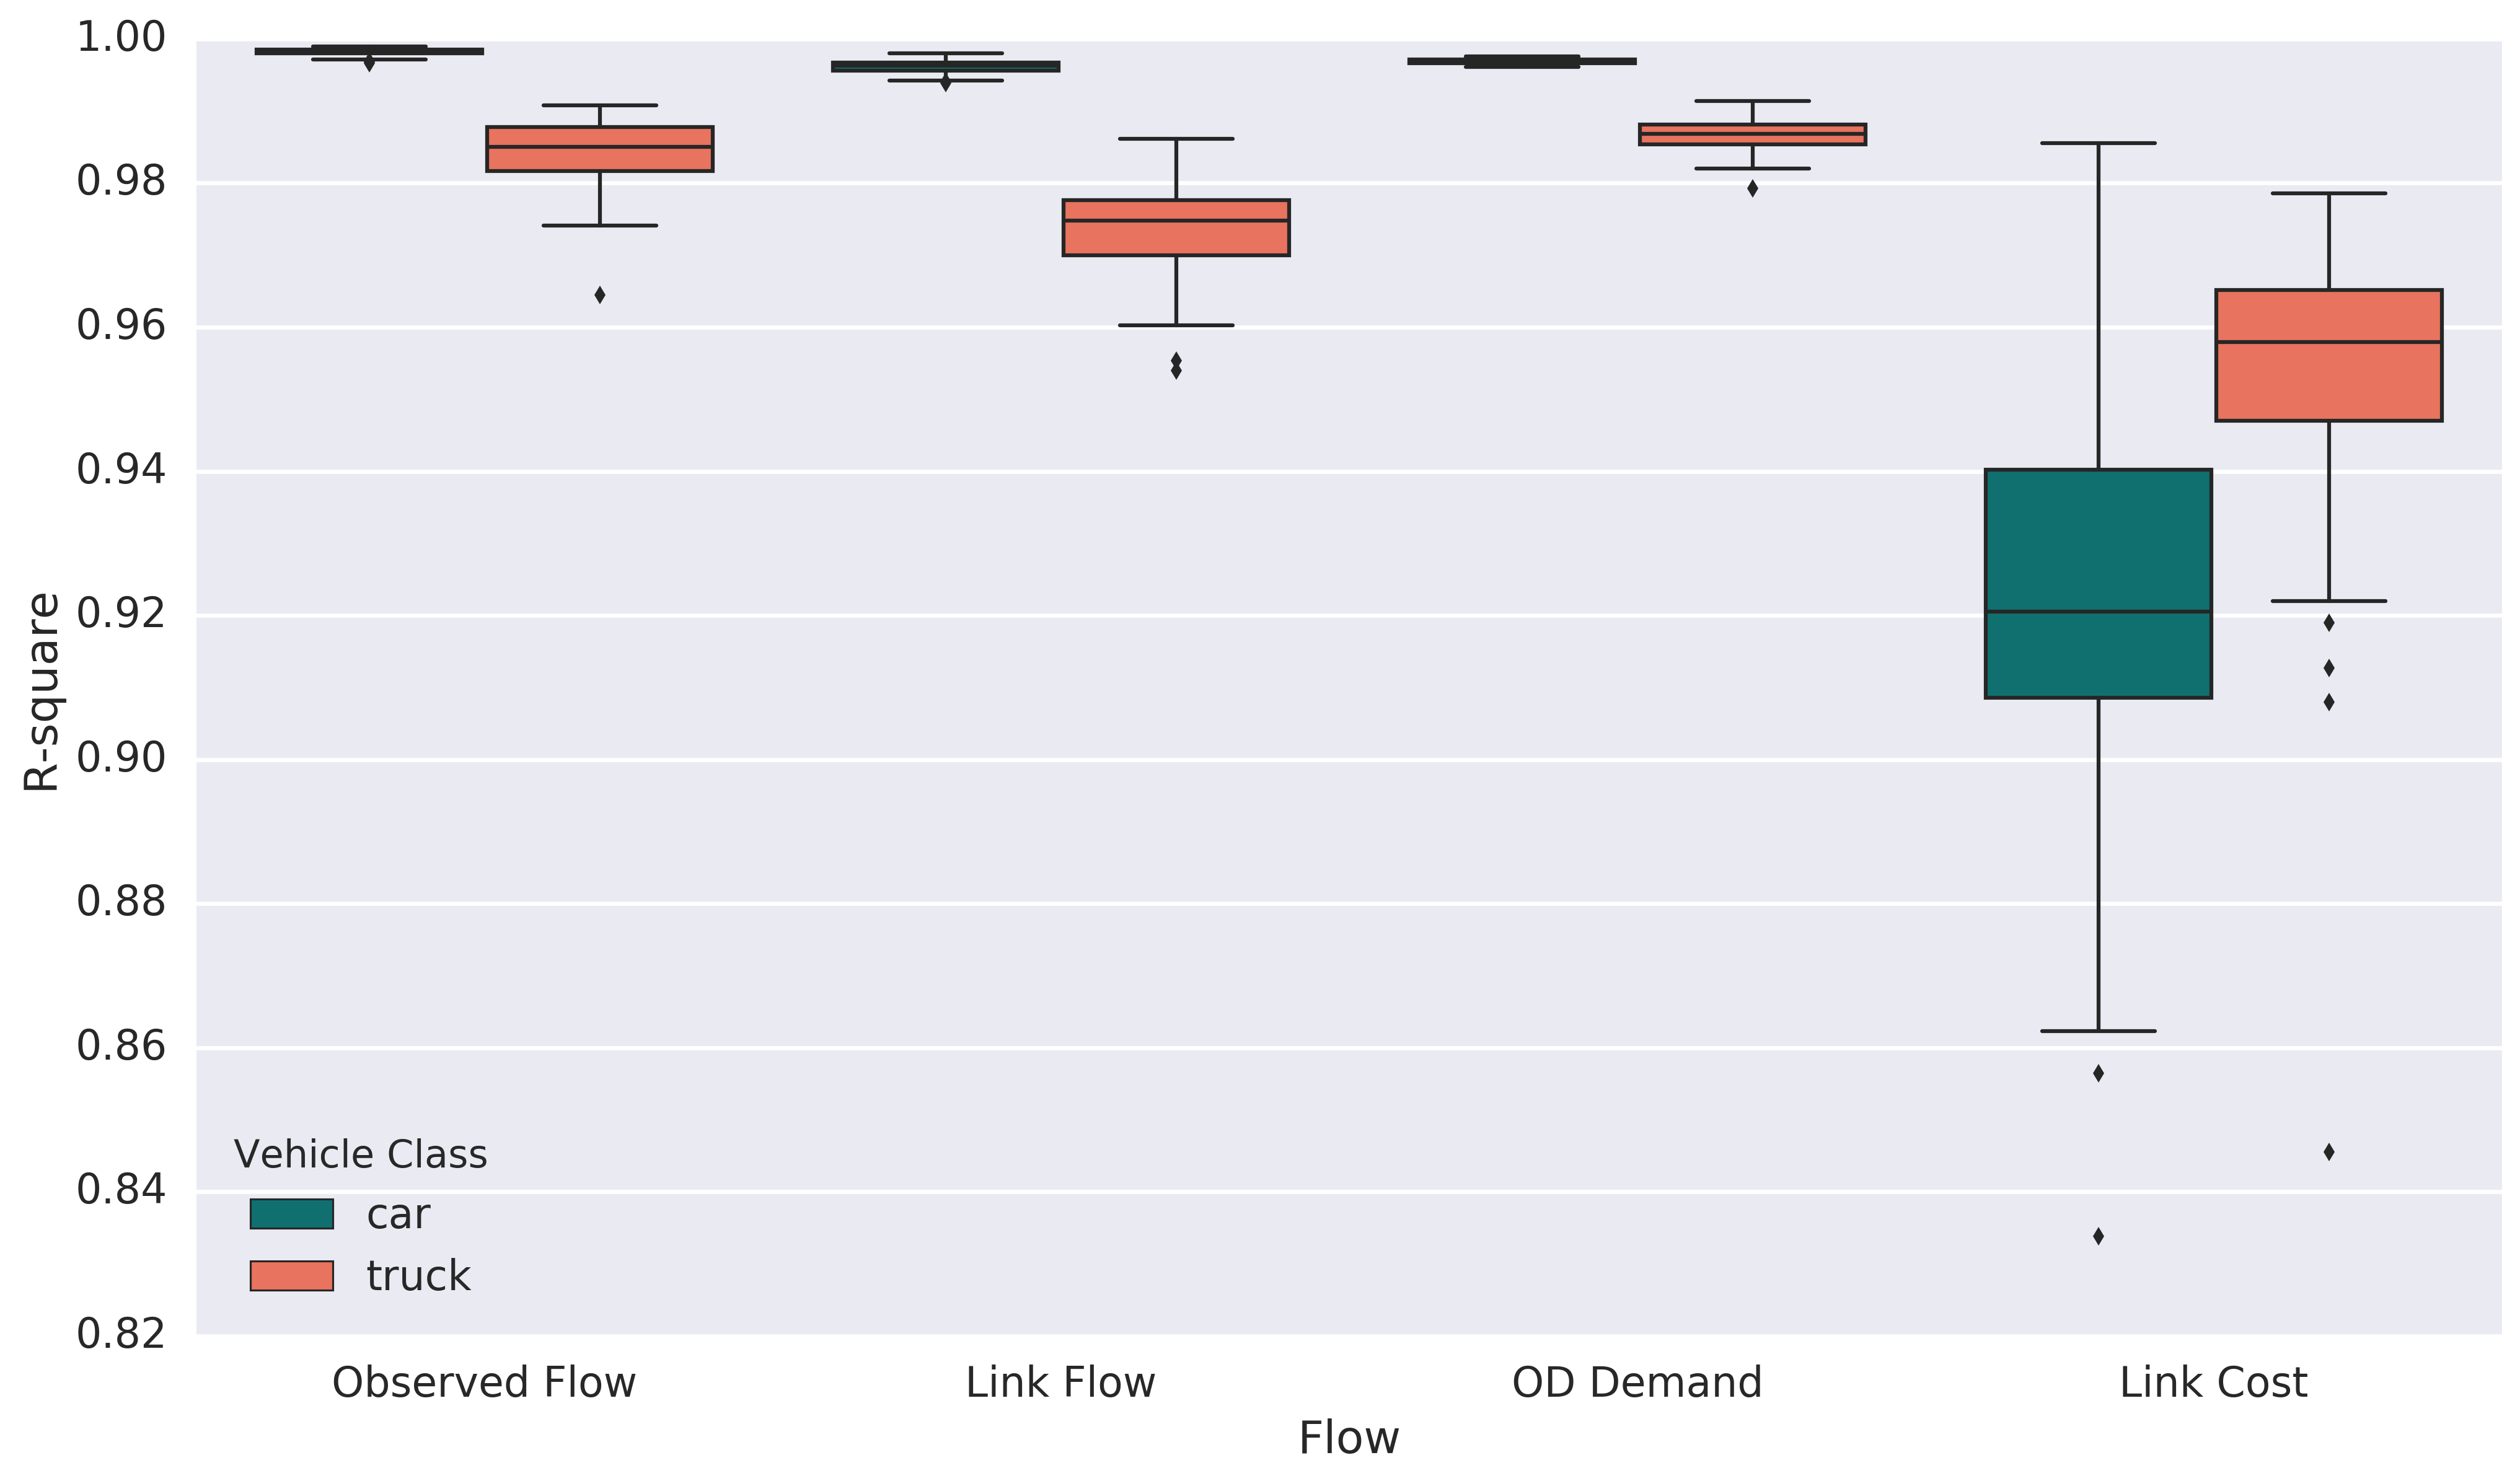

In [61]:
plt.figure(figsize = (16,9), dpi=300)
sns.boxplot(x="Flow", y="R-square", hue="Vehicle Class",
#                split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
                palette=["teal", "tomato"], linewidth=1.5, fliersize = 5,
               data=res_rdf)
plt.show()

## Different observation

In [64]:
dode = MCDODE(nb, config)
(f_car, f_truck) = dode.init_path_flow(car_scale = 5, truck_scale = 0.1)
pickle.dump((f_car, f_truck, None), open('init4obs.pickle', 'w'))

In [67]:
# res2_df = pd.DataFrame(index = range(100), columns = ['y_car', 'y_truck', 'x_car', 'x_truck', 'q_car', 'q_truck',
#                                                    'c_car', 'c_truck'])
for jjj in range(97, 100):
    observed_link_list = [3, 4, 5, 6]
    ml_car = 6
    ml_truck = 5
    data_dict = dict()
    num_interval = nb.config.config_dict['DTA']['max_interval']
    # true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 300
    # true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 30
    true_car_f, true_truck_f, _, _, _, _ = pickle.load(open('final_use.pickle', 'r'))
    # true_car_x = np.random.rand(num_interval * len(observed_link_list)) * 100
    # true_truck_x = np.random.rand(num_interval * len(observed_link_list)) * 10
    # L_car_one = np.random.randint(2, size = (ml_car, len(observed_link_list)))
    L_car_one = np.array([[1, 0, 0, 1],
                          [0, 0, 1, 1],
                          [1, 1, 0, 1],
                          [1, 0, 1, 1],
                          [1, 0, 0, 0],
                          [0, 1, 0, 1]])
    L_truck_one = np.array([[1, 0, 0, 1],
                            [0, 0, 0, 1],
                            [1, 1, 0, 1],
                            [1, 0, 1, 0],
                            [0, 1, 0, 1]])
    # L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
    L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
    L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

    config = dict()
    config['use_car_link_flow'] = True
    config['use_truck_link_flow'] = True
    config['use_car_link_tt'] = True
    config['use_truck_link_tt'] = True
    config['car_count_agg'] = True
    config['truck_count_agg'] = True
    config['link_car_flow_weight'] = 1
    config['link_truck_flow_weight'] = 1
    config['link_car_tt_weight'] = 0.1
    config['link_truck_tt_weight'] = 0.1
    config['num_data'] = 8
    config['observed_links'] = observed_link_list
    config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


    config['compute_car_link_flow_loss'] = True
    config['compute_truck_link_flow_loss'] = True
    config['compute_car_link_tt_loss'] = True
    config['compute_truck_link_tt_loss'] = True

    dode = MCDODE(nb, config)
    dta = dode._run_simulation(true_car_f, true_truck_f)
    true_car_dar, true_truck_dar = dode.get_dar(dta, true_car_f, true_truck_f)

    noise_level = 0.1
    (true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
    true_car_x = true_dar_car.dot(true_car_f)
    true_truck_x = true_dar_truck.dot(true_truck_f)
    true_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    true_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    data_dict['car_count_agg_L_list'] = list()
    data_dict['truck_count_agg_L_list'] = list()
    data_dict['car_link_flow'] = []
    data_dict['truck_link_flow'] = []
    data_dict['car_link_tt'] = []
    data_dict['truck_link_tt'] = []
    for i in range(config['num_data']):
        true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                      np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
        true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                      np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    #     true_car_tt = dta.get_car_link_tt_robust(np.arange(0, dode.num_loading_interval, dode.ass_freq),
    #                              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')

        m_car = L_car.dot(true_car_x)
        m_truck = L_truck.dot(true_truck_x)
        data_dict['car_count_agg_L_list'].append(L_car)
        data_dict['truck_count_agg_L_list'].append(L_truck)
        data_dict['car_link_flow'].append(m_car + np.random.uniform(-1, 1, m_car.shape) * noise_level * m_car)
        data_dict['truck_link_flow'].append(m_truck + np.random.uniform(-1, 1, m_truck.shape) * noise_level * m_truck)
        data_dict['car_link_tt'].append(true_car_tt + np.random.uniform(-1, 1, true_car_tt.shape) * noise_level * true_car_tt)
        data_dict['truck_link_tt'].append(true_truck_tt + np.random.uniform(-1, 1, true_truck_tt.shape) * noise_level * true_truck_tt)
        # data_dict['car_link_tt'] = [m_spd_car]
        # data_dict['truck_link_tt'] = [m_spd_truck]
        
    dode = MCDODE(nb, config)
    dode.add_data(data_dict)
    (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 1, 
                                                             truck_step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True,
                                                            use_file_as_init = 'init4obs.pickle')
    dta = dode._run_simulation(car_flow, truck_flow)
    estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_q = true_car_f.reshape(3, -1, order = 'F').sum(axis = 0)
    est_car_q = car_flow.reshape(3, -1, order = 'F').sum(axis = 0)
    true_truck_q = true_truck_f.reshape(3, -1, order = 'F').sum(axis = 0)
    est_truck_q = truck_flow.reshape(3, -1, order = 'F').sum(axis = 0)
    est_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    est_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    y_car = r2_score(m_car, L_car.dot(estimated_car_x))
    e_m_truck =L_truck.dot(estimated_truck_x)
    y_truck = r2_score(m_truck, e_m_truck)
#     truck_flow = true_truck_f + (np.random.rand(len(true_car_f)) * 2- 1) * np.random.rand() * 2
    x_car = r2_score(true_car_x, estimated_car_x)
    x_truck = r2_score(true_truck_x, estimated_truck_x)
    q_car =  r2_score(true_car_q, est_car_q)
    q_truck =  r2_score(true_truck_q, est_truck_q)
    c_car =  r2(true_car_tt, est_car_tt)
    c_truck =  r2(true_truck_tt, est_truck_tt)
    print [y_car, y_truck, x_car, x_truck, q_car, q_truck, c_car, c_truck]
    res2_df.iloc[jjj] = [y_car, y_truck, x_car, x_truck, q_car, q_truck, c_car, c_truck]

Epoch: 0 Loss: 2006.5 truck_count_loss: 173.34|car_tt_loss: 20.5|car_count_loss: 1792.99|truck_tt_loss: 19.67|
Epoch: 1 Loss: 1938.57 truck_count_loss: 168.25|car_tt_loss: 20.5|car_count_loss: 1712.3|truck_tt_loss: 37.52|
Epoch: 2 Loss: 1865.42 truck_count_loss: 161.68|car_tt_loss: 20.5|car_count_loss: 1630.69|truck_tt_loss: 52.56|
Epoch: 3 Loss: 1765.93 truck_count_loss: 155.41|car_tt_loss: 20.5|car_count_loss: 1548.71|truck_tt_loss: 41.31|
Epoch: 4 Loss: 1673.24 truck_count_loss: 148.65|car_tt_loss: 20.5|car_count_loss: 1468.22|truck_tt_loss: 35.87|
Epoch: 5 Loss: 1578.23 truck_count_loss: 141.94|car_tt_loss: 20.5|car_count_loss: 1388.06|truck_tt_loss: 27.73|
Epoch: 6 Loss: 1488.84 truck_count_loss: 135.52|car_tt_loss: 20.32|car_count_loss: 1310.37|truck_tt_loss: 22.62|
Epoch: 7 Loss: 1406.43 truck_count_loss: 128.91|car_tt_loss: 20.17|car_count_loss: 1234.34|truck_tt_loss: 23.02|
Epoch: 8 Loss: 1317.44 truck_count_loss: 122.69|car_tt_loss: 17.85|car_count_loss: 1158.25|truck_tt_loss

Epoch: 74 Loss: 145.32 truck_count_loss: 12.65|car_tt_loss: 12.05|car_count_loss: 107.74|truck_tt_loss: 12.87|
Epoch: 75 Loss: 142.47 truck_count_loss: 12.74|car_tt_loss: 11.29|car_count_loss: 106.89|truck_tt_loss: 11.55|
Epoch: 76 Loss: 147.99 truck_count_loss: 13.5|car_tt_loss: 13.36|car_count_loss: 109.86|truck_tt_loss: 11.27|
Epoch: 77 Loss: 142.66 truck_count_loss: 12.4|car_tt_loss: 12.74|car_count_loss: 106.73|truck_tt_loss: 10.79|
Epoch: 78 Loss: 142.74 truck_count_loss: 12.83|car_tt_loss: 10.64|car_count_loss: 108.65|truck_tt_loss: 10.63|
Epoch: 79 Loss: 142.41 truck_count_loss: 12.91|car_tt_loss: 10.55|car_count_loss: 106.49|truck_tt_loss: 12.46|
Epoch: 80 Loss: 142.16 truck_count_loss: 12.83|car_tt_loss: 12.77|car_count_loss: 105.38|truck_tt_loss: 11.19|
Epoch: 81 Loss: 144.03 truck_count_loss: 12.32|car_tt_loss: 12.35|car_count_loss: 109.56|truck_tt_loss: 9.8|
Epoch: 82 Loss: 144.78 truck_count_loss: 12.05|car_tt_loss: 12.39|car_count_loss: 108.99|truck_tt_loss: 11.35|
Epoch

Epoch: 47 Loss: 147.62 truck_count_loss: 13.5|car_tt_loss: 12.25|car_count_loss: 111.22|truck_tt_loss: 10.65|
Epoch: 48 Loss: 145.95 truck_count_loss: 12.96|car_tt_loss: 13.37|car_count_loss: 109.71|truck_tt_loss: 9.91|
Epoch: 49 Loss: 150.7 truck_count_loss: 13.71|car_tt_loss: 14.41|car_count_loss: 112.06|truck_tt_loss: 10.53|
Epoch: 50 Loss: 148.88 truck_count_loss: 13.91|car_tt_loss: 13.16|car_count_loss: 111.99|truck_tt_loss: 9.82|
Epoch: 51 Loss: 144.52 truck_count_loss: 12.85|car_tt_loss: 10.1|car_count_loss: 109.21|truck_tt_loss: 12.36|
Epoch: 52 Loss: 147.23 truck_count_loss: 13.43|car_tt_loss: 14.18|car_count_loss: 109.29|truck_tt_loss: 10.32|
Epoch: 53 Loss: 149.96 truck_count_loss: 13.31|car_tt_loss: 12.45|car_count_loss: 111.85|truck_tt_loss: 12.36|
Epoch: 54 Loss: 148.0 truck_count_loss: 13.06|car_tt_loss: 12.3|car_count_loss: 112.55|truck_tt_loss: 10.1|
Epoch: 55 Loss: 147.84 truck_count_loss: 13.27|car_tt_loss: 11.94|car_count_loss: 112.16|truck_tt_loss: 10.47|
Epoch: 56

Epoch: 20 Loss: 469.49 truck_count_loss: 47.72|car_tt_loss: 14.08|car_count_loss: 395.13|truck_tt_loss: 12.57|
Epoch: 21 Loss: 413.93 truck_count_loss: 42.48|car_tt_loss: 12.1|car_count_loss: 346.97|truck_tt_loss: 12.38|
Epoch: 22 Loss: 363.29 truck_count_loss: 37.79|car_tt_loss: 11.79|car_count_loss: 301.04|truck_tt_loss: 12.66|
Epoch: 23 Loss: 316.79 truck_count_loss: 32.99|car_tt_loss: 13.08|car_count_loss: 258.63|truck_tt_loss: 12.1|
Epoch: 24 Loss: 279.96 truck_count_loss: 29.86|car_tt_loss: 12.25|car_count_loss: 225.8|truck_tt_loss: 12.05|
Epoch: 25 Loss: 245.13 truck_count_loss: 26.3|car_tt_loss: 13.35|car_count_loss: 194.26|truck_tt_loss: 11.22|
Epoch: 26 Loss: 218.28 truck_count_loss: 23.23|car_tt_loss: 10.75|car_count_loss: 172.83|truck_tt_loss: 11.47|
Epoch: 27 Loss: 199.8 truck_count_loss: 20.48|car_tt_loss: 13.03|car_count_loss: 154.26|truck_tt_loss: 12.02|
Epoch: 28 Loss: 184.84 truck_count_loss: 19.29|car_tt_loss: 11.96|car_count_loss: 141.47|truck_tt_loss: 12.11|
Epoch:

Epoch: 95 Loss: 146.57 truck_count_loss: 14.01|car_tt_loss: 12.52|car_count_loss: 106.92|truck_tt_loss: 13.12|
Epoch: 96 Loss: 146.86 truck_count_loss: 13.58|car_tt_loss: 11.28|car_count_loss: 108.57|truck_tt_loss: 13.43|
Epoch: 97 Loss: 144.44 truck_count_loss: 13.82|car_tt_loss: 12.23|car_count_loss: 106.81|truck_tt_loss: 11.58|
Epoch: 98 Loss: 153.61 truck_count_loss: 13.57|car_tt_loss: 13.73|car_count_loss: 109.5|truck_tt_loss: 16.82|
Epoch: 99 Loss: 144.7 truck_count_loss: 13.38|car_tt_loss: 11.86|car_count_loss: 107.45|truck_tt_loss: 12.01|
[0.9987243725341017, 0.9859283606494672, 0.9970137723338686, 0.973619024238407, 0.9973332246629507, 0.985188084165191, 0.9805881500931, 0.936603250189888]


In [68]:
res2_df

y_car   y_truck     x_car   x_truck     q_car   q_truck     c_car  \
0   0.998482  0.984122   0.99613  0.971049  0.998922   0.99273  0.920804   
1   0.998461  0.982158  0.996039  0.959987   0.99526  0.984342   0.94432   
2   0.997657  0.966687  0.993896  0.952832  0.998508   0.99332  0.961393   
3   0.998554  0.983907  0.996401   0.97341  0.996324  0.983122    0.9171   
4   0.996608  0.984214  0.991489  0.970218  0.996996  0.991671   0.82313   
5   0.999116  0.984079  0.997439    0.9726  0.999078  0.994761  0.937554   
6   0.997712  0.988939   0.99514   0.97853  0.998236  0.991414   0.89433   
7   0.998038  0.980158  0.995897  0.968094   0.99839  0.987838  0.929516   
8   0.998355  0.982906  0.994324  0.968404  0.996854  0.981161  0.916602   
9   0.998723  0.977825  0.996918  0.968909  0.996886  0.984505  0.891841   
10  0.998668  0.984908  0.996971  0.972604   0.99822  0.991071  0.931315   
11   0.99742  0.977974  0.992912  0.958932  0.998445  0.991892  0.903197   
12  0.999011  0.984144  0.997049  0.973002  0.999127  0.993942  0.935931   
13  0.998999   0.98519  0.996755  0.975048  0.997969  0.994966  0.964787   
14  0.998601  0.986914  0.996546  0.972491  0.998167  0.987446  0.928235   
15  0.998392  0.984441  0.995947   0.97284   0.99548  0.989816  0.943331   
16  0.998593  0.988403  0.996322  0.969385  0.998912  0.995474  0.906824   
17  0.998974   0.99116  0.996104  0.978356  0.998607  0.985031  0.965342   
18  0.997818  0.953175  0.995465  0.940746  0.994495   0.97715  0.910128   
19  0.998575  0.990092  0.996596  0.979915  0.995896  0.986046    0.9492   
20  0.997707  0.984821  0.995402  0.972477  0.998148  0.990005  0.914519   
21   0.99772  0.972188  0.994827  0.943655  0.998572  0.989455  0.903029   
22   0.99826  0.983235  0.993259  0.971793  0.996012   0.98455  0.946499   
23  0.998464  0.969424   0.99715  0.945304    0.9987  0.993847  0.961003   
24  0.998443  0.988271  0.996218  0.978375   0.99856  0.989677  0.909653   
25  0.997771  0.983733  0.995885   0.97287  0.998728  0.987247  0.926507   
26  0.998122  0.988933   0.99718  0.978346  0.998239  0.993956  0.872489   
27  0.998193  0.991528  0.994897  0.977086   0.99554   0.99427  0.920559   
28  0.998427   0.97404  0.996612  0.957787    0.9966  0.989422   0.97972   
29  0.997923  0.978057  0.993025  0.968622  0.996893   0.98388  0.935448   
..       ...       ...       ...       ...       ...       ...       ...   
70  0.998682  0.967061  0.996186  0.948215  0.997855  0.983711  0.917191   
71  0.998948  0.979017  0.996093   0.96494  0.996403  0.991331  0.890376   
72  0.998751  0.987207  0.996856  0.979647  0.998521  0.996352  0.975731   
73  0.998569  0.983504  0.996443  0.972556  0.996678  0.984377  0.947205   
74  0.998513  0.980848  0.996228  0.968637  0.996612  0.991803  0.939506   
75  0.998112  0.988184  0.994513  0.970954  0.996595  0.985409  0.941044   
76  0.997007  0.984477  0.994718  0.971181  0.998565  0.980185  0.932223   
77  0.998171   0.97315  0.994473  0.959076   0.99533  0.989269  0.941023   
78  0.997933  0.978701  0.995602  0.964909  0.998613  0.982277  0.929831   
79  0.998766  0.982941  0.996288   0.96888  0.998175  0.991205  0.985125   
80  0.997805  0.985375  0.993505  0.973431  0.997037  0.984774  0.881407   
81  0.998465  0.987712  0.995926  0.978264  0.998751  0.996474  0.941716   
82  0.998794  0.975979  0.995961  0.967662  0.996729  0.995046  0.931849   
83   0.99798   0.97999  0.993843   0.96523  0.995822  0.995228  0.949816   
84  0.999168    0.9661  0.997015   0.94889  0.998291  0.972449  0.916368   
85  0.997795  0.972194  0.994509  0.942626  0.995937  0.983751      0.87   
86  0.999017  0.972892  0.997173  0.949554  0.997931  0.977244  0.910372   
87  0.997739   0.97915  0.993574  0.960426  0.996719   0.99246   0.88807   
88  0.998461  0.975598  0.996743   0.95622  0.998221  0.988277  0.901433   
89  0.997888  0.991733  0.995362  0.986504  0.998276  0.990501   0.88456   
90  0.998742  0.976129  0.996098  0.959223  0.997767  0

In [69]:
pickle.dump(res2_df, open('obs_res2_df.pickle', 'wb'))

In [71]:
res2_rdf = pd.DataFrame(index = range(800), columns = ['R-square', 'Vehicle Class', 'Flow'])
for i in range(100):
#     print i
    res2_rdf.iloc[i * 8 + 0] = [res2_df.iloc[i, 0], 'car', 'Observed Flow']
    res2_rdf.iloc[i * 8 + 1] = [res2_df.iloc[i, 1], 'truck', 'Observed Flow']
    res2_rdf.iloc[i * 8 + 2] = [res2_df.iloc[i, 2], 'car', 'Link Flow']
    res2_rdf.iloc[i * 8 + 3] = [res2_df.iloc[i, 3], 'truck', 'Link Flow']
    res2_rdf.iloc[i * 8 + 4] = [res2_df.iloc[i, 4], 'car', 'OD Demand']
    res2_rdf.iloc[i * 8 + 5] = [res2_df.iloc[i, 5], 'truck', 'OD Demand']
    res2_rdf.iloc[i * 8 + 6] = [res2_df.iloc[i, 6], 'car', 'Link Cost']
    res2_rdf.iloc[i * 8 + 7] = [res2_df.iloc[i, 7], 'truck', 'Link Cost']

In [72]:
res2_rdf['R-square'] = res2_rdf['R-square'].astype(np.float32)

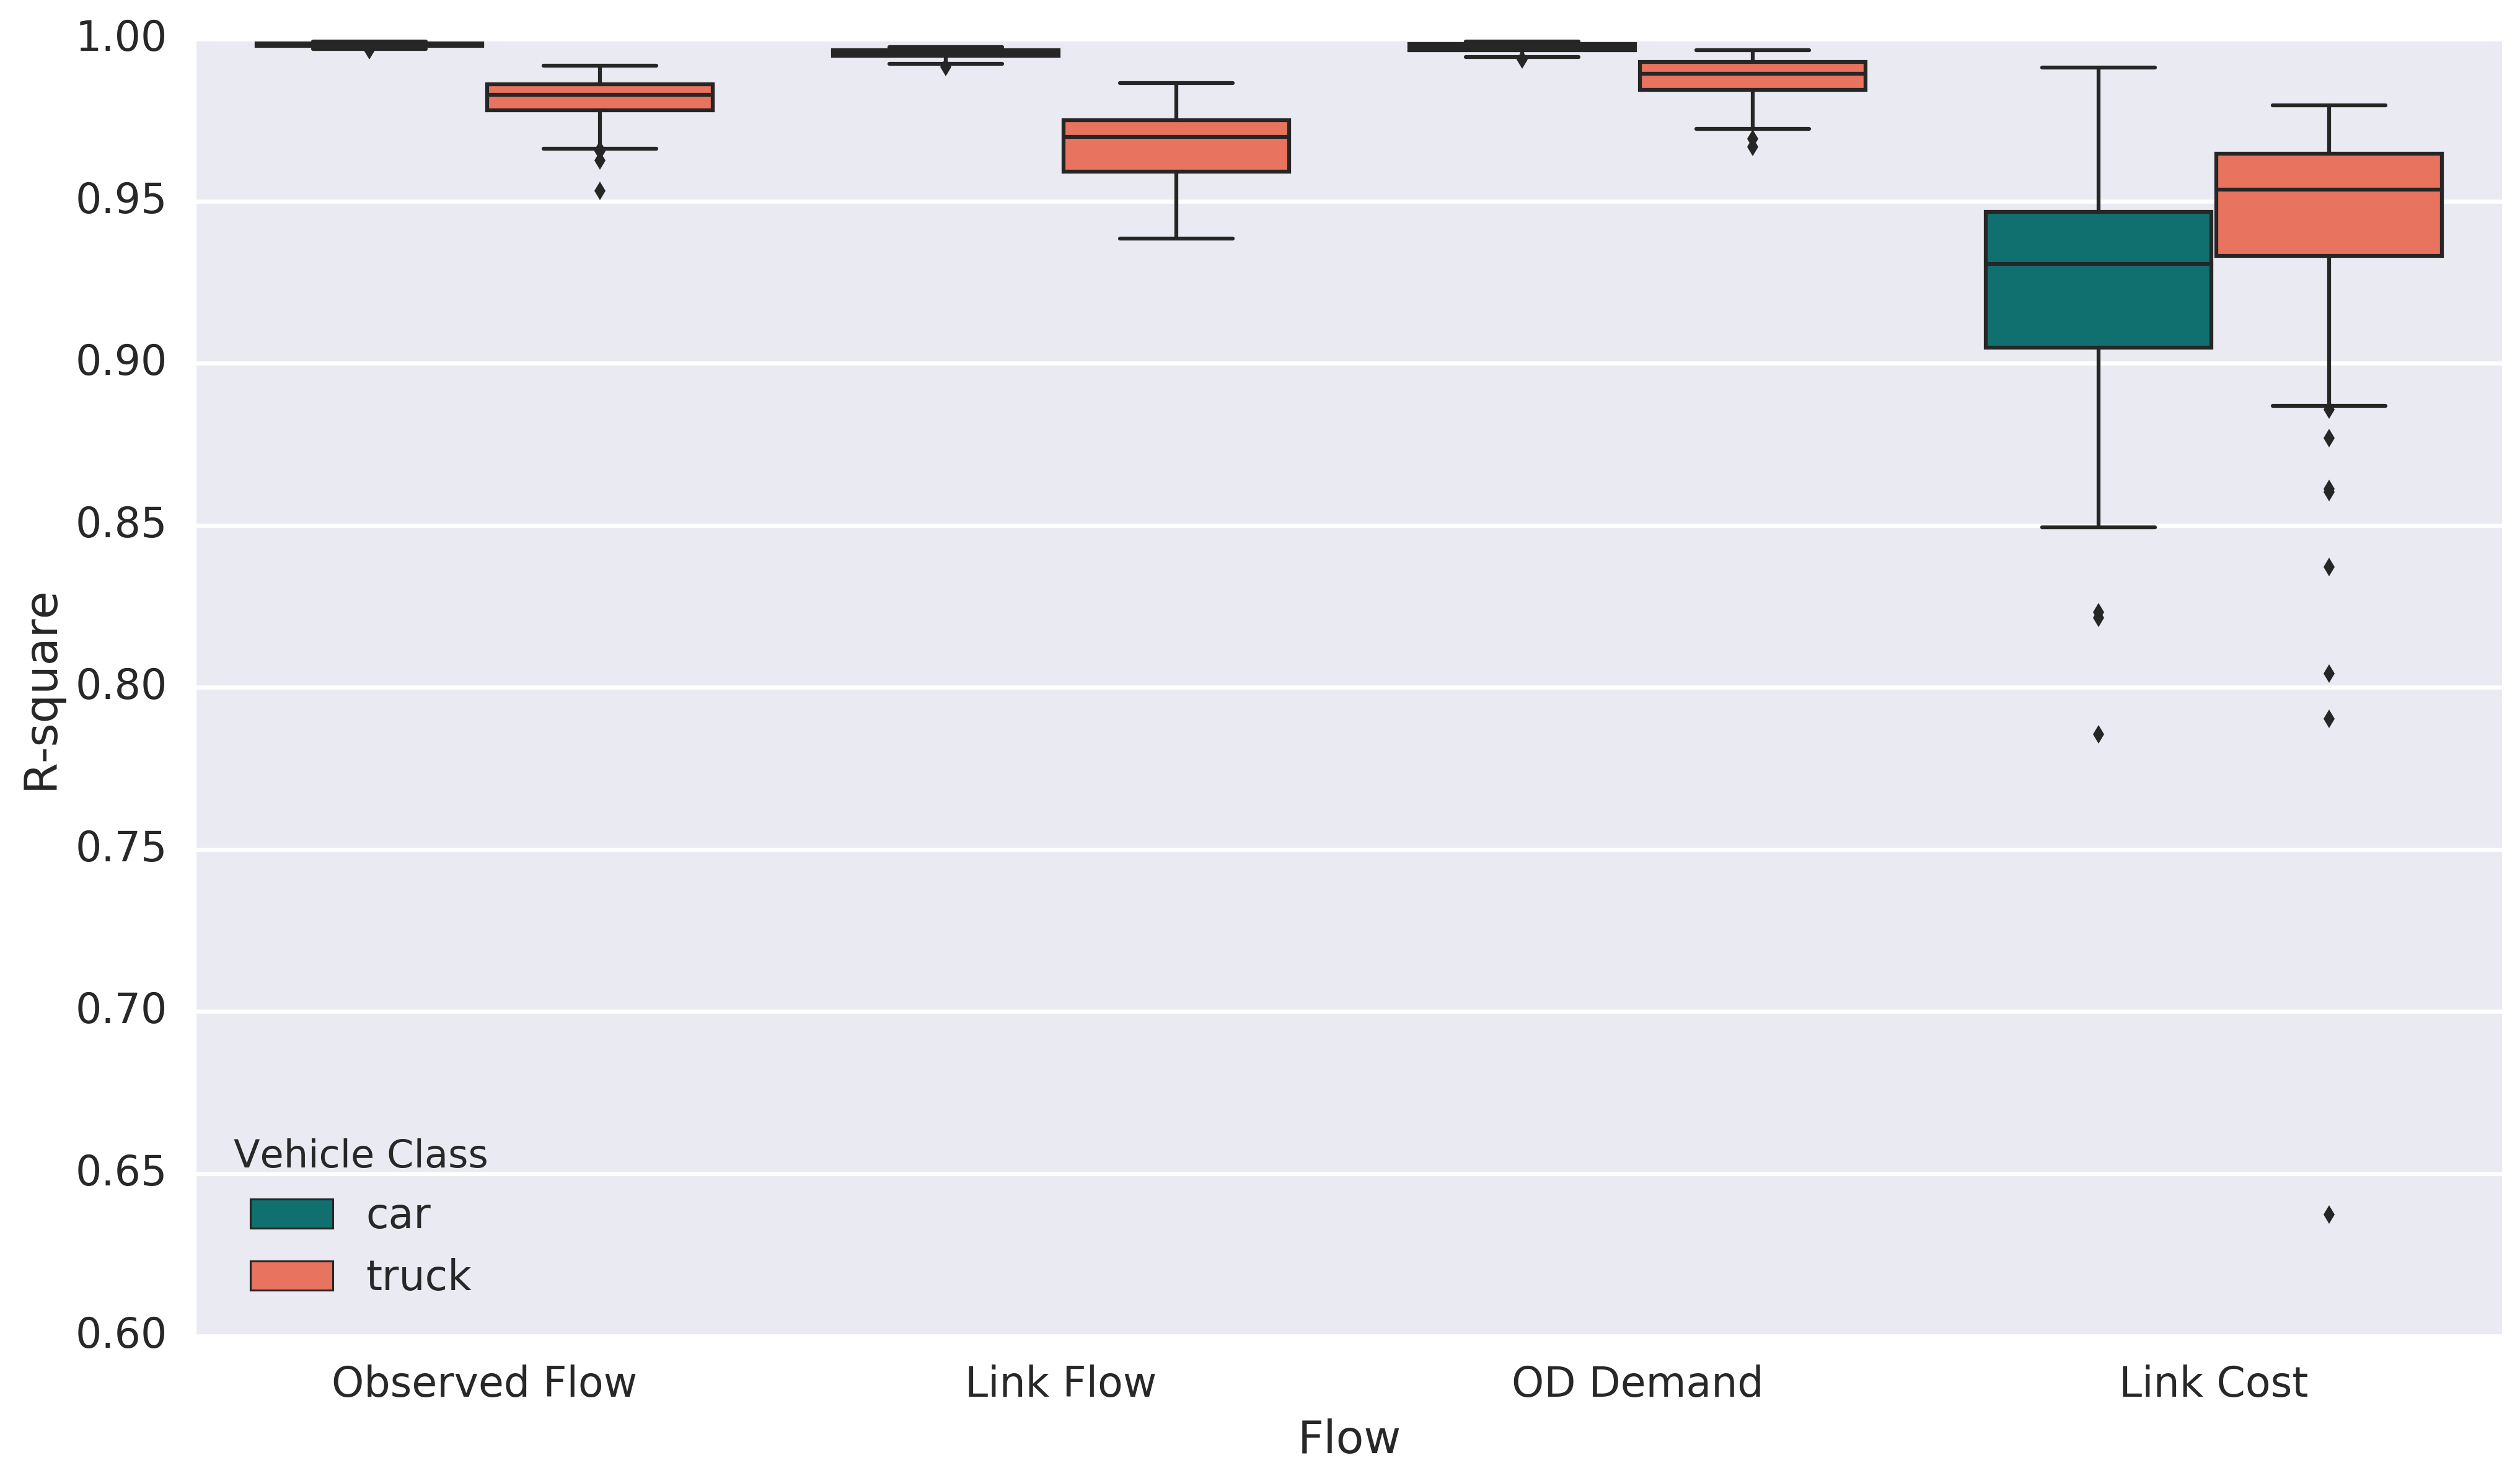

In [73]:
plt.figure(figsize = (16,9), dpi=300)
sns.boxplot(x="Flow", y="R-square", hue="Vehicle Class",
#                split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
            palette=["teal", "tomato"], linewidth=1.5, fliersize = 5,
               data=res2_rdf)
plt.show()

In [47]:
tips = sns.load_dataset("tips")

In [50]:
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

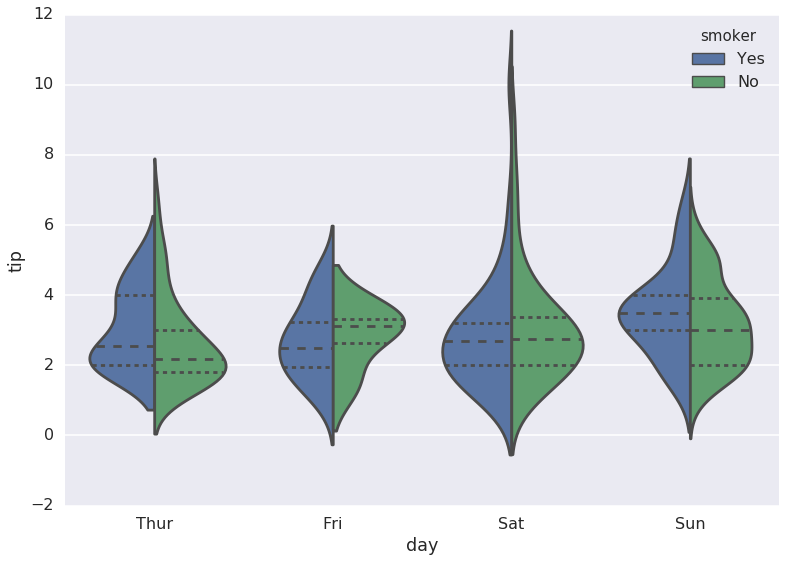

In [54]:
sns.violinplot(x="day", y="tip", hue="smoker",
               split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
               data=tips)